# Segmentation

## Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q dicom2nifti
!pip install -q scikit-fuzzy
!pip install -q med2image
!pip install -q MedPy
!pip install -q sh
!pip install -q segmentation


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.6/634.6 kB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━

In [ ]:
import dicom2nifti
import cv2
import nibabel as nib
from time import time
import skfuzzy as fuzz
import med2image
from sh import gunzip
import os
from google.colab.patches import cv2_imshow
from medpy.filter.smoothing import anisotropic_diffusion
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import shutil
from sklearn.metrics import mean_squared_error

In [ ]:
dicom_directory = "/content/drive/MyDrive/Pancreatic tumor /2.000000-3Plane Loc SSFSE BH-84735"
!mkdir "output_nifti"
!mkdir "output_nifti/2.000000-3Plane Loc SSFSE BH-84735"
output_folder = '/content/output_nifti/2.000000-3Plane Loc SSFSE BH-84735'

In [ ]:
dicom2nifti.convert_directory(dicom_directory, output_folder, compression=True, reorient=True)

In [ ]:
file = '/content/output_nifti/2.000000-3Plane Loc SSFSE BH-84735/2_3plane_loc_ssfse_bh.nii.gz'
img = nib.load(file)
img.shape

(512, 512, 15)

In [ ]:
gunzip('/content/output_nifti/2.000000-3Plane Loc SSFSE BH-84735/2_3plane_loc_ssfse_bh.nii.gz')

''

In [ ]:
!med2image -i '/content/output_nifti/2.000000-3Plane Loc SSFSE BH-84735/2_3plane_loc_ssfse_bh.nii'\
          -d nifti-results/all-slices                  \
          -o sample.jpg -s -1

sliceToConvert: -1
2023-06-29 07:47:37  │    1f1c4e377a74 │                  med2image.py:med2image.run() │ About to perform NifTI to jpg conversion...

2023-06-29 07:47:37  │    1f1c4e377a74 │                  med2image.py:med2image.run() │ 3D volume detected.

2023-06-29 07:47:37  │    1f1c4e377a74 │             med2image.py:med2image.dim_save() │ Saving along "z" dimension with 90 degree rotation...
2023-06-29 07:47:38  │    1f1c4e377a74 │             med2image.py:med2image.dim_save() │ 15 images saved along "z" dimension.


In [ ]:
!mkdir "/content/preprocess_output"
!mkdir "/content/preprocess_output/processed_img"
!mkdir "/content/preprocess_output/mask"

In [ ]:
directory = '/content/nifti-results/all-slices'
output = '/content/preprocess_output/processed_img'
mask = '/content/preprocess_output/mask'

for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # print(os.path.join(mask , '_mask_'+filename))
        img = cv2.imread(os.path.join(directory, filename), 0)
        equ = cv2.equalizeHist(img)
        clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
        cl_img = clahe.apply(img)
        cl_img = anisotropic_diffusion(cl_img)
        cl_img = cl_img.astype(np.uint8)
        ret, thresh1 = cv2.threshold(cl_img, 190, 150, cv2.THRESH_BINARY)
        ret, thresh2 = cv2.threshold(cl_img, 190, 255, cv2.THRESH_BINARY_INV)
        ret, thresh3 = cv2.threshold(cl_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        cv2.imwrite(os.path.join(output , '_pre_'+filename), cl_img)
        cv2.imwrite(os.path.join(mask , '_mask_'+filename), thresh3)
        # cv2.imwrite(os.path.join(output)+'_pre_'+filename,thresh3)
    else:
        continue

/usr/local/lib/python3.10/dist-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/usr/local/lib/python3.10/dist-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


## FCMeans

In [ ]:
def change_color_fuzzycmeans(cluster_membership, clusters):
    img = []
    for pix in cluster_membership.T:
        img.append(clusters[np.argmax(pix)])
    return img

def bwarea(img):
    row = img.shape[0]
    col = img.shape[1]
    total = 0.0
    for r in range(row-1):
        for c in range(col-1):
            sub_total = img[r:r+2, c:c+2].mean()
            if sub_total == 255:
                total += 1
            elif sub_total == (255.0/3.0):
                total += (7.0/8.0)
            elif sub_total == (255.0/4.0):
                total += 0.25
            elif sub_total == 0:
                total += 0
            else:
                r1c1 = img[r,c]
                r1c2 = img[r,c+1]
                r2c1 = img[r+1,c]
                r2c2 = img[r+1,c+1]

                if (((r1c1 == r2c2) & (r1c2 == r2c1)) & (r1c1 != r2c1)):
                    total += 0.75
                else:
                    total += 0.5
    return total

def imclearborder(imgBW):

    # Given a black and white image, first find all of its contours
    radius = 2
    imgBWcopy = imgBW.copy()
    contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST,
        cv2.CHAIN_APPROX_SIMPLE)

    # Get dimensions of image
    imgRows = imgBW.shape[0]
    imgCols = imgBW.shape[1]

    contourList = [] # ID list of contours that touch the border

    # For each contour...
    for idx in np.arange(len(contours)):
        # Get the i'th contour
        cnt = contours[idx]

        # Look at each point in the contour
        for pt in cnt:
            rowCnt = pt[0][1]
            colCnt = pt[0][0]

            # If this is within the radius of the border
            # this contour goes bye bye!
            check1 = (rowCnt >= 0 and rowCnt < radius) or (rowCnt >= imgRows-1-radius and rowCnt < imgRows)
            check2 = (colCnt >= 0 and colCnt < radius) or (colCnt >= imgCols-1-radius and colCnt < imgCols)

            if check1 or check2:
                contourList.append(idx)
                break

    for idx in contourList:
        cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy

#### bwareaopen definition
def bwareaopen(imgBW, areaPixels):
    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST,
        cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, determine its total occupying area
    for idx in np.arange(len(contours)):
        area = cv2.contourArea(contours[idx])
        if (area >= 0 and area <= areaPixels):
            cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy

def imfill(im_th):

    im_floodfill = im_th.copy()
    # Mask used to flood filling.

    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv

    return im_out

In [ ]:
!mkdir "out"
!mkdir "out/benign"
!mkdir "out/malignant"

In [ ]:
!unzip '/content/drive/MyDrive/Pancreatic tumor /healthy.zip'

Archive:  /content/drive/MyDrive/Datasets/Pancreatic tumor /healthy.zip
   creating: healthy/
  inflating: healthy/55a9a4da6f662d814ac41b001ad271_gallery.png  
  inflating: healthy/benign pancrea.png  
  inflating: healthy/c8d480b2d5ed15e024c3cb571fbb49_gallery.png  
  inflating: healthy/ce3764d02e6b1d81deae456705b2a3_gallery.png  


In [ ]:
from math import log10, sqrt
import cv2
import numpy as np

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [ ]:
def FCMeans(imga, filename, flag):
  clusters = [2,3,6]
  results  = []
  # looping every images

  rgb_img = crop_img.reshape((imga.shape[0] * crop_img.shape[1], 3))
  print(rgb_img.shape)

  if flag == 1:
    img = np.reshape(rgb_img, (170, 101,3)).astype(np.uint8)
  else:
    img = np.reshape(rgb_img, (100, 81,3)).astype(np.uint8)

  shape = np.shape(img)


  # initialize graph
  plt.figure(figsize=(20,20))
  plt.subplot(1,4,1)
  plt.imshow(img)
  for i,cluster in enumerate(clusters):

    # Fuzzy C Means
    # new_time = time()

    # error = 0.005
    # maximum iteration = 1000
    # cluster = 2,3,6,8

    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    rgb_img.T, cluster, 2, error=0.005, maxiter=1000, init=None,seed=42)

    new_img = change_color_fuzzycmeans(u,cntr)

    fuzzy_img = np.reshape(new_img,shape).astype(np.uint8)

    ret, seg_img = cv2.threshold(fuzzy_img,np.max(fuzzy_img)-1,255,cv2.THRESH_BINARY)

    print('Fuzzy time for cluster',cluster)
    # print(time() - new_time,'seconds')
    seg_img_1d = seg_img[:,:,1]


    bwfim1 = bwareaopen(seg_img_1d, 100)
    bwfim2 = imclearborder(bwfim1)
    bwfim3 = imfill(bwfim2)
    results.append(bwfim3)

    print('Bwarea : '+str(bwarea(bwfim3)))
    print()

    plt.subplot(1,4,i+2)
    plt.imshow(bwfim3, cmap="gray")
    # cv2_imshow(bwfim3)
    name = 'Cluster'+str(cluster)
    # plt.title(name)
    fname = str(filename)+'.png'

    if flag == 1:
        cv2.imwrite(os.path.join('/content/out/malignant' , 'fcmeans_'+fname), bwfim3)
    else:
      cv2.imwrite(os.path.join('/content/out/benign' , 'fcmeans_'+fname), bwfim3)

    # cv2.imwrite(filename, bwfim3)

  print(f'BWFM3 :{np.shape(bwfim3)} Image: {np.shape(imga)}')
  name = 'FCMsegmented_'+str(i)+'.png'
  plt.savefig(name)
  print(bwfim3.shape)
  plt.show(cv2_imshow(bwfim3))

  with open('PSNR FCMeans.txt','a') as file:
    file.write(fname+'PSNR Value'+str(PSNR(imga,bwfim3))+'\n'+\
               fname+'MSE Value'+str(mean_squared_error(imga,bwfim3))+'\n'
                )
  # print(f"PSNR: {PSNR(imga,bwfim3)}")

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 0.0

Fuzzy time for cluster 3
Bwarea : 823.5

Fuzzy time for cluster 6
Bwarea : 693.5

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


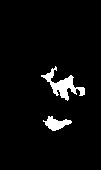

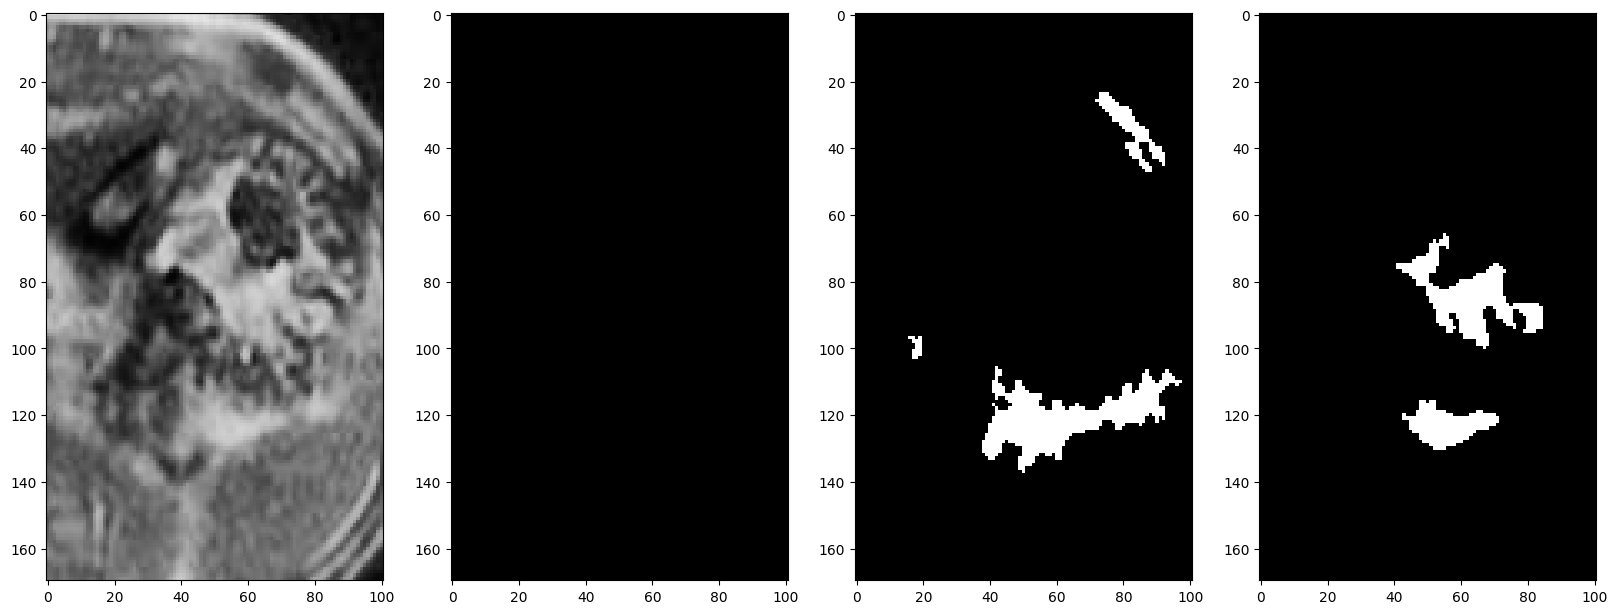

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 0.0

Fuzzy time for cluster 3
Bwarea : 2125.25

Fuzzy time for cluster 6
Bwarea : 869.0

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


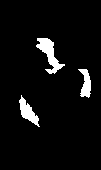

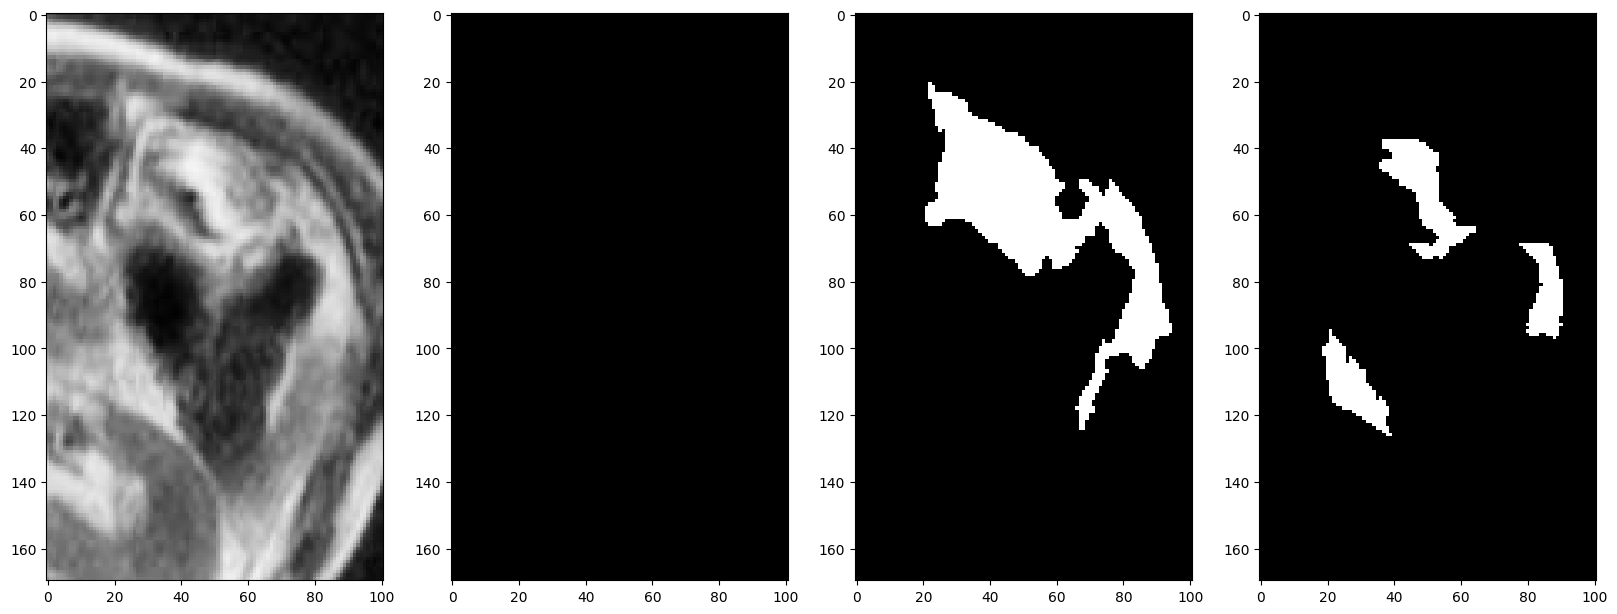

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 130.75

Fuzzy time for cluster 3
Bwarea : 4.75

Fuzzy time for cluster 6
Bwarea : 750.0

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


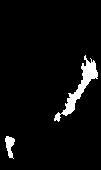

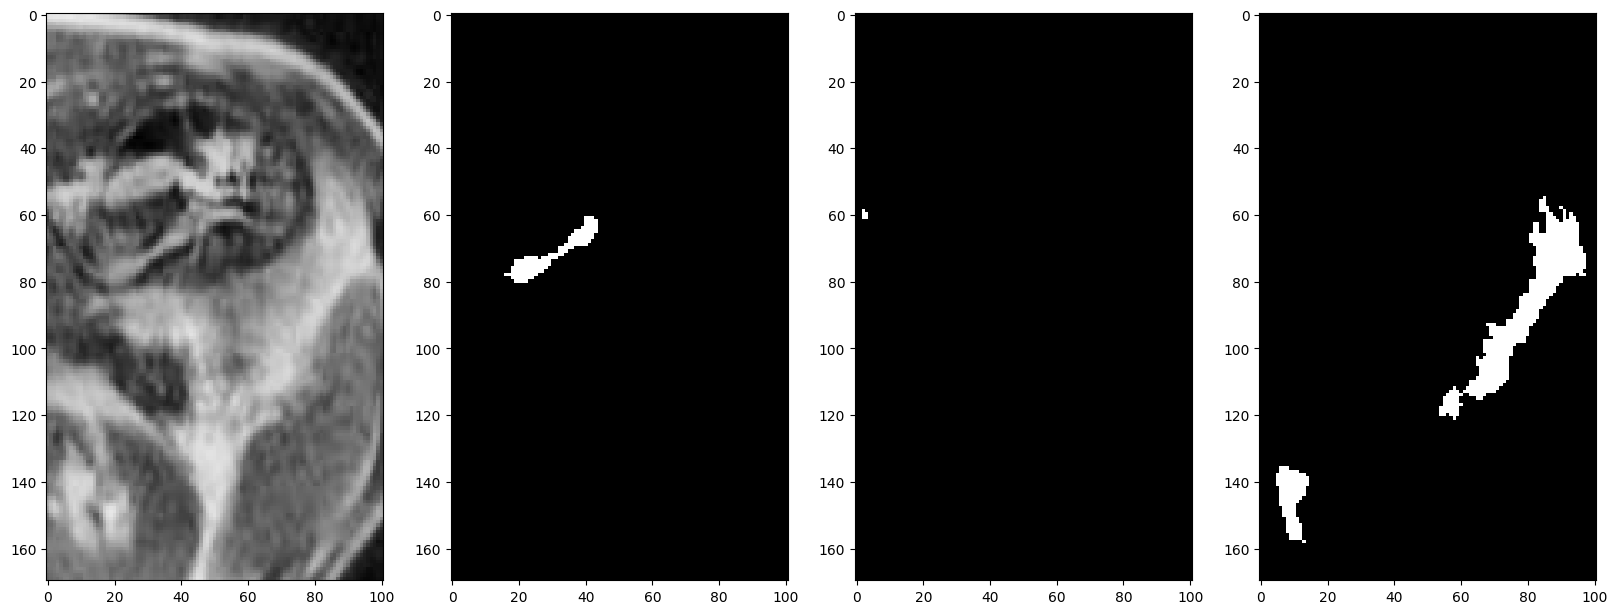

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 991.0

Fuzzy time for cluster 3
Bwarea : 480.0

Fuzzy time for cluster 6
Bwarea : 0.0

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


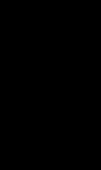

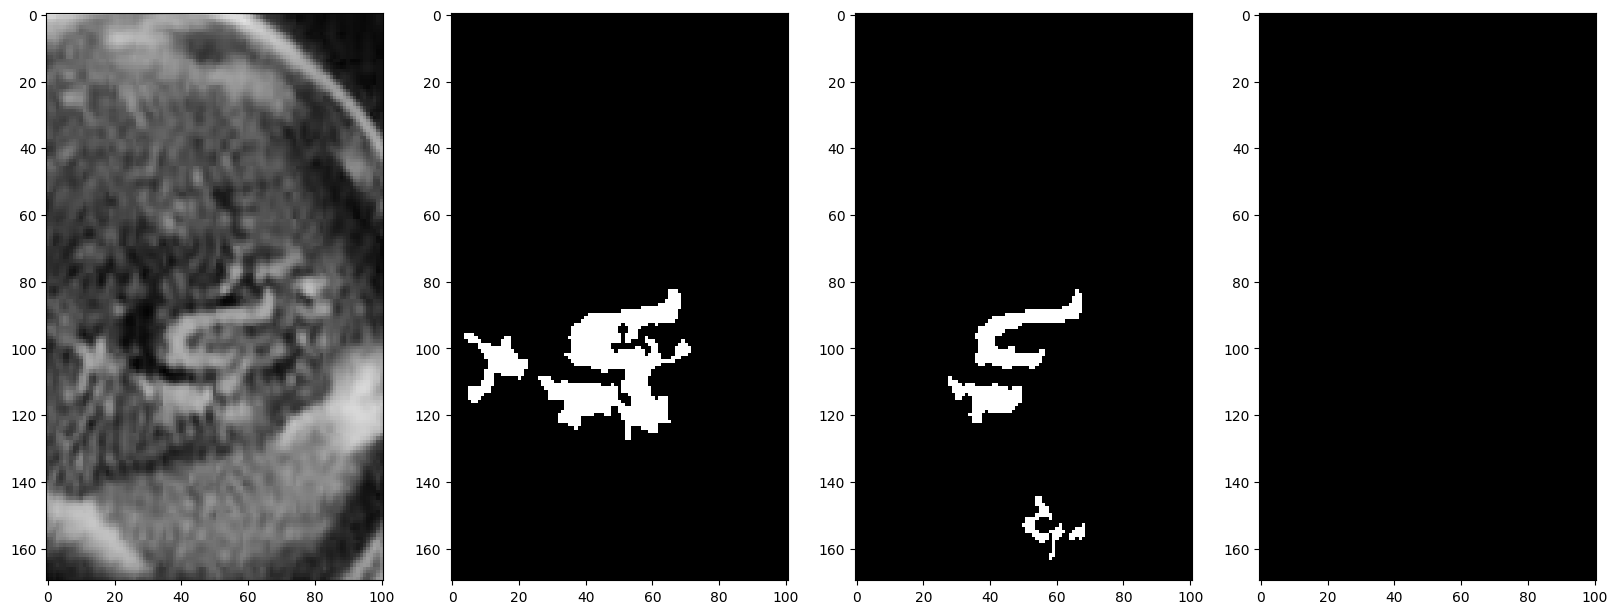

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 1453.0

Fuzzy time for cluster 3
Bwarea : 939.25

Fuzzy time for cluster 6
Bwarea : 228.75

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


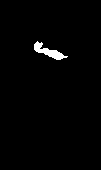

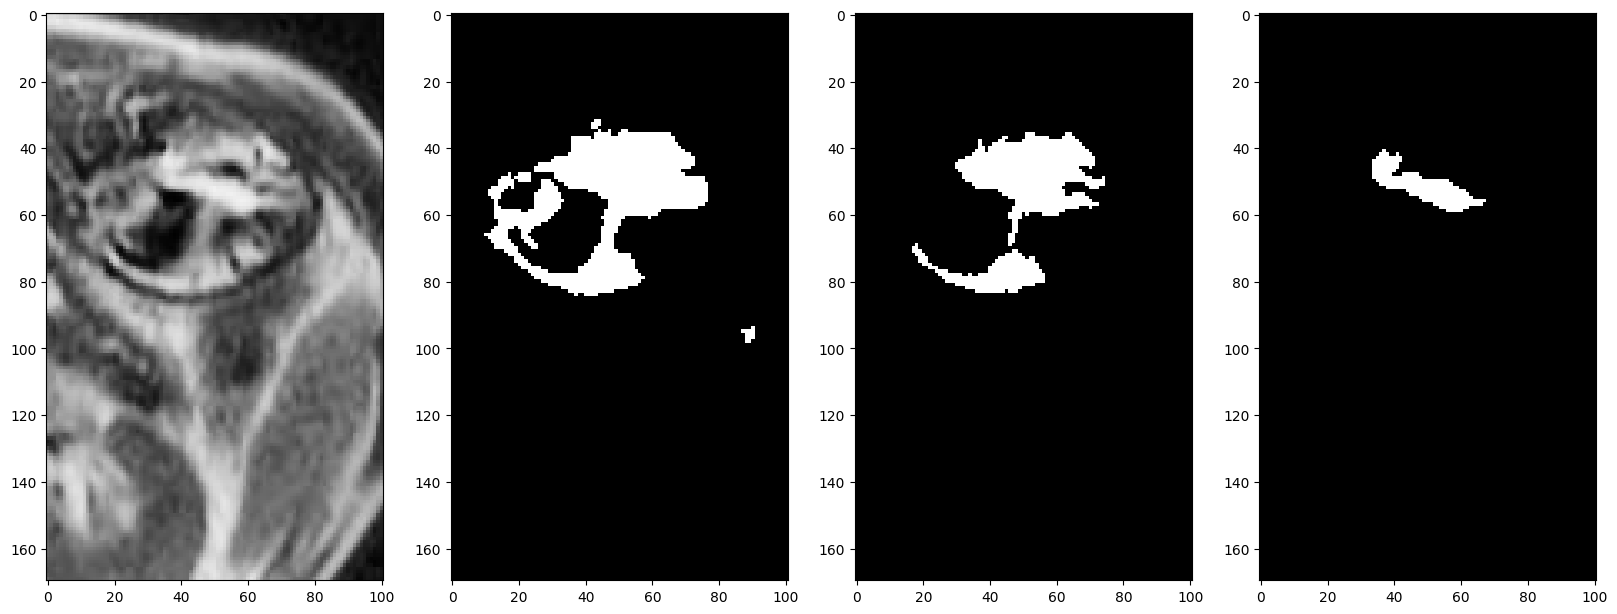

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 0.0

Fuzzy time for cluster 3
Bwarea : 0.0

Fuzzy time for cluster 6
Bwarea : 618.5

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


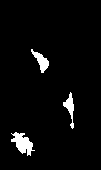

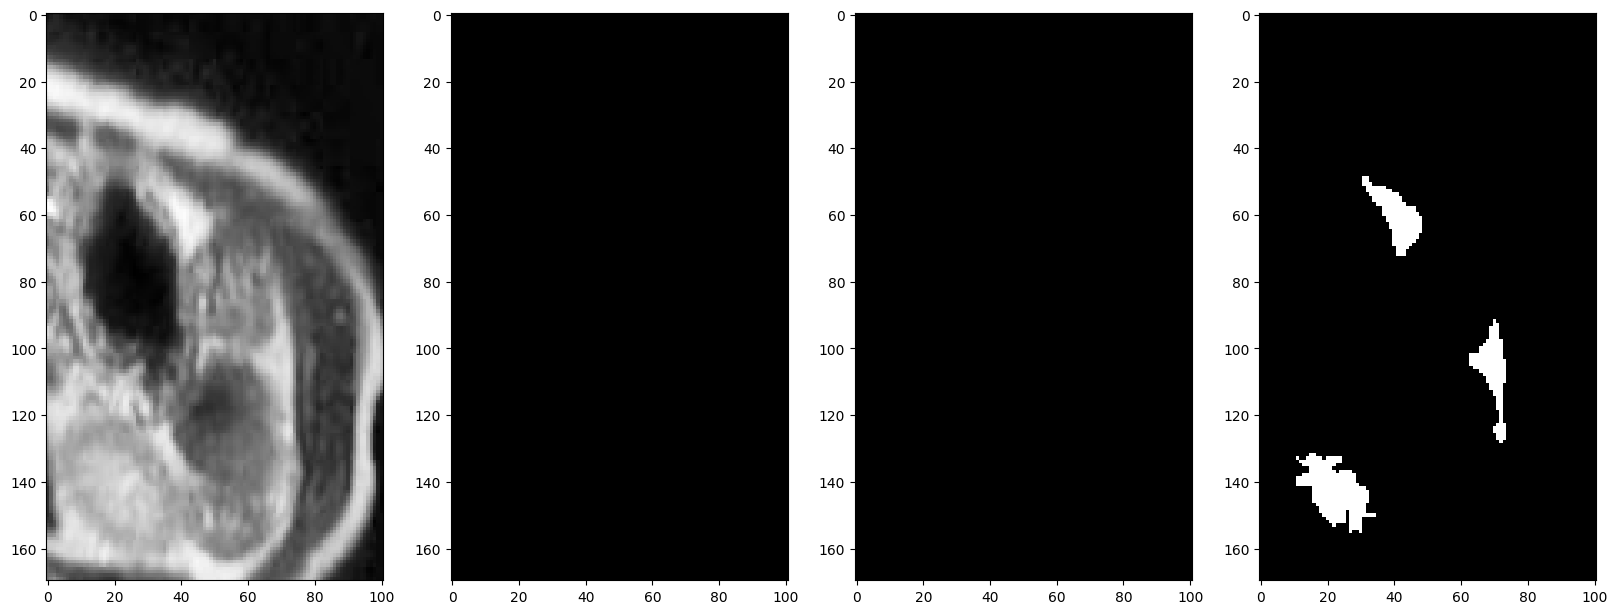

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 0.0

Fuzzy time for cluster 3
Bwarea : 798.0

Fuzzy time for cluster 6
Bwarea : 291.25

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


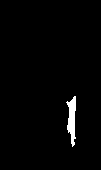

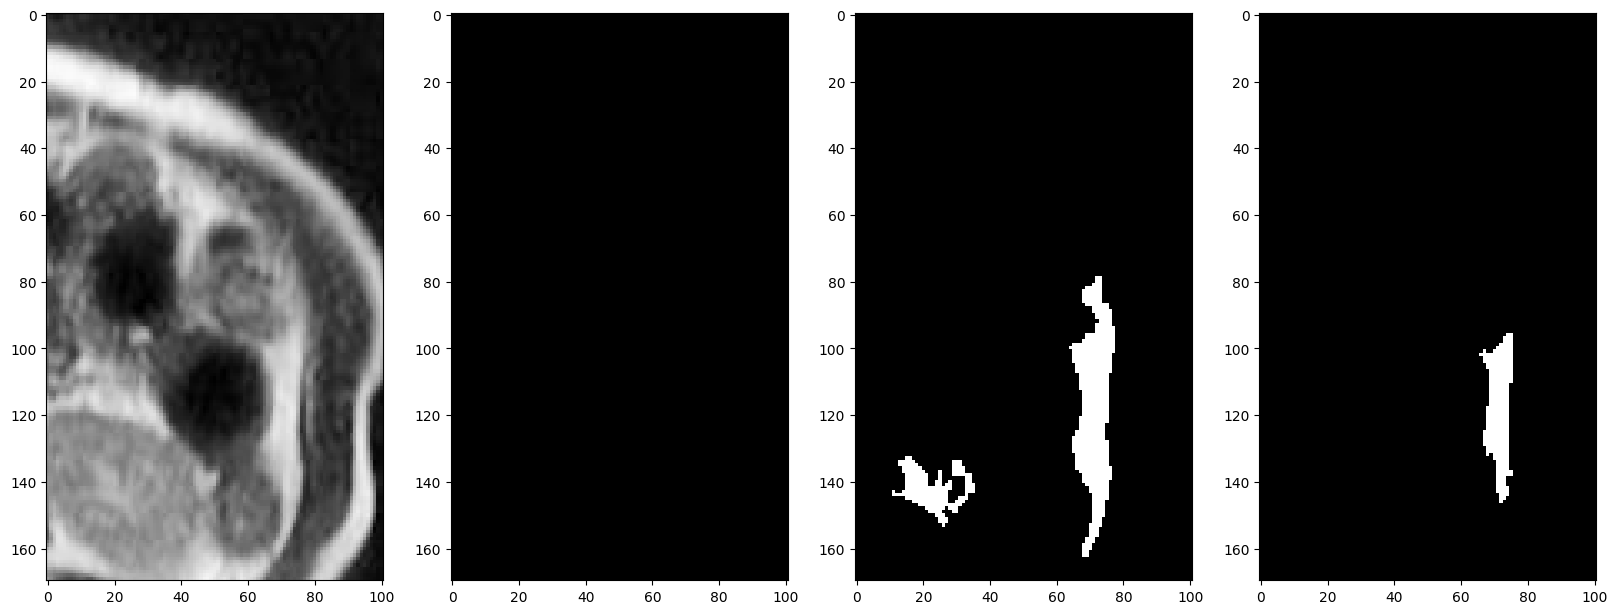

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 0.0

Fuzzy time for cluster 3
Bwarea : 187.75

Fuzzy time for cluster 6
Bwarea : 691.5

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


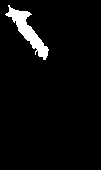

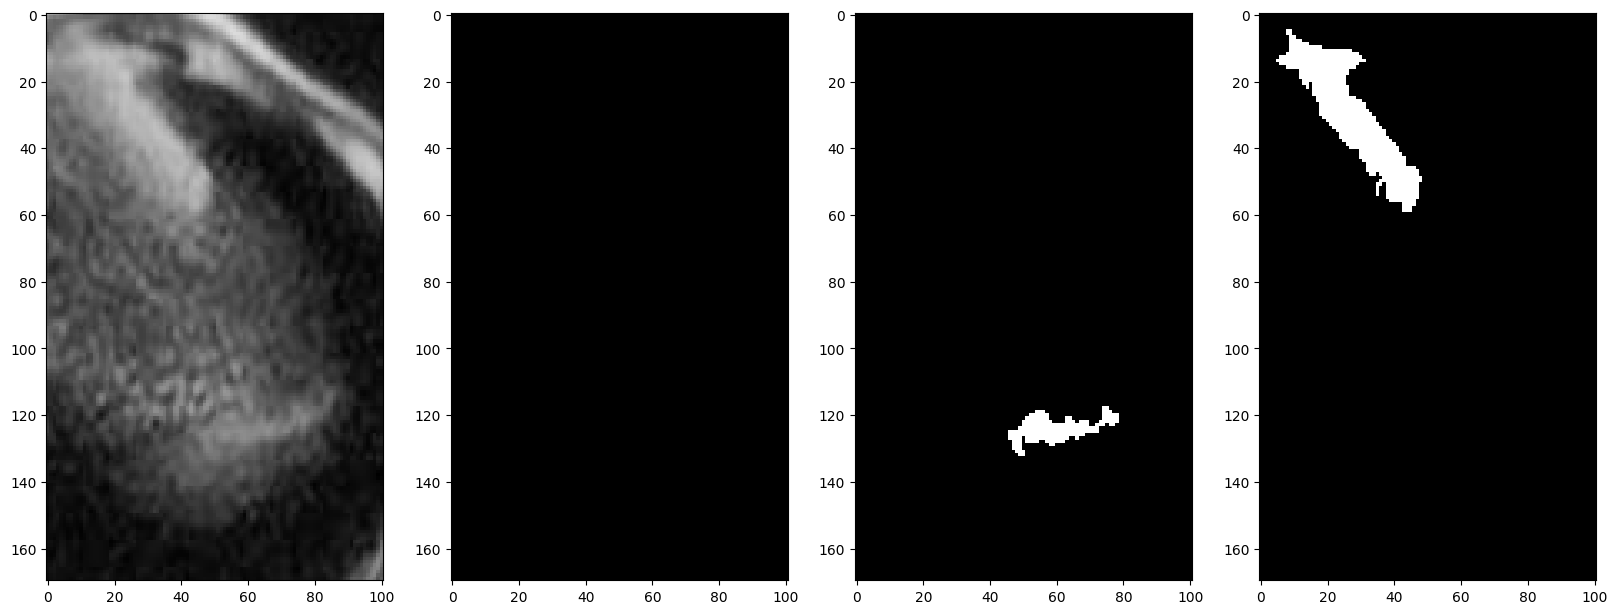

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 0.0

Fuzzy time for cluster 3
Bwarea : 2.0

Fuzzy time for cluster 6
Bwarea : 837.5

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


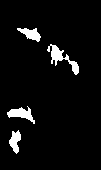

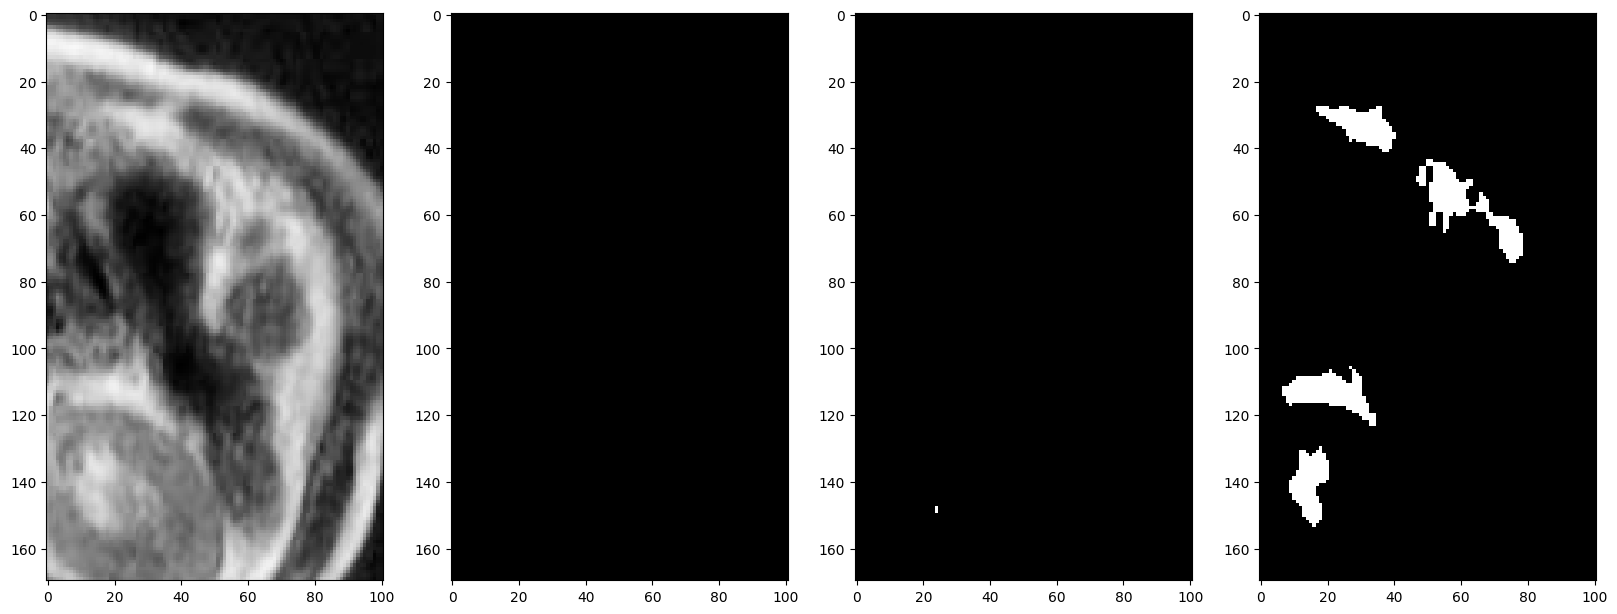

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 2.75

Fuzzy time for cluster 3
Bwarea : 2278.75

Fuzzy time for cluster 6
Bwarea : 1004.0

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


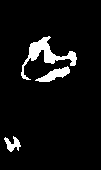

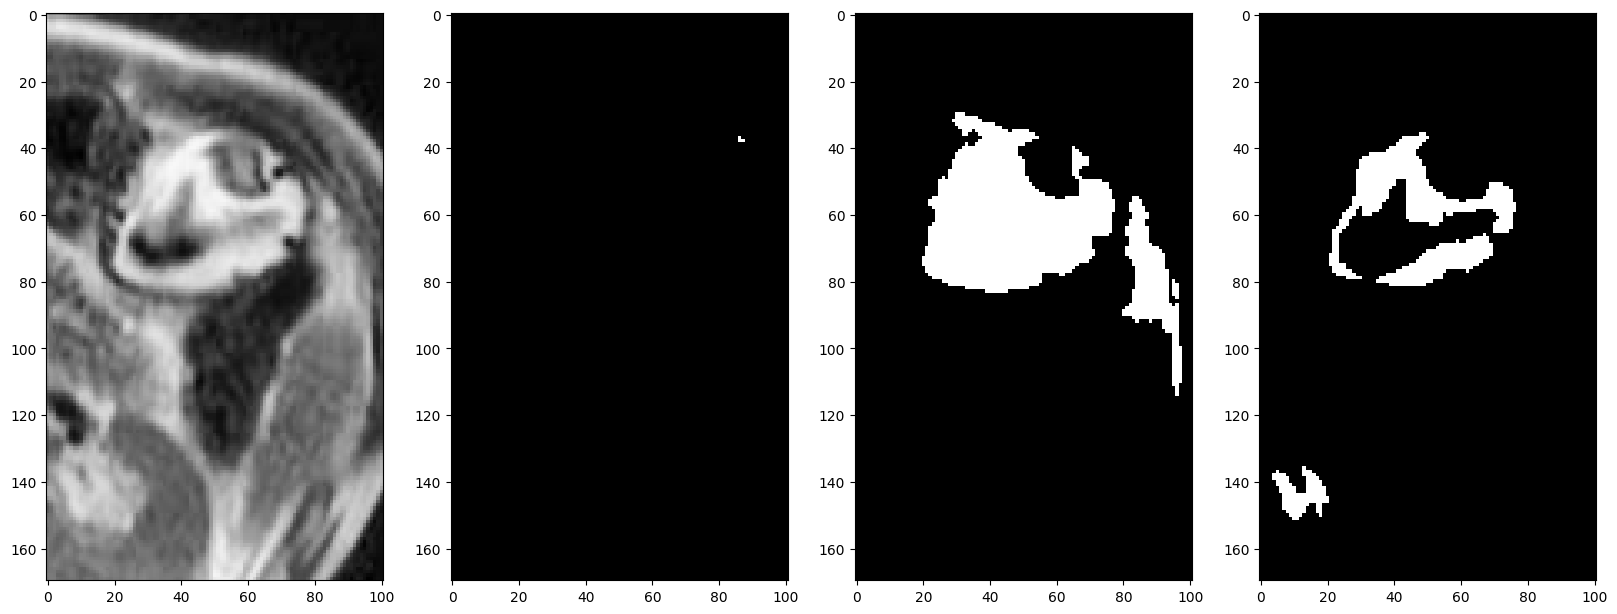

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 0.0

Fuzzy time for cluster 3
Bwarea : 658.5

Fuzzy time for cluster 6
Bwarea : 206.75

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


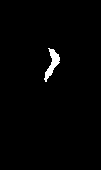

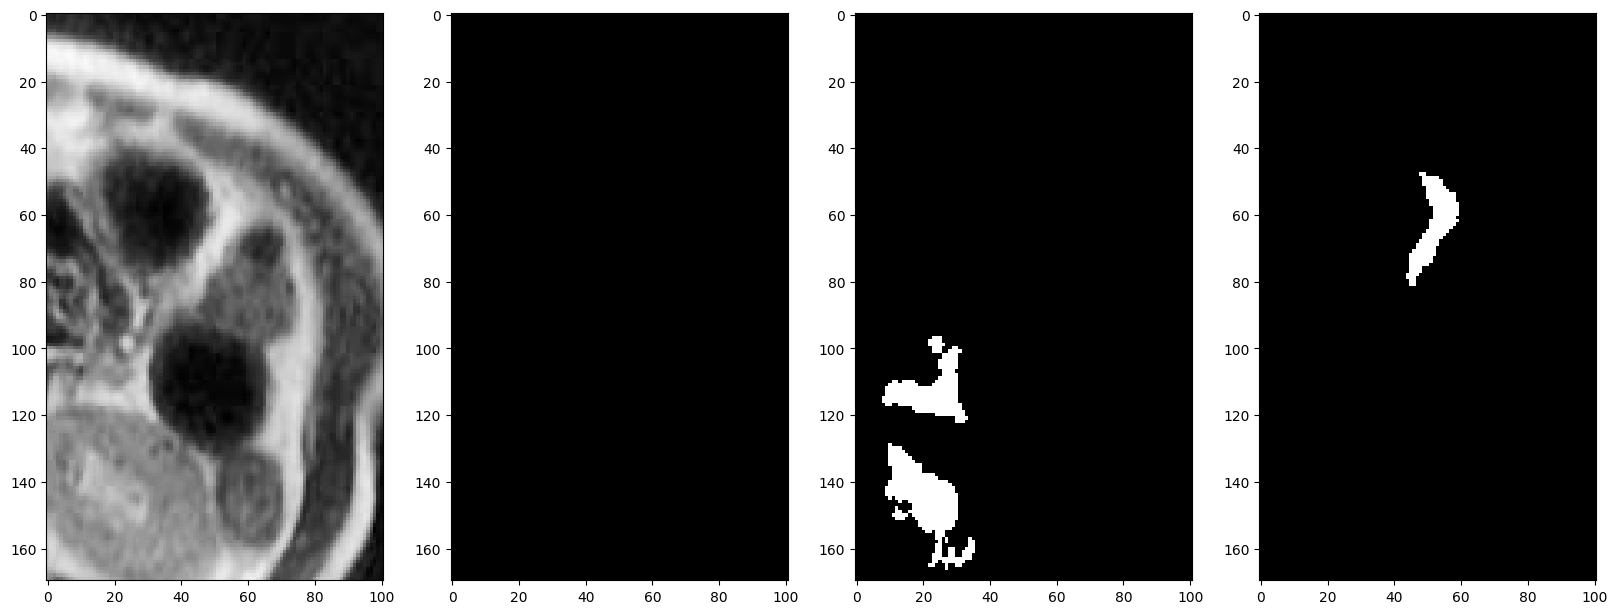

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 7.75

Fuzzy time for cluster 3
Bwarea : 1010.0

Fuzzy time for cluster 6
Bwarea : 461.0

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


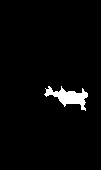

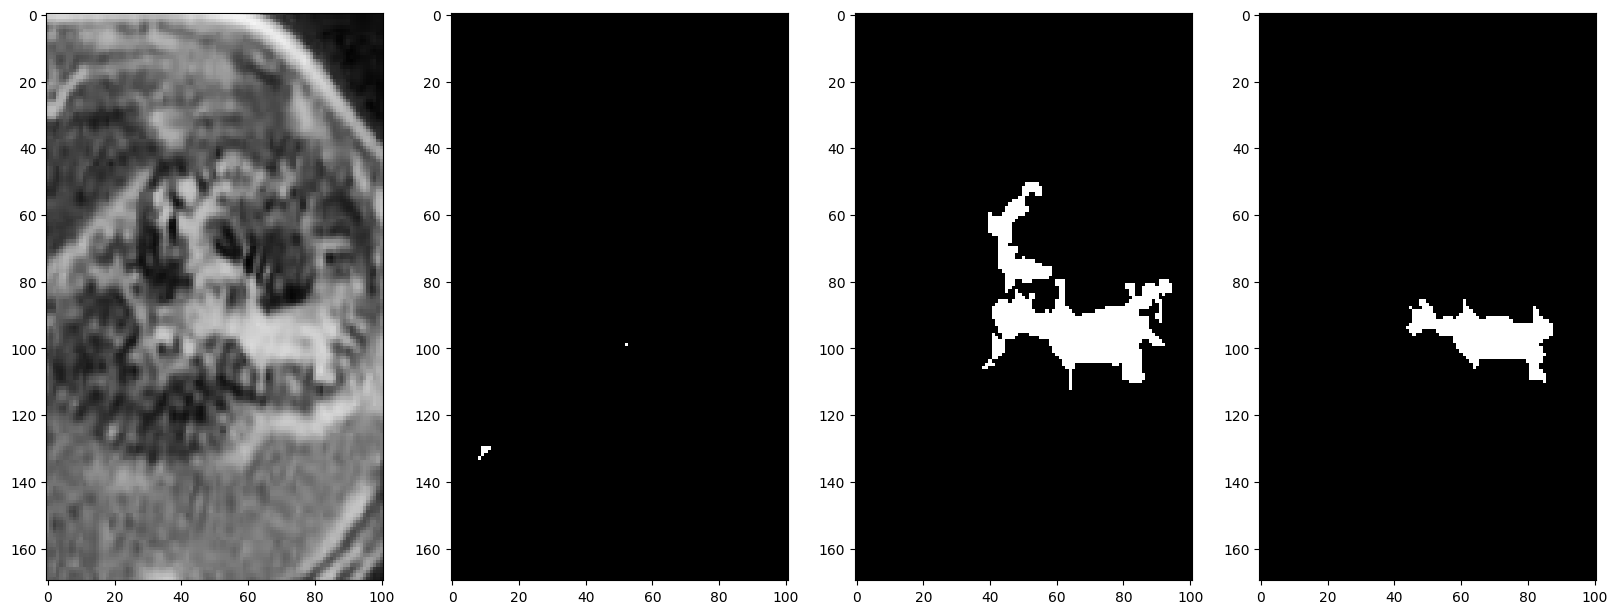

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 579.5

Fuzzy time for cluster 3
Bwarea : 314.25

Fuzzy time for cluster 6
Bwarea : 398.75

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


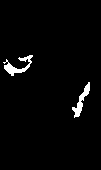

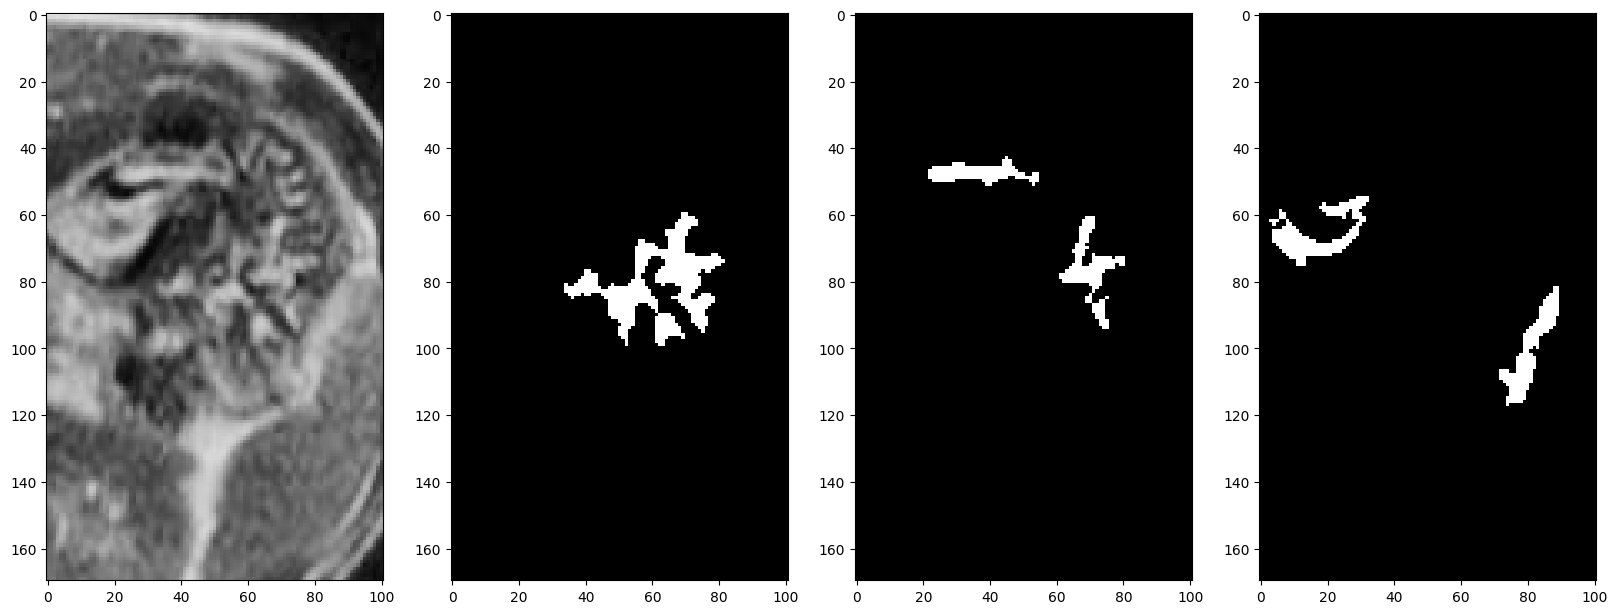

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 2432.75

Fuzzy time for cluster 3
Bwarea : 1432.5

Fuzzy time for cluster 6
Bwarea : 604.0

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


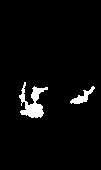

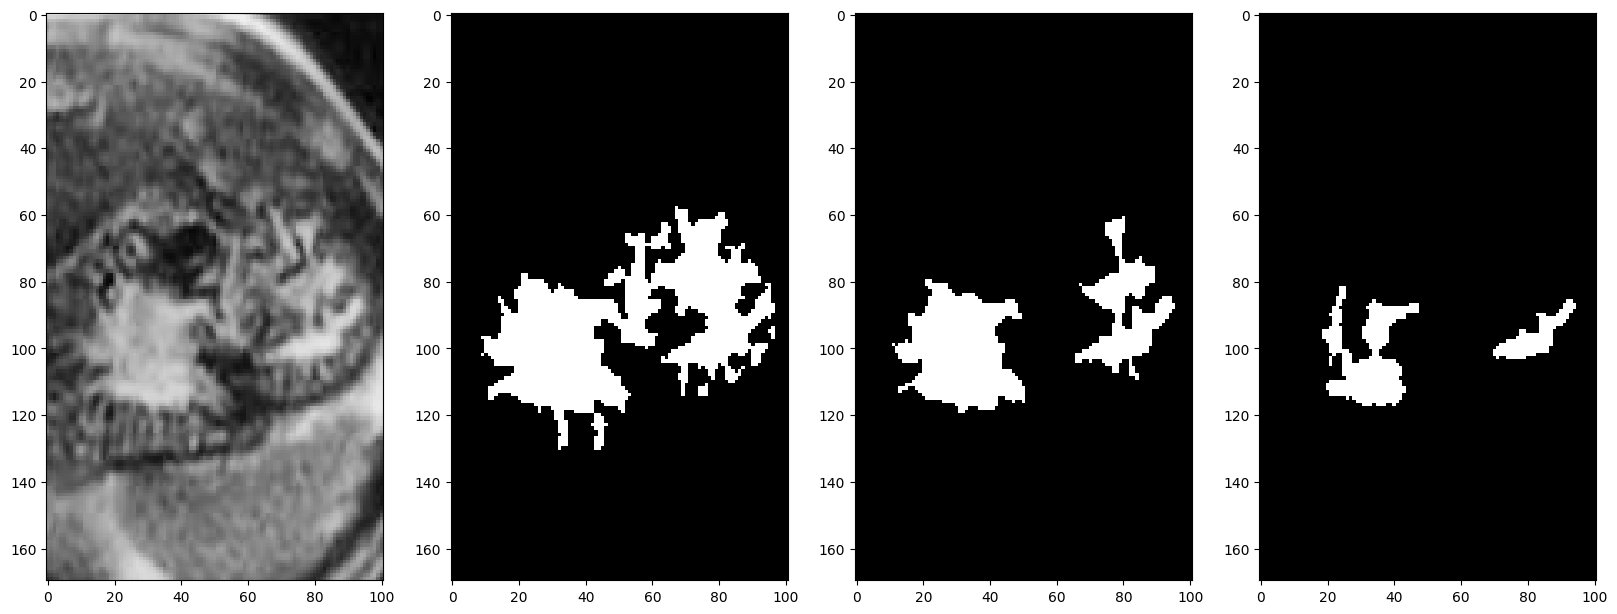

786432
(17170, 3)
Fuzzy time for cluster 2
Bwarea : 0.0

Fuzzy time for cluster 3
Bwarea : 1452.75

Fuzzy time for cluster 6
Bwarea : 550.0

BWFM3 :(170, 101) Image: (170, 101)
(170, 101)


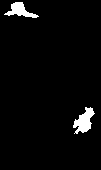

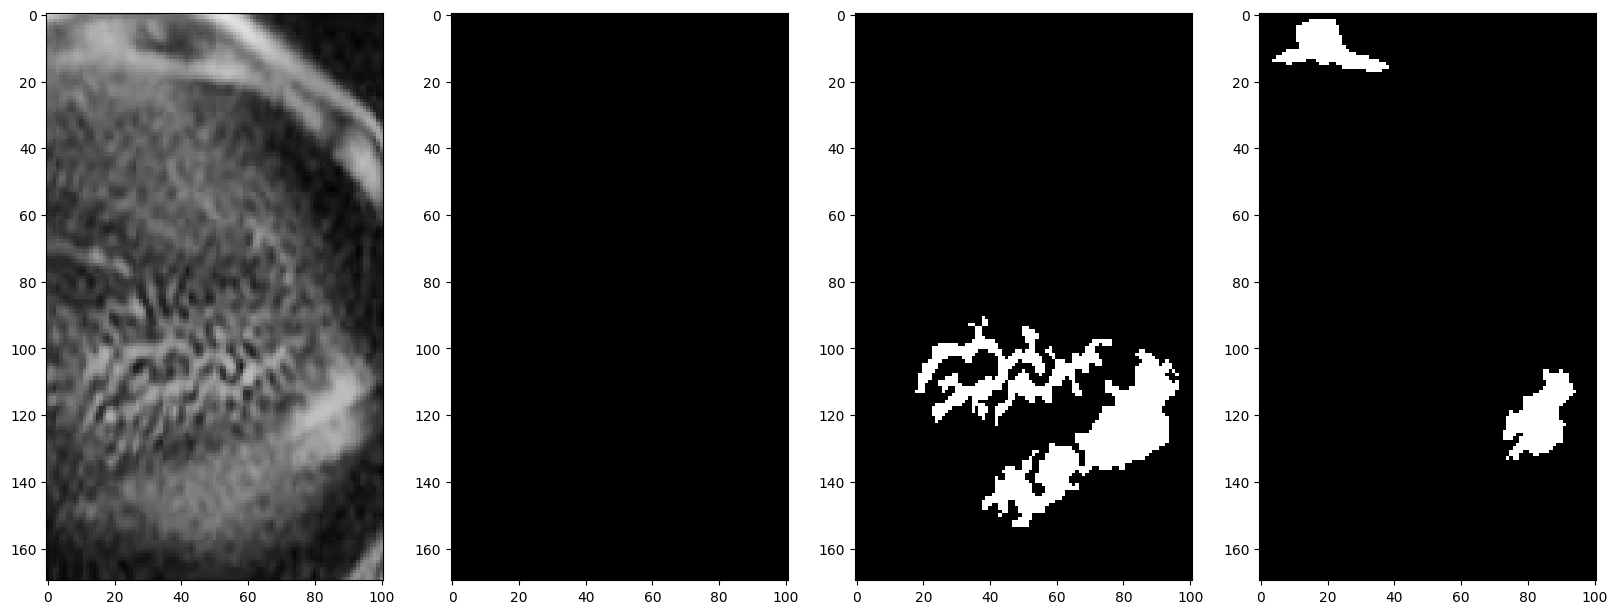

In [ ]:
directory = '/content/preprocess_output/processed_img'
i = 0
for filename in os.listdir(directory):
    if  filename.endswith(".jpg") or filename.endswith(".png"):
        img1 = np.array(cv2.imread(os.path.join(directory, filename)), dtype=int)
        print(img1.size)
        i += 1
        # img = np.array(img,dtype=int)
        # crop_img = img[170:350, 309:410]
        crop_img = img1[170:340, 309:410]
        # ex1 = resize(crop_img, (170, 101),0)
        ex1 = np.array(crop_img, dtype=np.uint8)
        ex1.shape
        img_gray1 = cv2.cvtColor(ex1, cv2.COLOR_BGR2GRAY)
        # print(f'Image Grey:{np.size(img_gray1)}')
        FCMeans(img_gray1, i, 1)
    else:
        continue

586092
(8100, 3)
Fuzzy time for cluster 2
Bwarea : 0.0

Fuzzy time for cluster 3
Bwarea : 0.0

Fuzzy time for cluster 6
Bwarea : 0.0

BWFM3 :(100, 81) Image: (100, 81)
(100, 81)


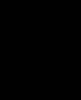

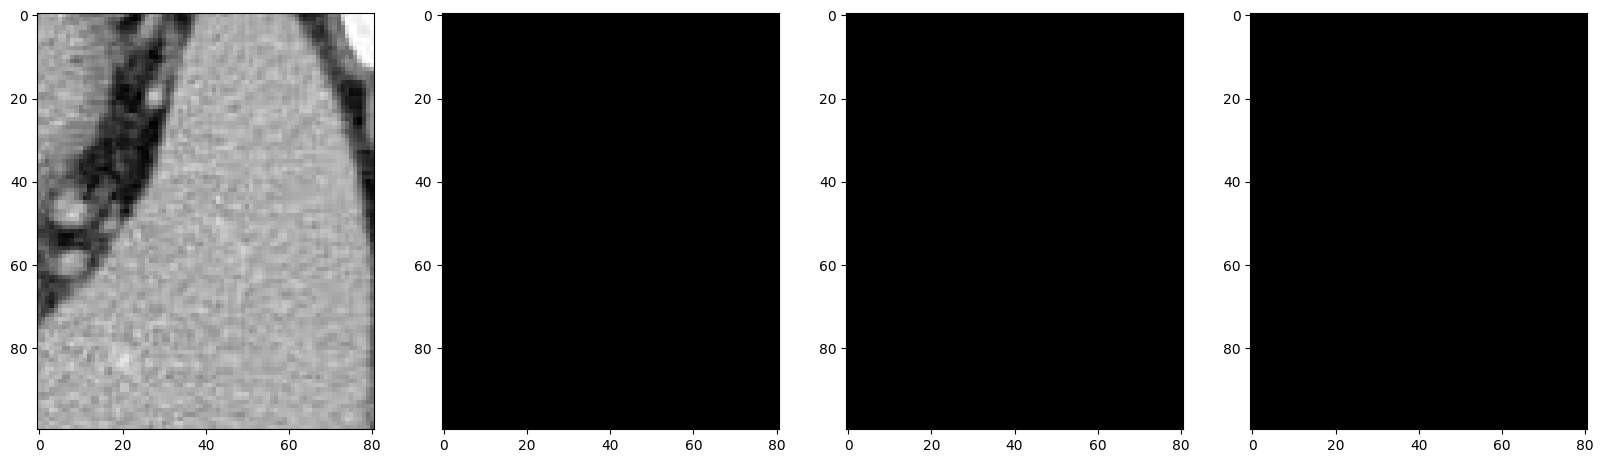

586092
(8100, 3)
Fuzzy time for cluster 2
Bwarea : 2.0

Fuzzy time for cluster 3
Bwarea : 0.0

Fuzzy time for cluster 6
Bwarea : 0.0

BWFM3 :(100, 81) Image: (100, 81)
(100, 81)


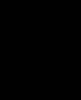

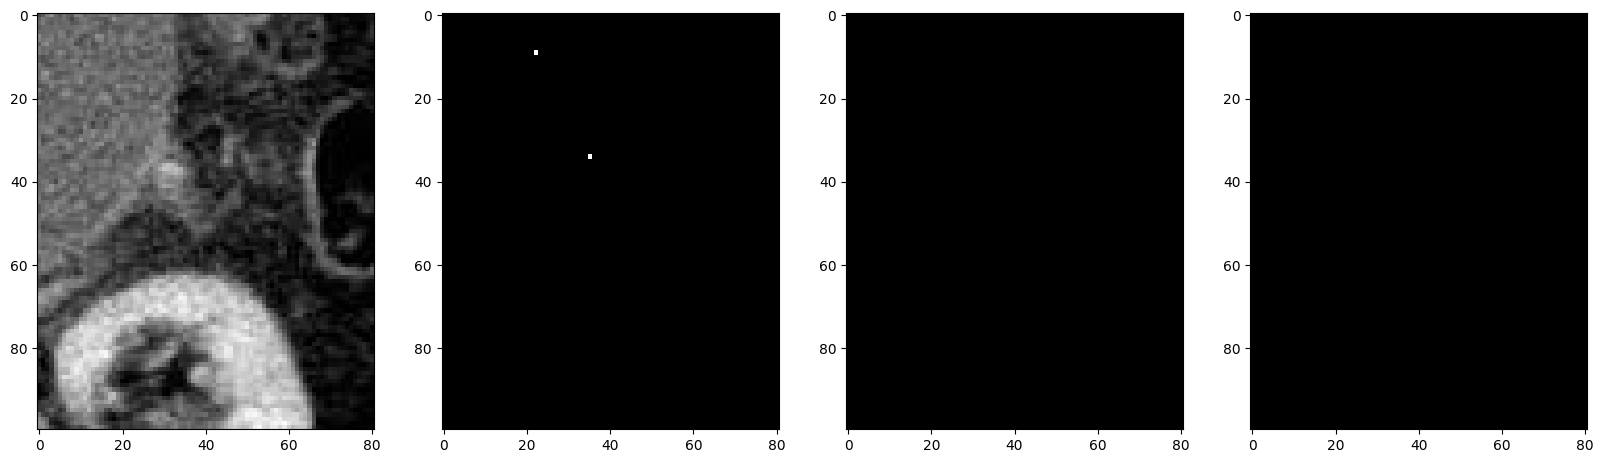

586092
(8100, 3)
Fuzzy time for cluster 2
Bwarea : 85.75

Fuzzy time for cluster 3
Bwarea : 0.0

Fuzzy time for cluster 6
Bwarea : 194.5

BWFM3 :(100, 81) Image: (100, 81)
(100, 81)


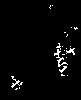

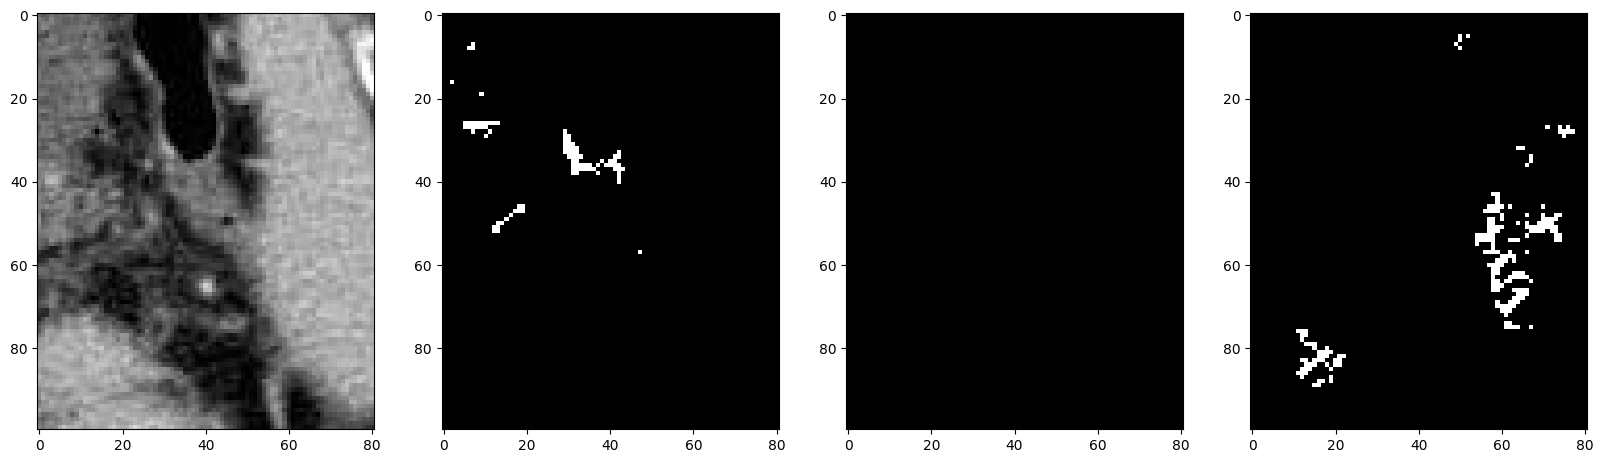

863730
(8100, 3)
Fuzzy time for cluster 2
Bwarea : 0.0

Fuzzy time for cluster 3
Bwarea : 0.0

Fuzzy time for cluster 6
Bwarea : 0.0

BWFM3 :(100, 81) Image: (100, 81)
(100, 81)


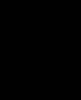

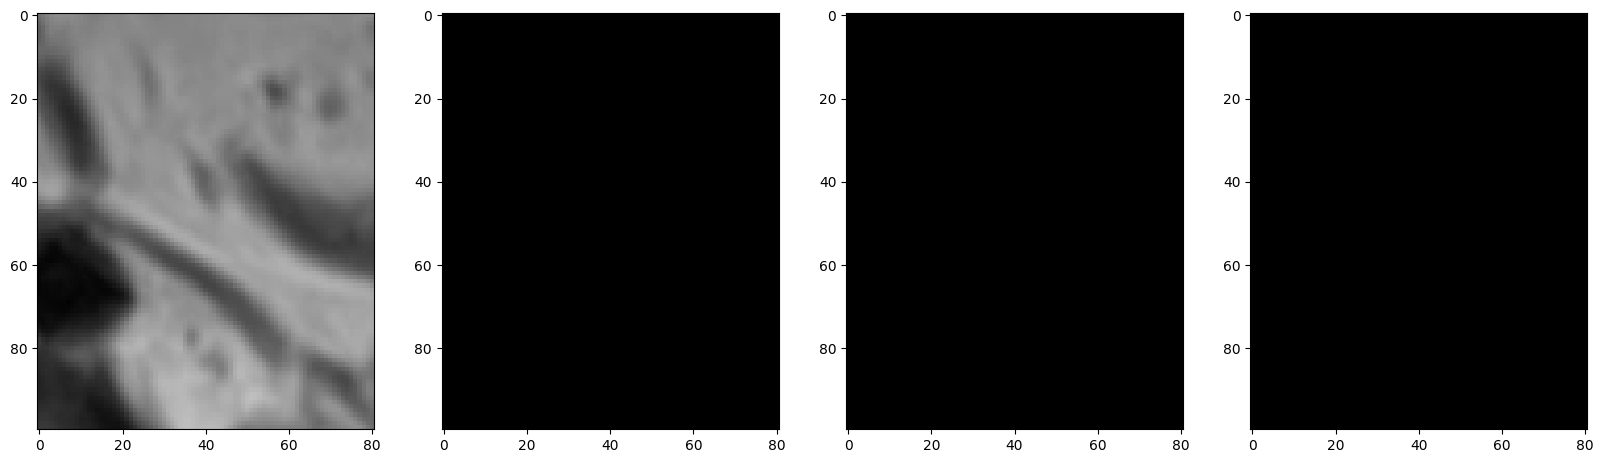

In [ ]:
directory = '/content/healthy'
i = 0
for filename in os.listdir(directory):
    if  filename.endswith(".jpg") or filename.endswith(".png"):
        img1 = np.array(cv2.imread(os.path.join(directory, filename)), dtype=int)
        print(img1.size)
        i += 1
        # img = np.array(img,dtype=int)
        # crop_img = img[170:350, 309:410]
        crop_img = img1[200:300, 309:390]
        # ex1 = resize(crop_img, (170, 101),0)
        ex1 = np.array(crop_img, dtype=np.uint8)
        ex1.shape
        img_gray1 = cv2.cvtColor(ex1, cv2.COLOR_BGR2GRAY)
        # print(f'Image Grey:{np.size(img_gray1)}')
        FCMeans(img_gray1, i, 0)
    else:
        continue

## K-Means

In [ ]:
def KMeans1(img, filename, idx):
  A = np.zeros([170,101])
  for i in range(170):
    for j in range(101):
        A[i][j] = img[i][j]


  A.max()

  amax = A.max()
  amin = A.min()
  A = A - amin
  print('amin now')
  print(amin)
  print('amax now')
  print(amax)
  #formula to make values from [amin, amax] --> [0, 255]
  ssize = amax - amin
  amax = A.max()
  amin = A.min()
  # the lenght of each bin to be created for
  # mapping values in the space [0 .. 255]

  bbin = ssize/170;
  bbin

  index = np.zeros([170])

  for i in range(170):
          index[i] = bbin*(i+1)

  index[101]

  F = np.zeros([170,101])
  k = 0

  for i in range(170):

      for j in range(101):
          run = 1
          k = 0
          less = 0
          great = 0
          # print("Testing for [%d %d]" %(i,j))
          while(run == 1):

              #print("Checking: %f  <= %f" %(A[i][j], index[k]))

              if(A[i][j] <= index[k]):

                  if(great == 1):
                      #print("Assign found")
                      F[i][j] = k;
                      #print("Assigned: %d" %(k))
                      run = 0
                      break


                  if(less == 1):
                      #print("Assign found")
                      F[i][j] = k-1;
                      #print("Assigned: %d" %(k-1))
                      run = 0
                      break

                  k = k+1
                  less = 1
                  #print("Less = 1")
              else:
                  #print("Greater")
                  great = 1
                  k = k+1
              if(k == 101):
                  F[i][j] = 101
                  break;
        # created F array with values


  F

  # creation of a colormap (PseudoColorTranslation)
  # and also creation of 3 different new arrays.(R, G, B) based on the choosen colormap.
  from colorsys import hsv_to_rgb

  def pseudocolor(val, minval, maxval):

      h = (float(val-minval) / (maxval-minval)) * 101

      # Convert hsv color (h,1,1) to its rgb equivalent.
      # Note: hsv_to_rgb() function expects h to be in the range 0..1 not 0..360
      r, g, b = hsv_to_rgb(h/101, 1., 1.)
      return r, g, b

  pseudocolor(23,0,101)
  R = np.zeros([170,101])
  G = np.zeros([170,101])
  B = np.zeros([170,101])

  for i in range(170):
      for j in range(101):
          R[i][j], G[i][j], B[i][j] = pseudocolor(F[i][j],0,255)



  # Next process is the Color Space Translation (CST)
  L = np.zeros([170,101]) #luminocity
  a = np.zeros([170,101]) #a and
  b = np.zeros([170,101]) #b according to paper.

  import math

  # diff function used in the calculation
  # of a number's the cubic root.
  def diff(n, mid) :
      if (n > (mid * mid * mid)) :
          return (n - (mid * mid * mid))
      else :
          return ((mid * mid * mid) - n)

  # Returns cube root of a no n
  def cubicRoot(n) :

      # Set start and end for binary
      # search
      start = 0
      end = n

      times = 0

      # Set precision
      e = 0.0000001

      while (True) :
          #print('again') #dbg

          times = times + 1

          mid = (start + end) / 2
          error = diff(n, mid)

          if(times > 10):
              return mid
          # If error is less than e
          # then mid is our answer
          # so return mid
          if (error == e) :
              return mid
          if(error < e):
              return mid

          # If mid*mid*mid is greater
          # than n set end = mid
          if ((mid * mid * mid) > n) :
              end = mid

          # If mid*mid*mid is less
          # than n set start = mid
          else :
              start = mid

  # H function as defined in the paper.
  def h(x):

      if(x>0.008856):
          return cubicRoot(x)
      else:
          return ( (7.787*x) + 16/116)

  # Ys, Zs, Ws standard stimulus coefficients.
  #D65 used as found in Wikipedia.
  Ys = 100;
  #Zs = 108.8840;
  Zs = 82.5188; # D50
  Ws = 95.0489;

  for i in range(170):
  #    print("row: %d" %(i)) #dbg

      for j in range(101):
          #print("col: %d" %(j)) #dbg
          W = 0.4304*R[i][j] + 0.3416*G[i][j] + 0.1784*B[i][j]
          Y = 0.2219*R[i][j] + 0.7068*G[i][j] + 0.0713*B[i][j]
          Z = 0.0202*R[i][j] + 0.1296*G[i][j] + 0.9393*B[i][j]
          L[i][j] = 116* h(Y/Ys) - 16;
          a[i][j] = 500*h(W/Ws) - h(Y/Ys)
          b[i][j] = 200*h(Y/Ys)- h(Z/Zs)



  # Next process is the K-means clustering of the *a *b planes
  K = np.zeros([170*101,2])
  idx = 0

  for i in range(170):
      for j in range(101):
          K[idx][0]= b[i][j]
          K[idx][1]= a[i][j]
          idx = idx + 1
  #array K holds value to be fed in the k-means algorithm.

  from sklearn.cluster import KMeans
  cl_n = 10
  kmeans = KMeans(n_clusters= cl_n, random_state=0).fit(K)
  # 3 clusters selected according to the authors in the proposed paper.
  Labels = kmeans.labels_
  Labels = Labels.reshape(170,101)
  #plt.subplot(1,cl_n+1,1)

  desimg = np.zeros([170,101])


  for k in range(cl_n):
      blanktestimg = np.zeros([170,101])
      for i in range(170):
          for j in range(101):
              if (Labels[i][j] == k) :
                  blanktestimg[i][j] = 1
                  if(k==9):
                      desimg[i][j] = F[i][j]

      plt.subplot(1,cl_n+1,k+1)
      plt.imshow(blanktestimg, cmap = plt.cm.gray)
      plt.title('Cluster %d' %(k))


  plt.subplot(1,cl_n+1,cl_n+1)
  plt.imshow(Labels,cmap = plt.cm.afmhot)
  plt.rcParams['figure.figsize'] = [30,10]
  plt.title('Clustering result')
  name = 'K-Means'+str(filename)+'.png'
  # plt.savefig(name)
  plt.show()
  with open('PSNR K-Means.txt','a') as file:
    file.write(filename+"PSNR Value: "+str(PSNR(img,Labels))+'\n'+\
               filename+'MSE Value'+str(mean_squared_error(img,Labels))+'\n'
              )
  # print(f"PSNR: {PSNR(img,Labels)}")
  print("Classification")
  plt.imshow(desimg,cmap = plt.cm.gray)
  plt.rcParams['figure.figsize'] = [30,10]
  plt.title('Desired CLuster')
  plt.show()

  # Next L array should be used for the process of histogram-based clustering.

  # Rescale L in range[0,255 ?]
  lmin = L.min()
  lmax = L.max()
  ldist = lmax - lmin

  Lprocessed = L.copy()

  print(f'L min {lmin} L max:{lmax}')
  if(lmin < 0):
      print("lmin < 0")
      Lprocessed = Lprocessed + (-lmin)
  else:
      print("lmin > 0")
      Lprocessed = Lprocessed + (lmin)

  space_len = Lprocessed.max() - Lprocessed.min()
  diamerisi = space_len/170
  index2 = np.zeros([170])

  # creating the indexes for mapping 0...255 in Lprocessed array correctly.
  for i in range(170):
          index2[i] = diamerisi*(i+1)
          #print(index2[i])

  hist, bin_edges = np.histogram(Lprocessed, bins=170)

  #what is the region we should choose? (for example region of interest??)
  fim = np.zeros([170,101])

  lim_low = 20
  lim_high = 50


  for i in range(170):
      for j in range(101):
          # print(f'Lprocessed[i][j]:{Lprocessed[i][j]}')
          if(Lprocessed[i][j] > lim_low ):
              if(Lprocessed[i][j]< lim_high):
                  fim[i][j] = desimg[i][j]
                  #if(desimg[i][j] == 1):
                  #   fim[i][j] = 255
                  #else:
                 #   fim[i][j] = 0

  # cv2_imshow(fim)
  #segmentation based on pixel coordinates.
  fseg = np.zeros([170,101])

  for i in range(170):
      for j in range(101):
          if(i>20 and i<165 and j > 10  and j < 100):
              fseg[i][j] = fim[i][j]
  # print(f'Fim:{fim}')

  plt.subplot(1,4,1)
  plt.imshow(Labels ,cmap=plt.cm.coolwarm, interpolation='nearest')
  plt.imsave('Classification_'+str(idx)+'.png', Labels)
  plt.title("Classification Results")

  plt.subplot(1,4,2)
  plt.imshow(fim ,cmap=plt.cm.coolwarm, interpolation='nearest')
  plt.title("Tumor area after histogram thresholds")

  plt.subplot(1,4,3)
  plt.imshow(fseg ,cmap=plt.cm.coolwarm, interpolation='nearest')
  plt.title("Segmented tumor area")

  plt.subplot(1,4,4)
  plt.imshow(Lprocessed ,cmap=plt.cm.coolwarm, interpolation='nearest')
  plt.imsave('Lpros_'+str(idx)+'.png', Labels)
  plt.title("Luminocity L mapped in [0-255]")

  # plt.savefig("Classification"+str(filename)+'.png')



  plt.rcParams['figure.figsize'] = [20,160]
  plt.show()


786432
amin now
2.0
amax now
230.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


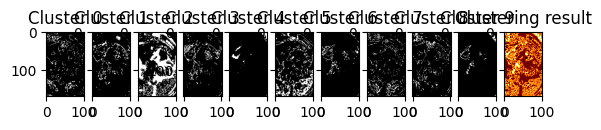

Classification


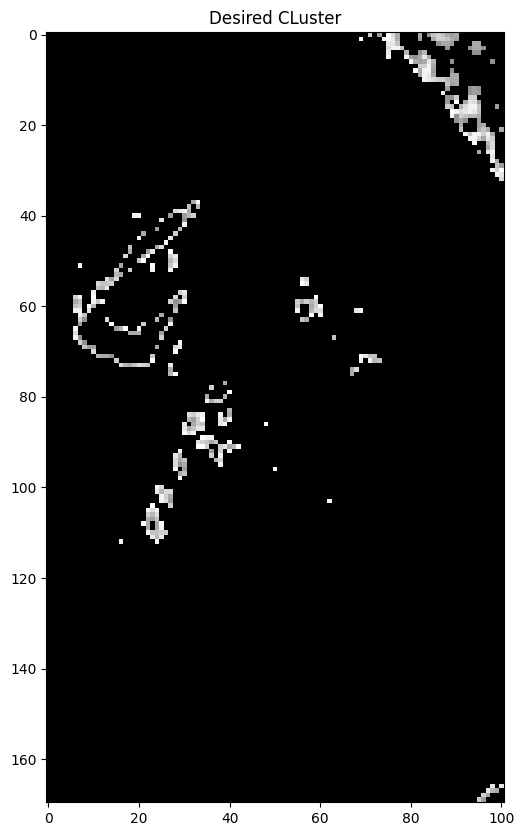

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


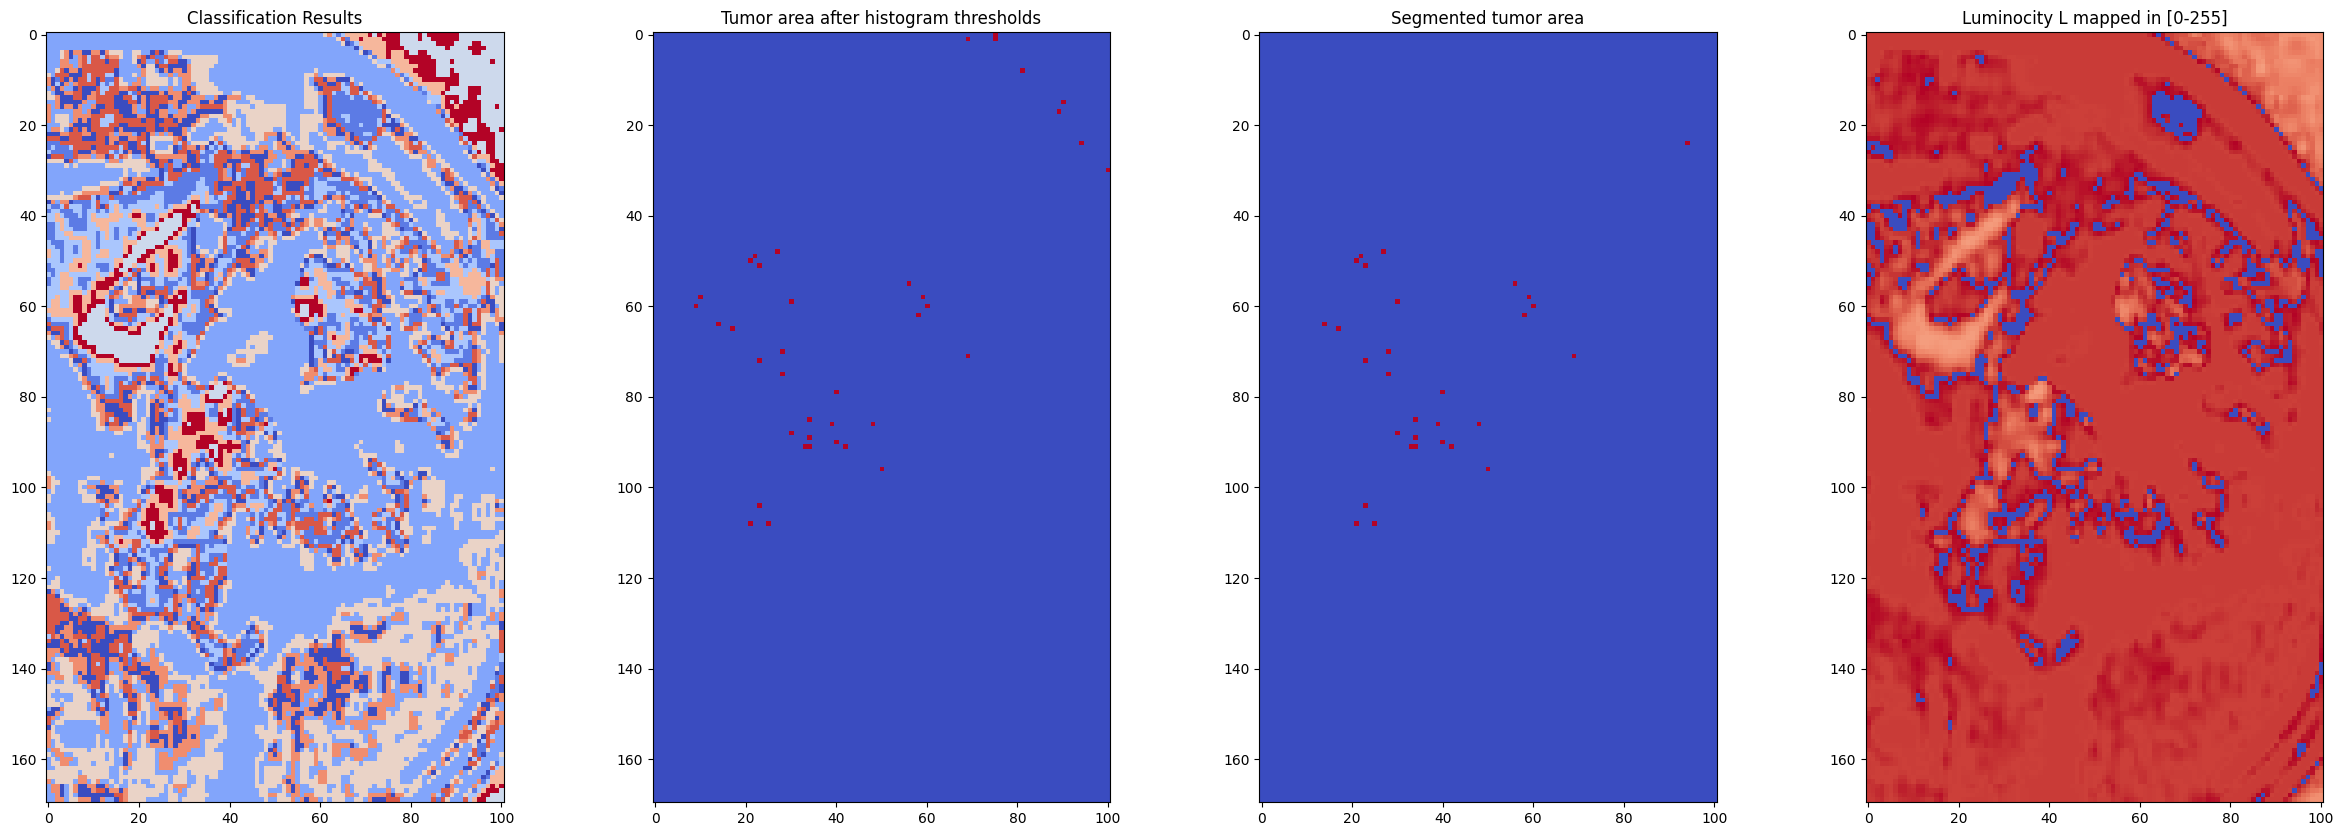

786432
amin now
2.0
amax now
244.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


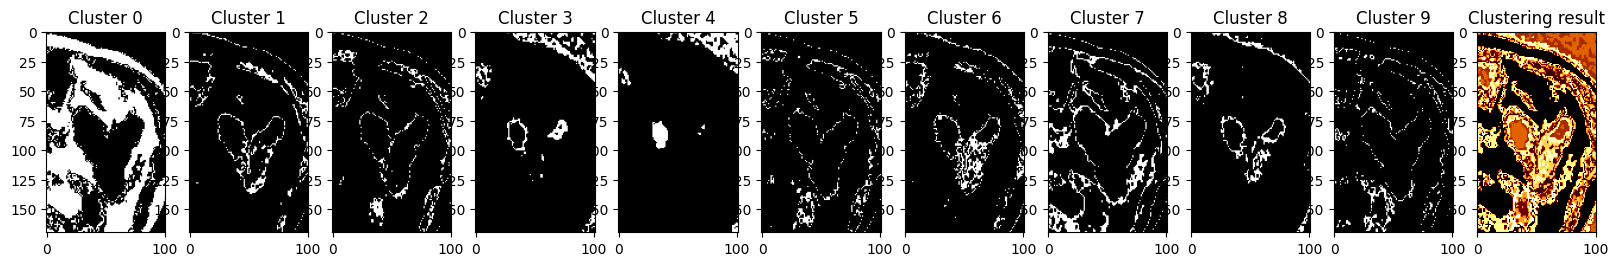

Classification


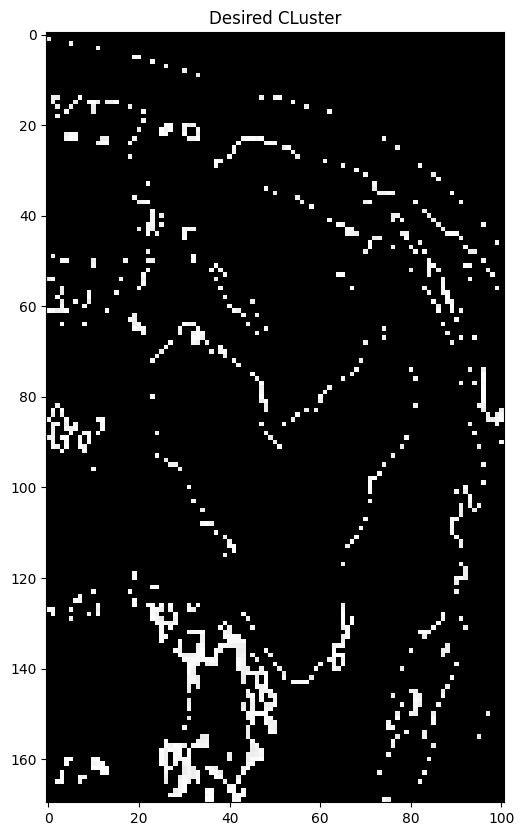

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


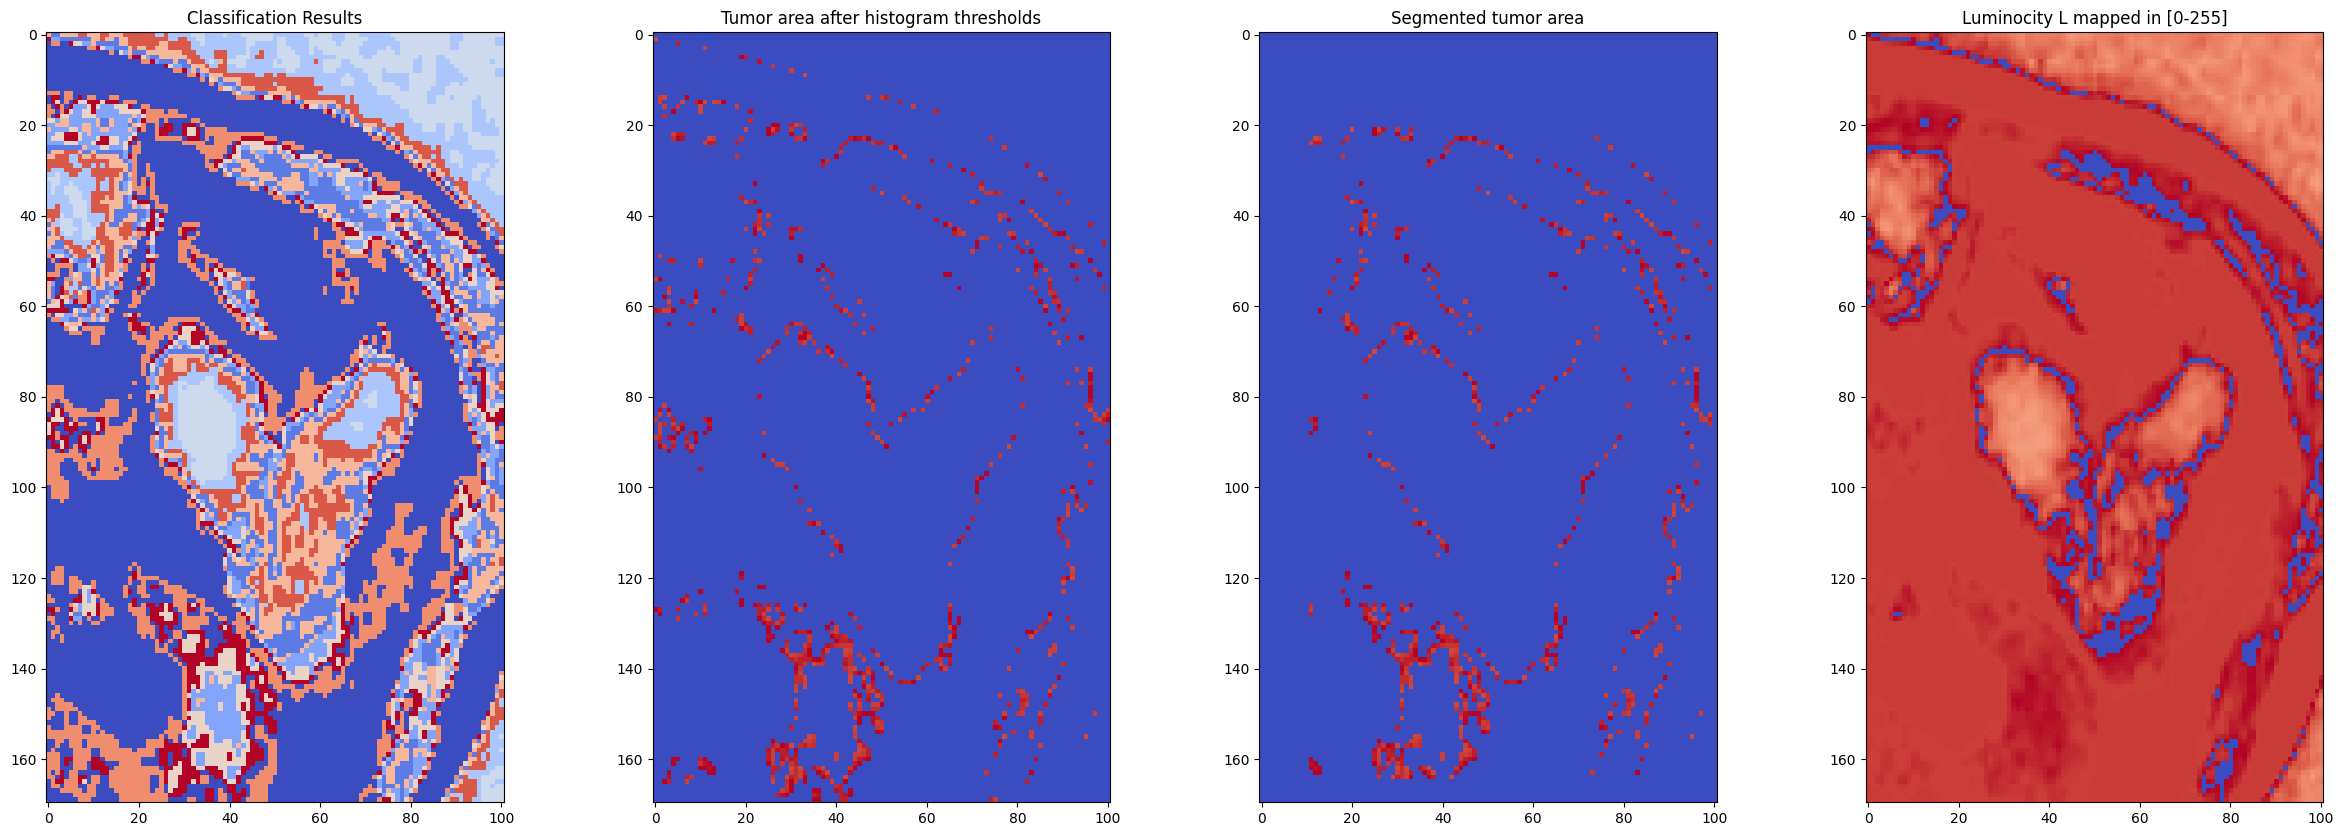

786432
amin now
0.0
amax now
235.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


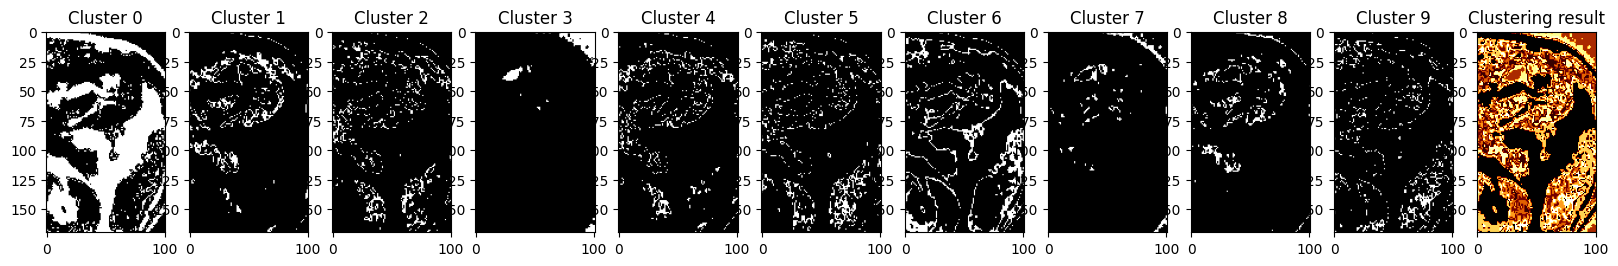

Classification


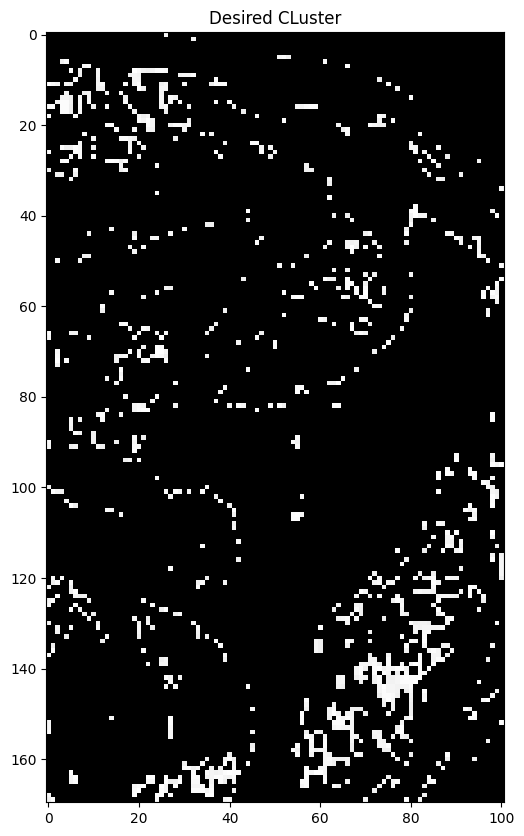

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


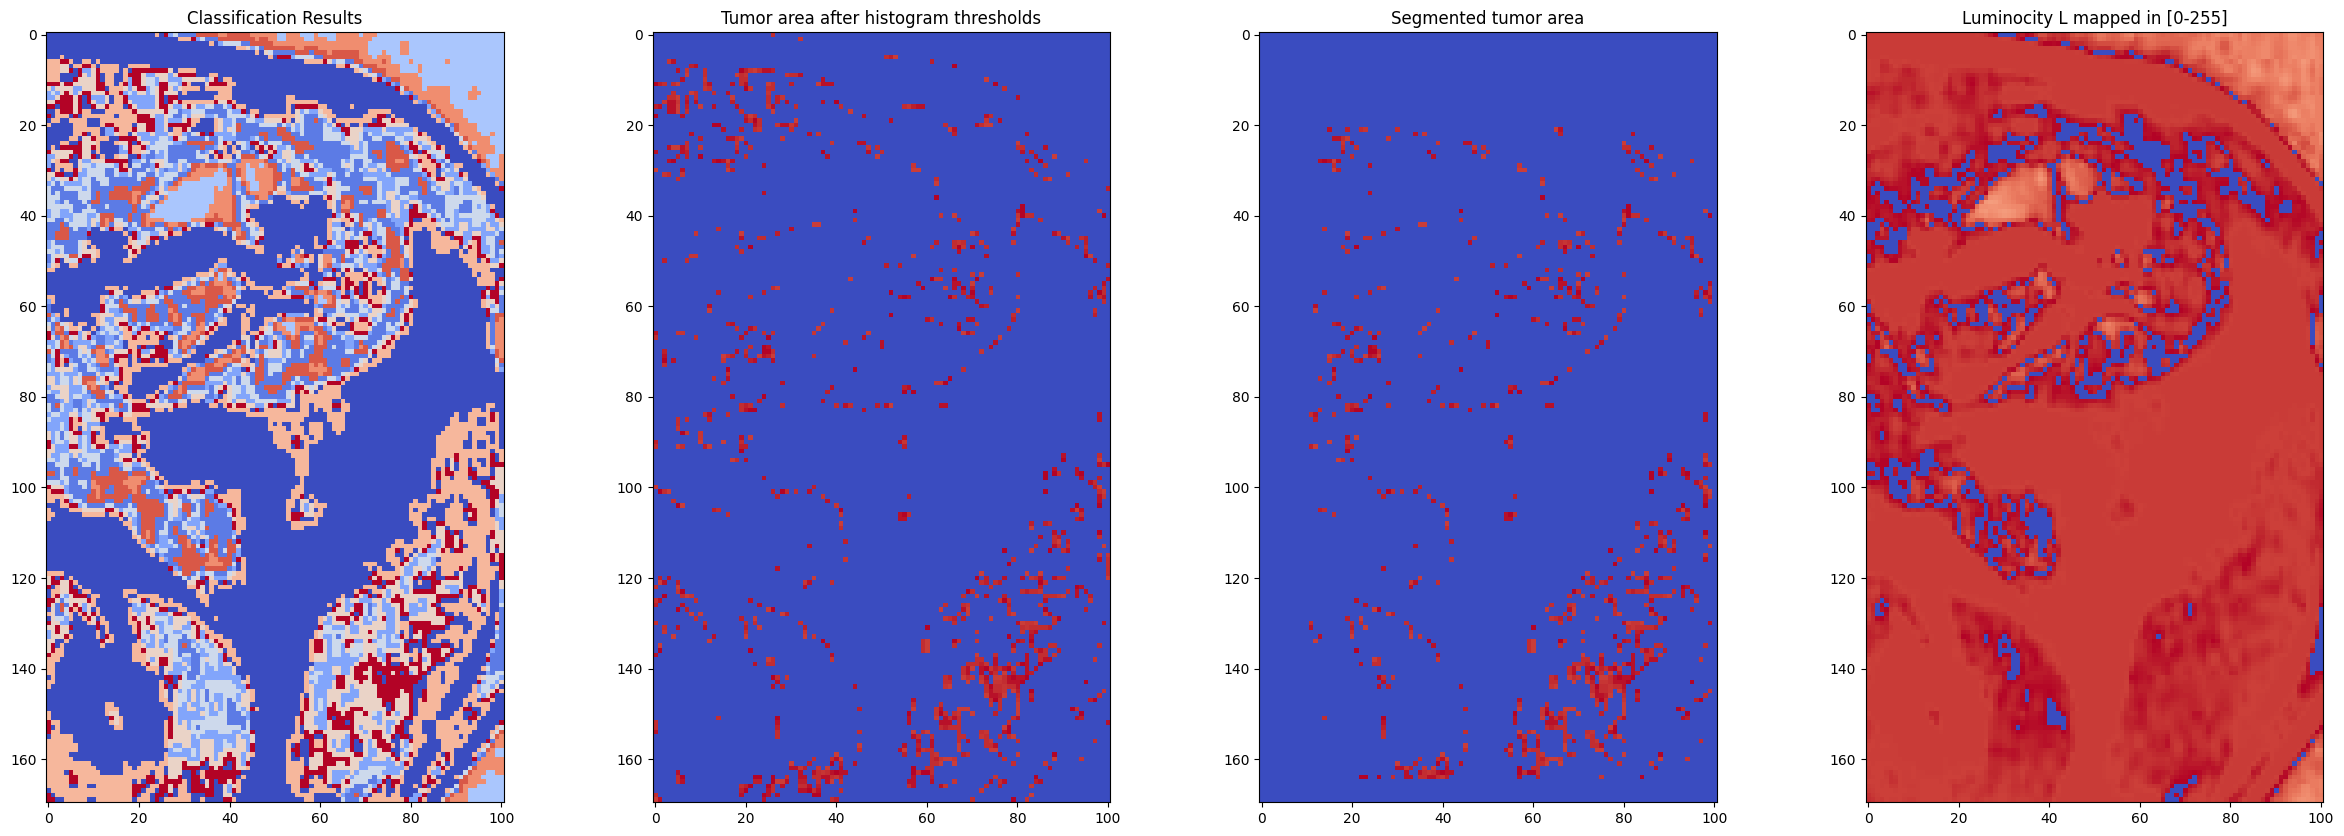

786432
amin now
3.0
amax now
234.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


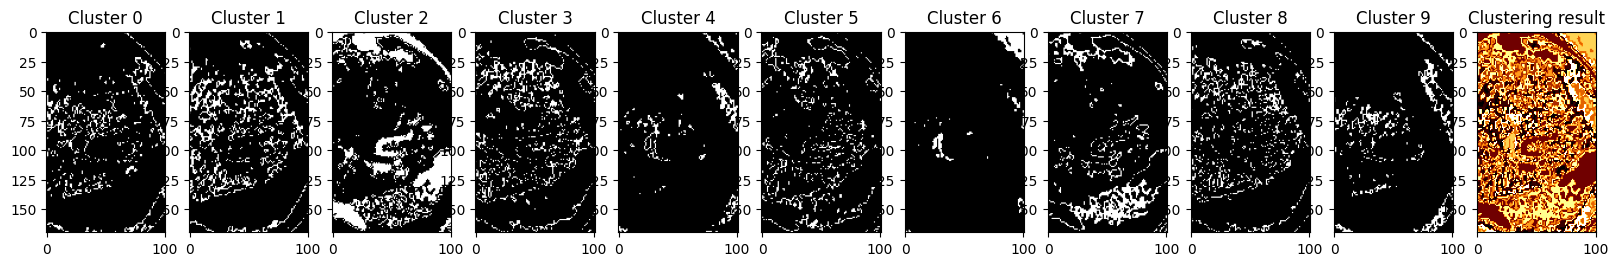

Classification


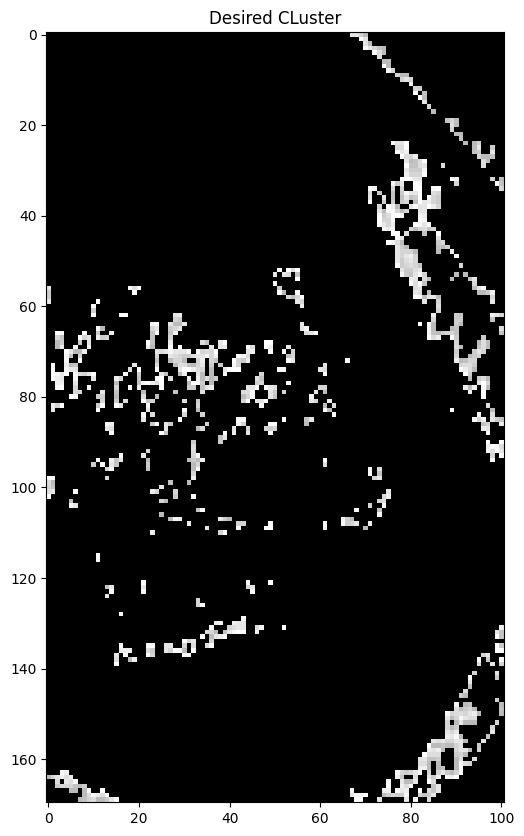

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


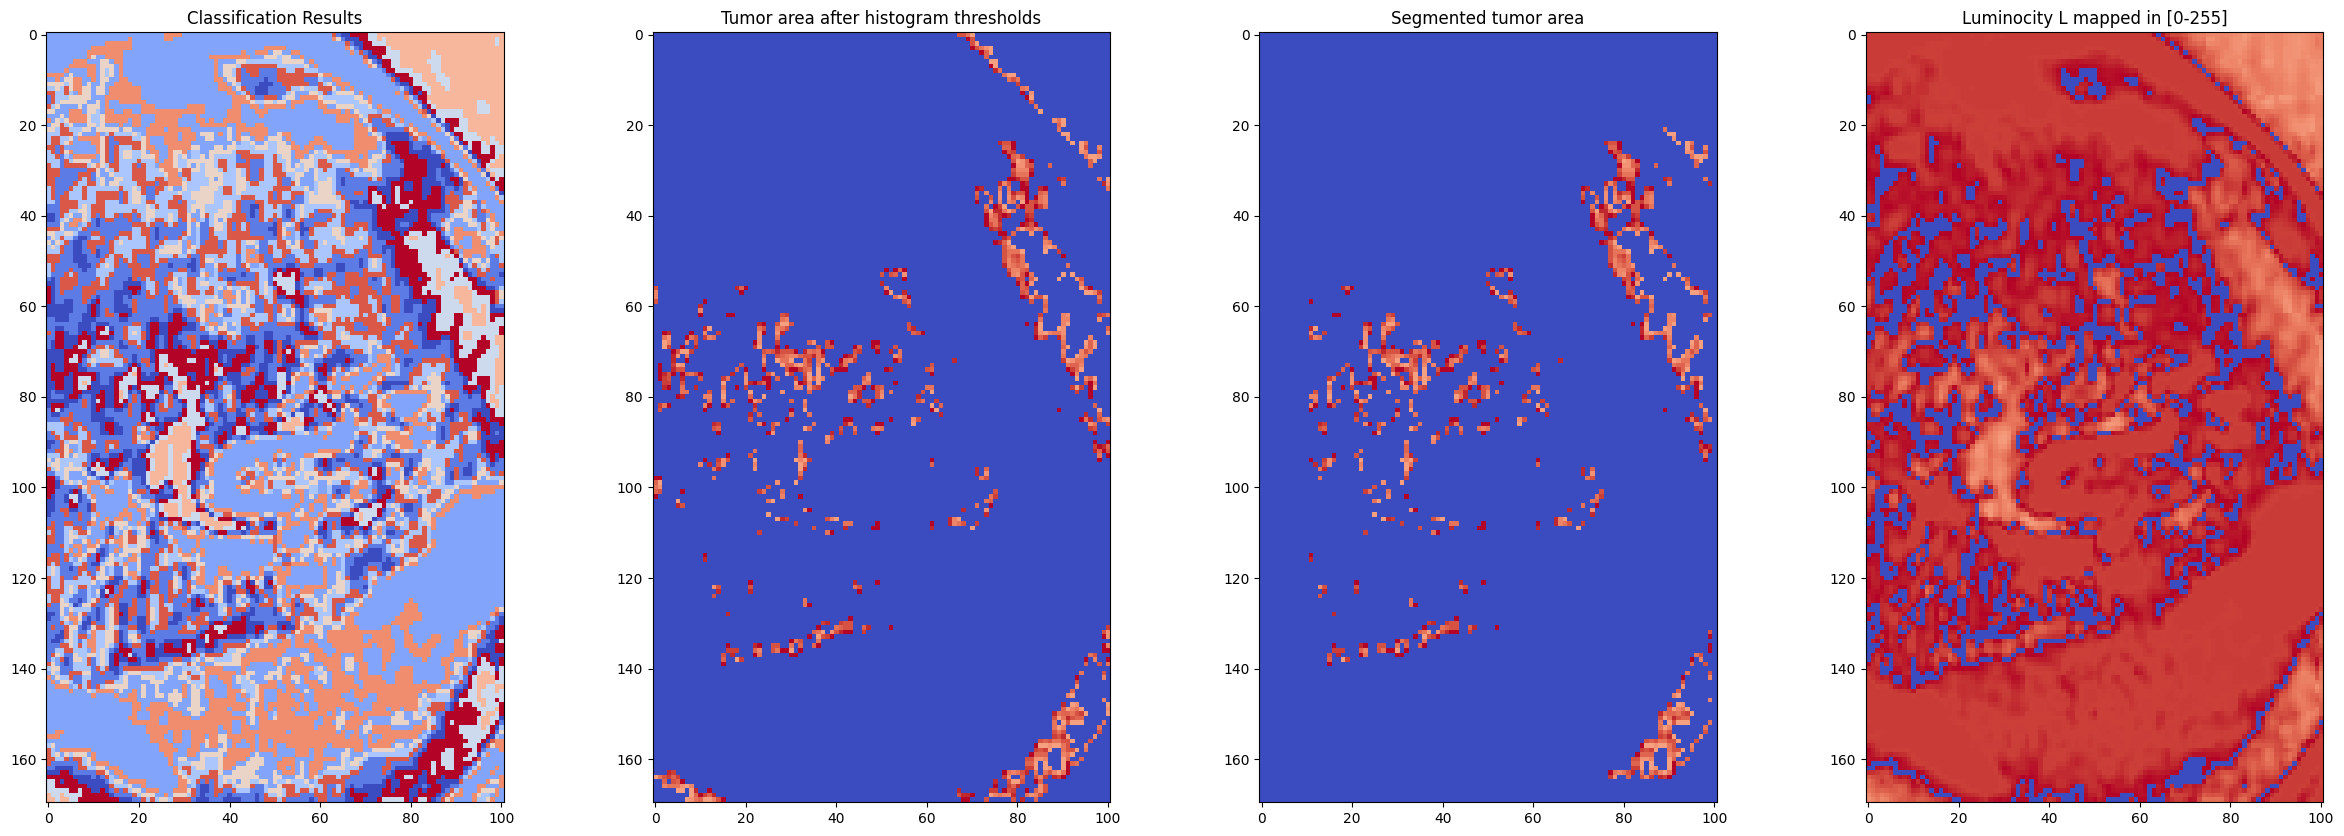

786432
amin now
1.0
amax now
241.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


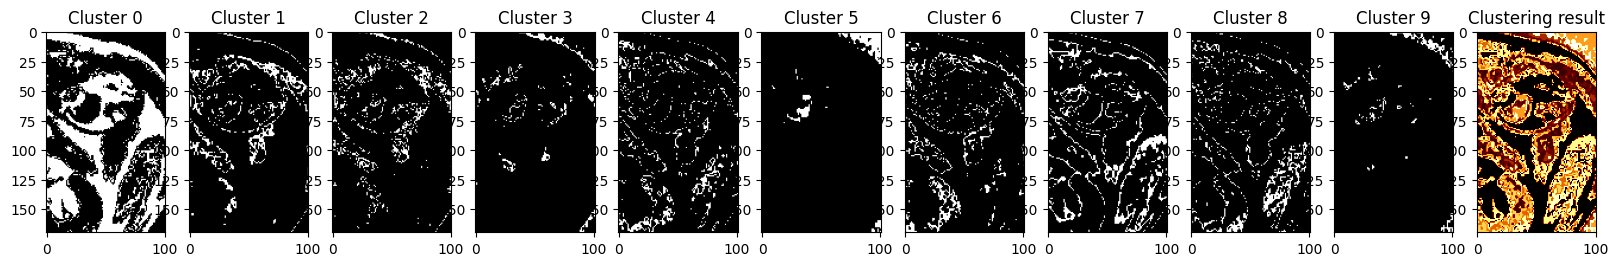

Classification


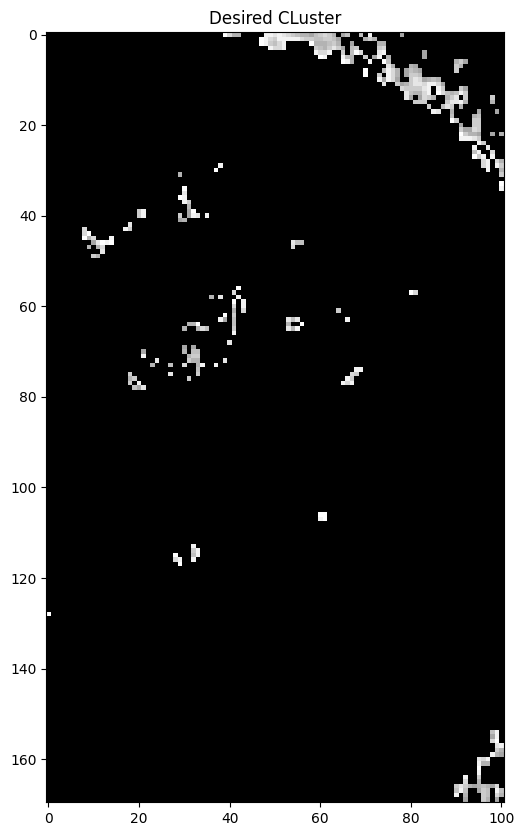

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


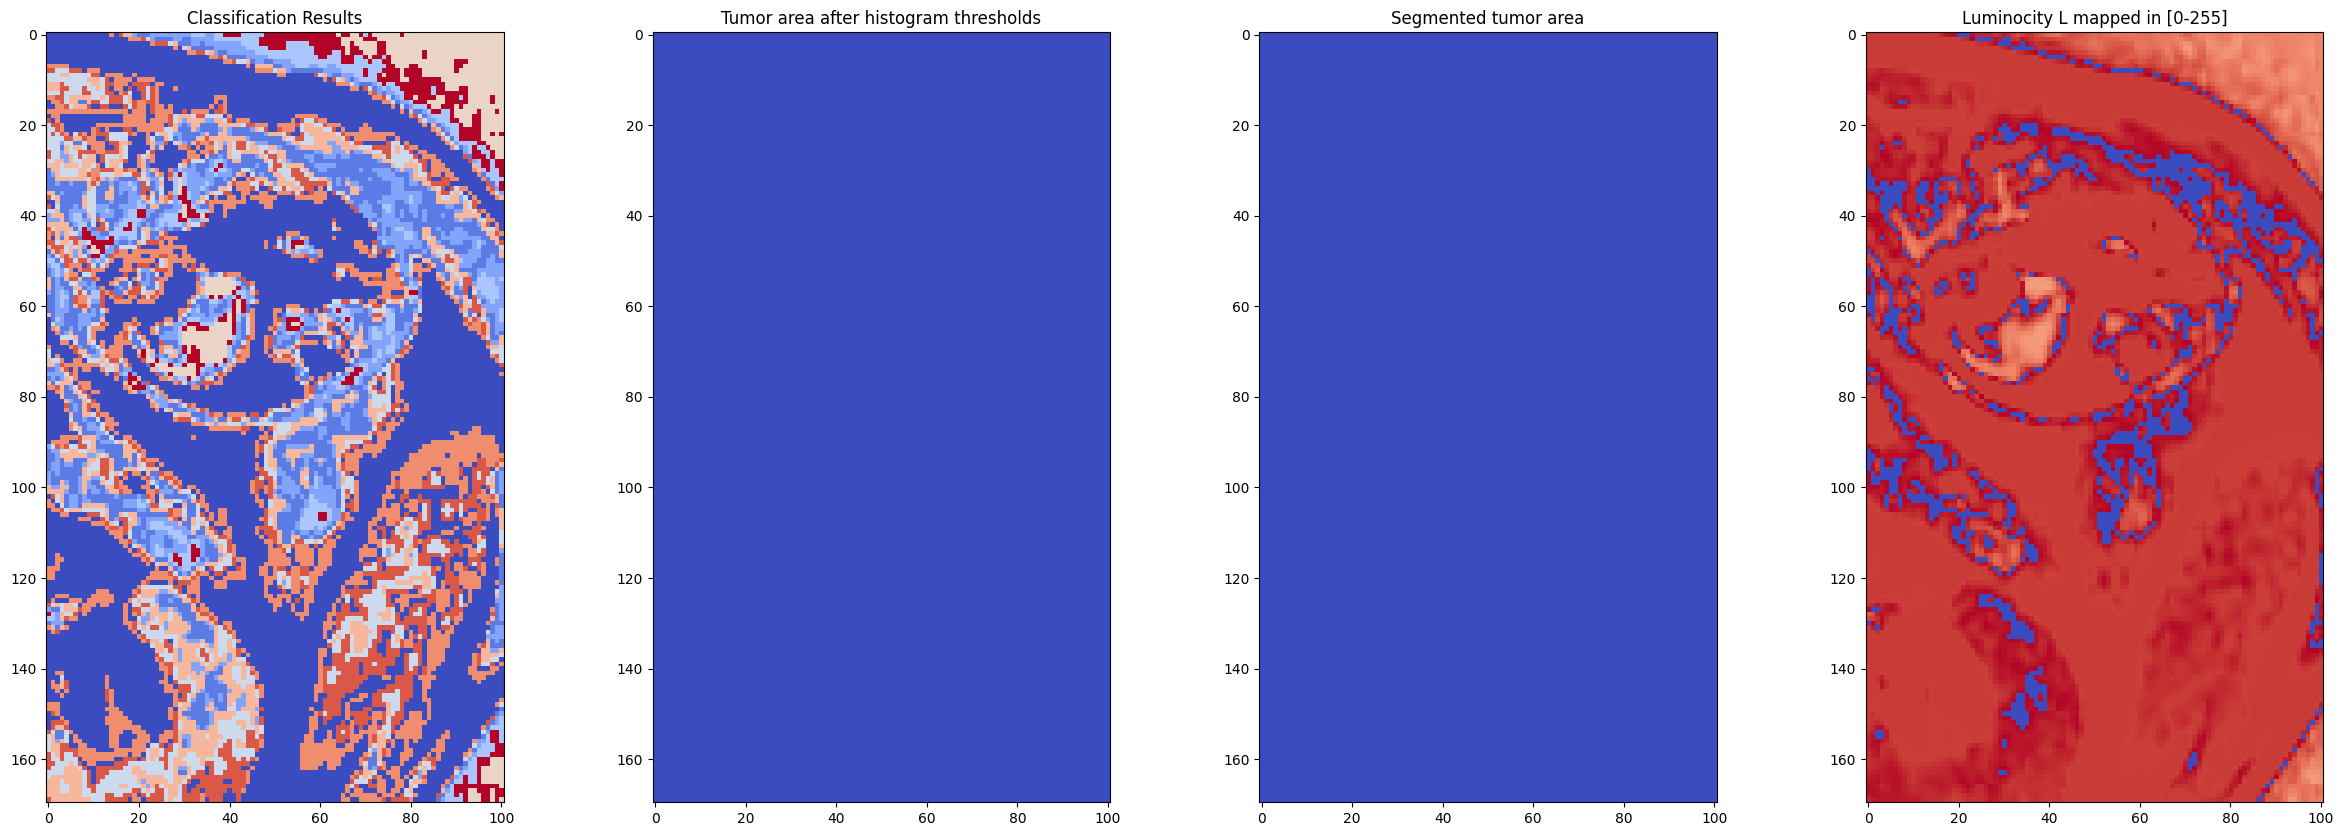

786432
amin now
0.0
amax now
255.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


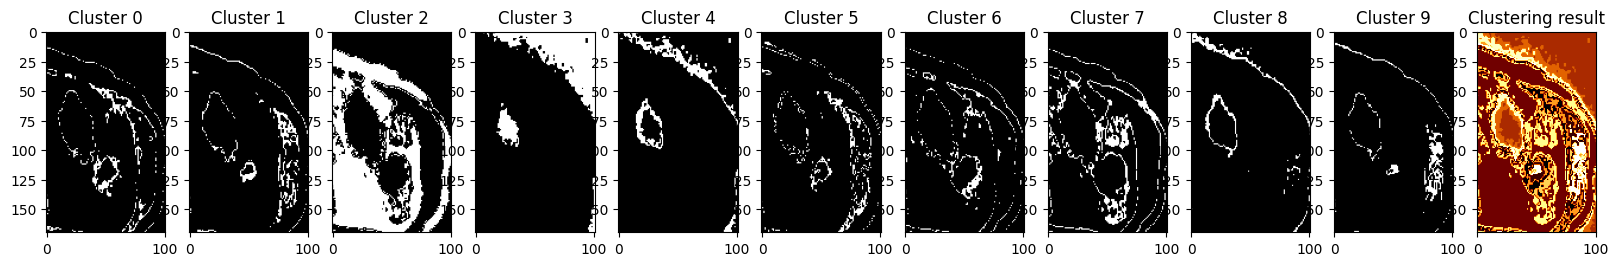

Classification


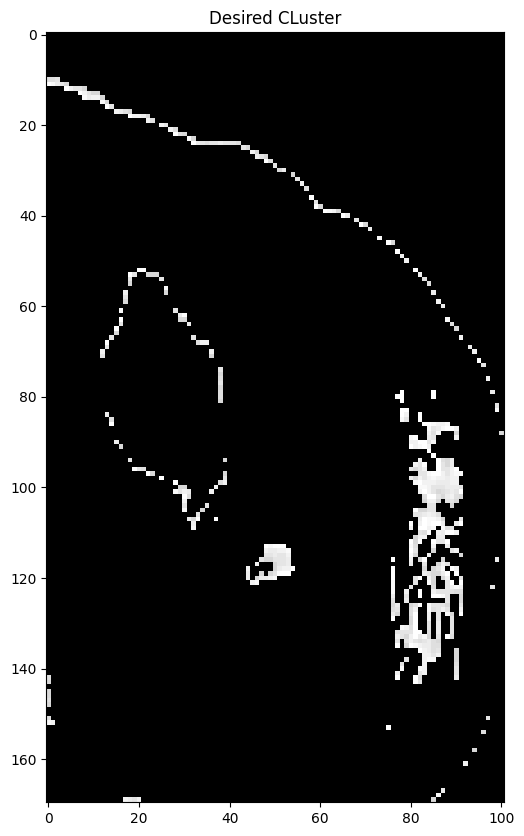

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


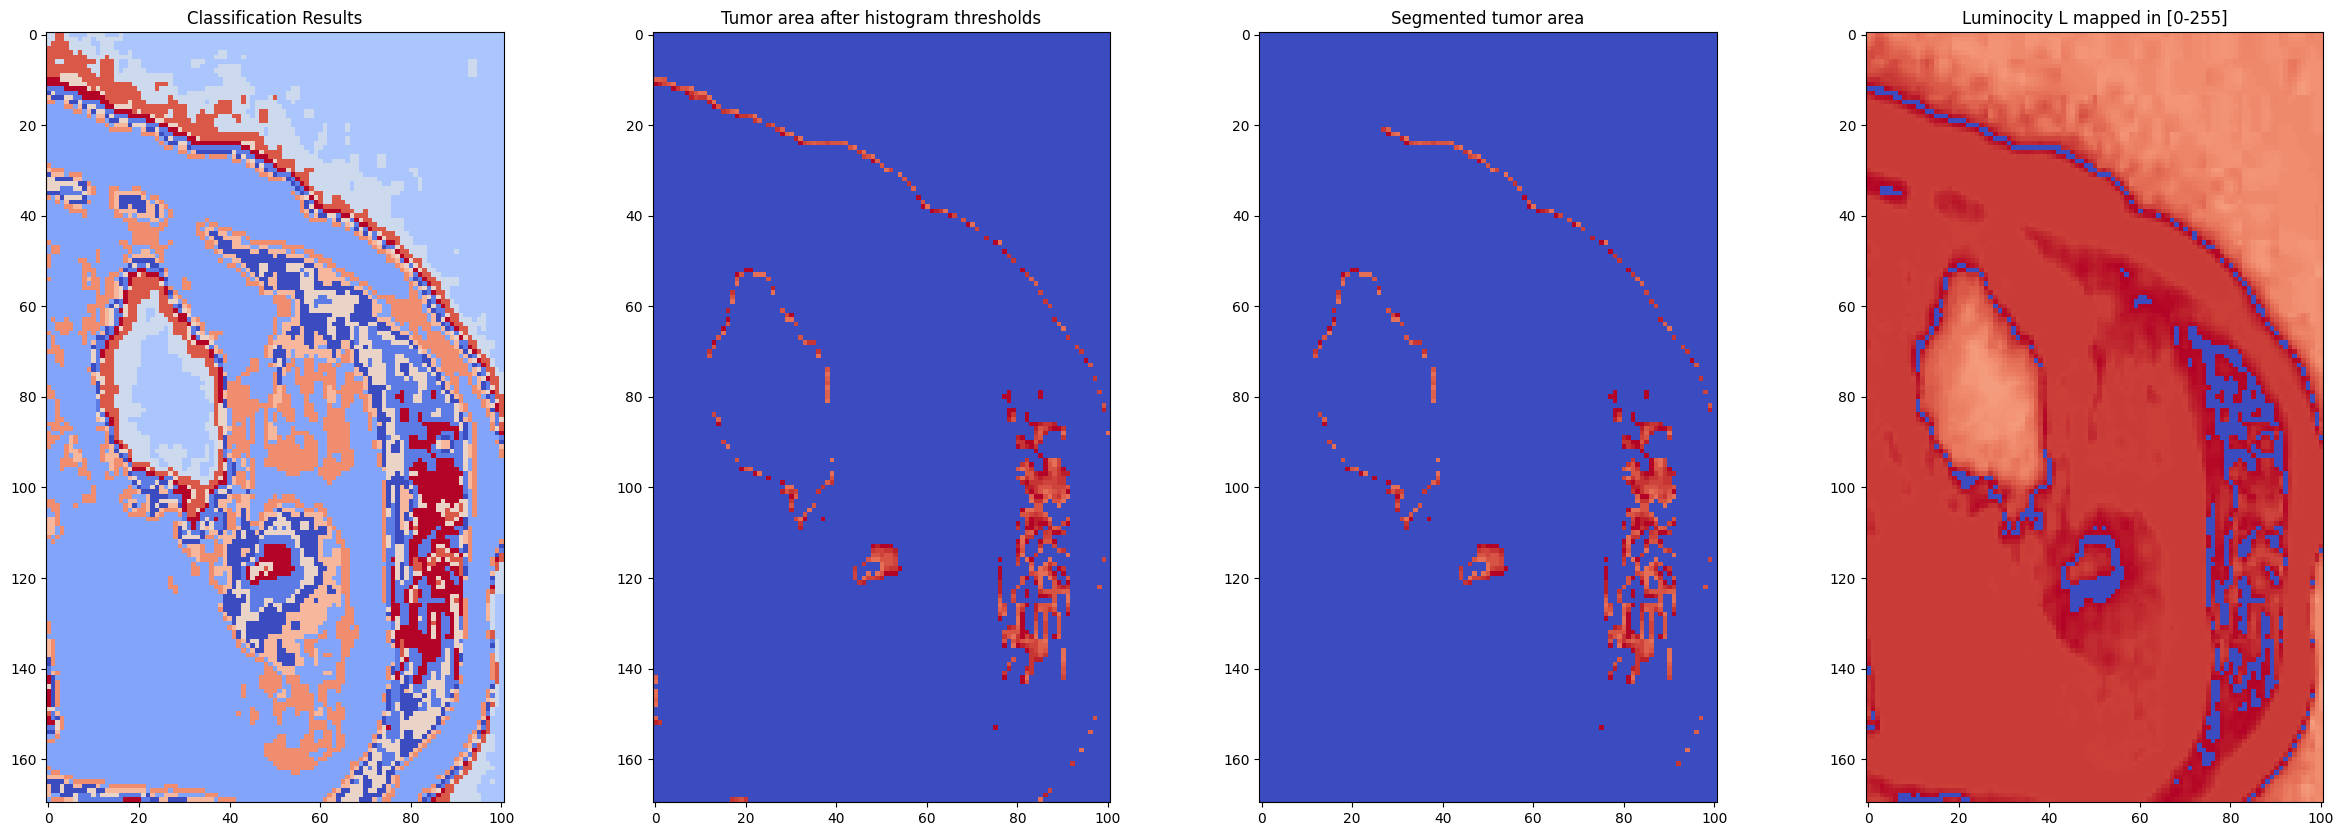

786432
amin now
0.0
amax now
251.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


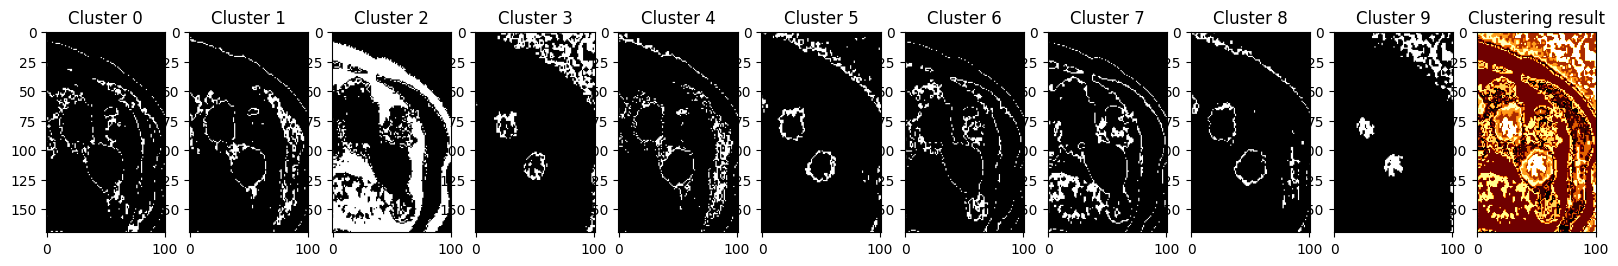

Classification


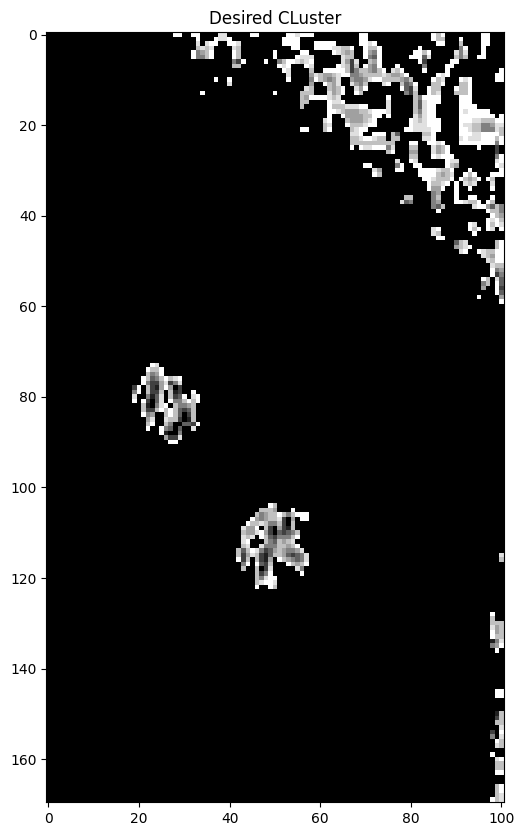

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


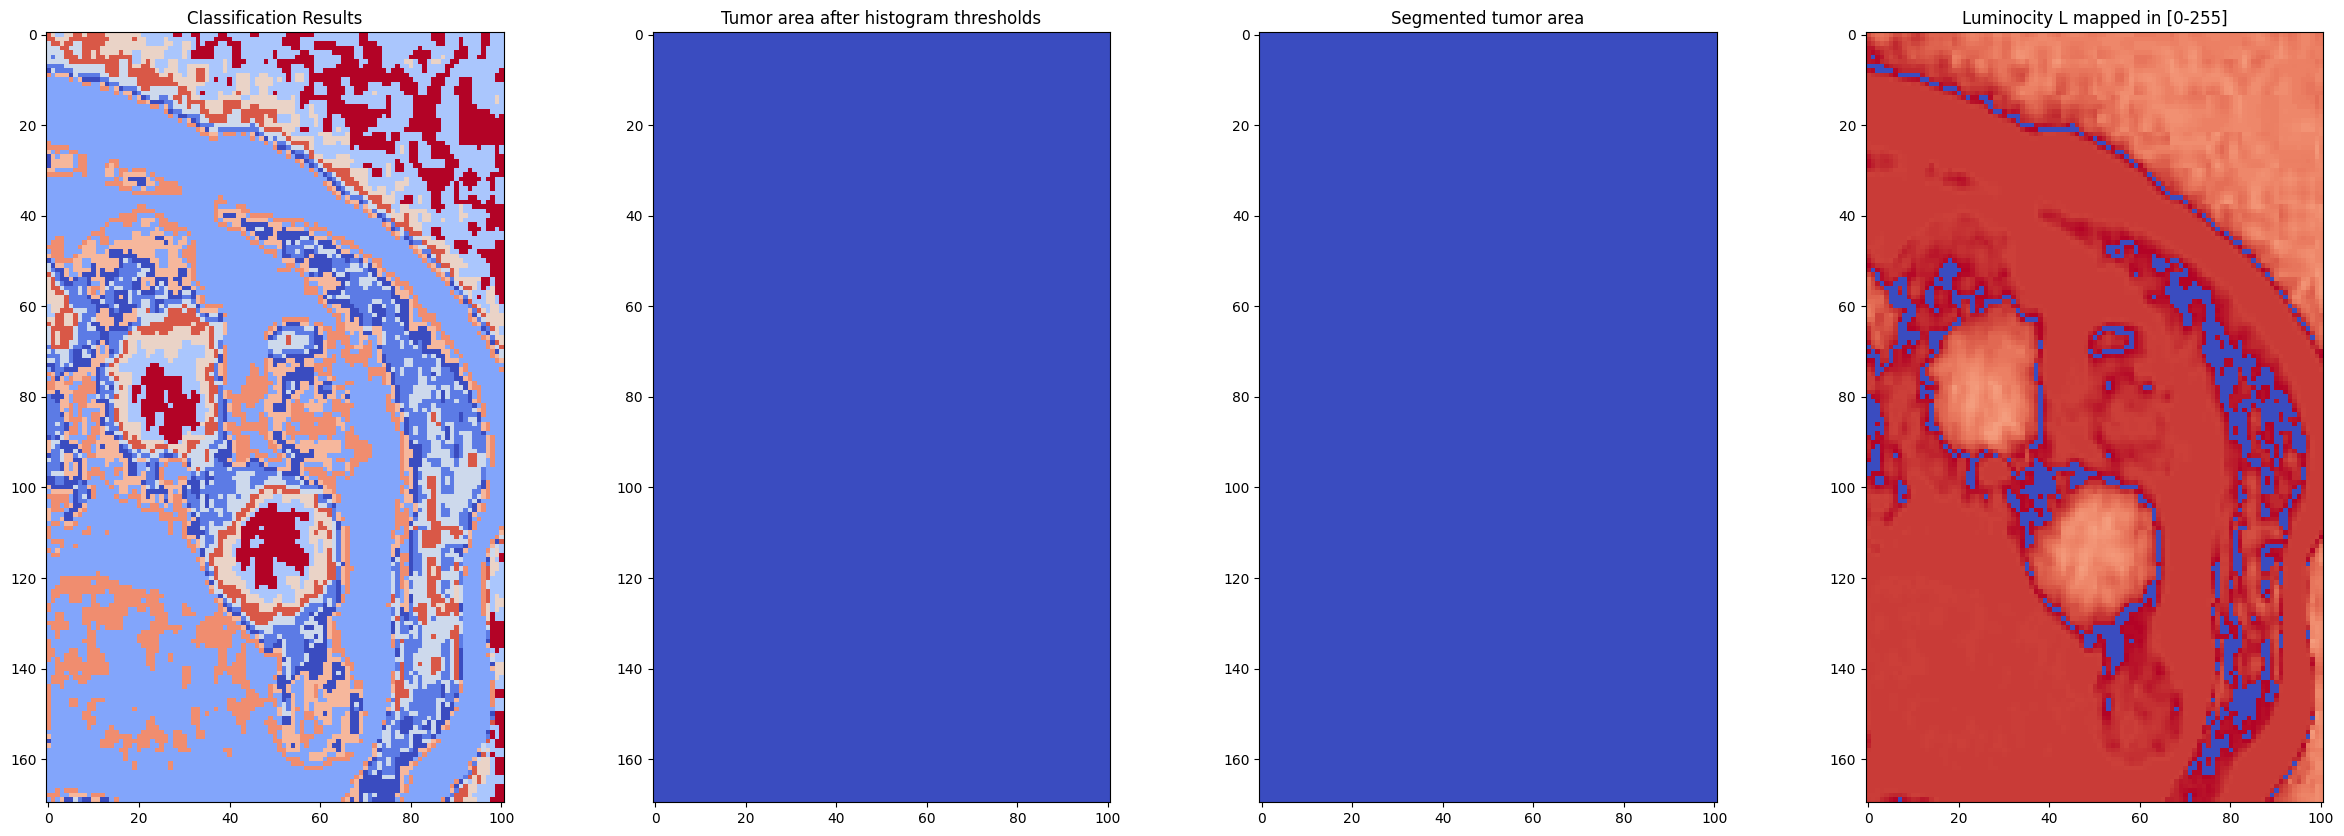

786432
amin now
0.0
amax now
226.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


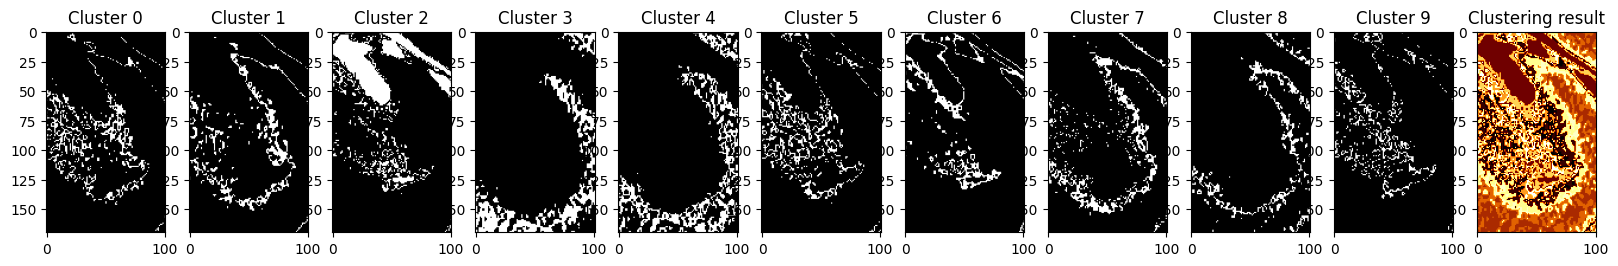

Classification


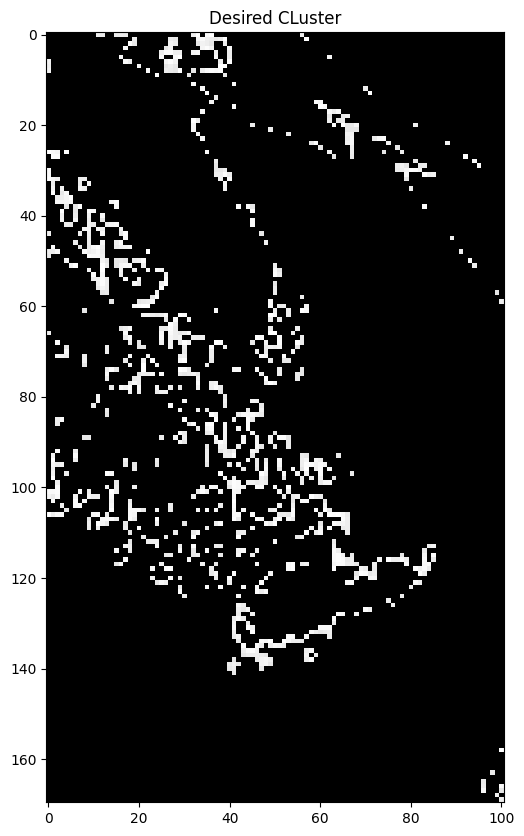

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


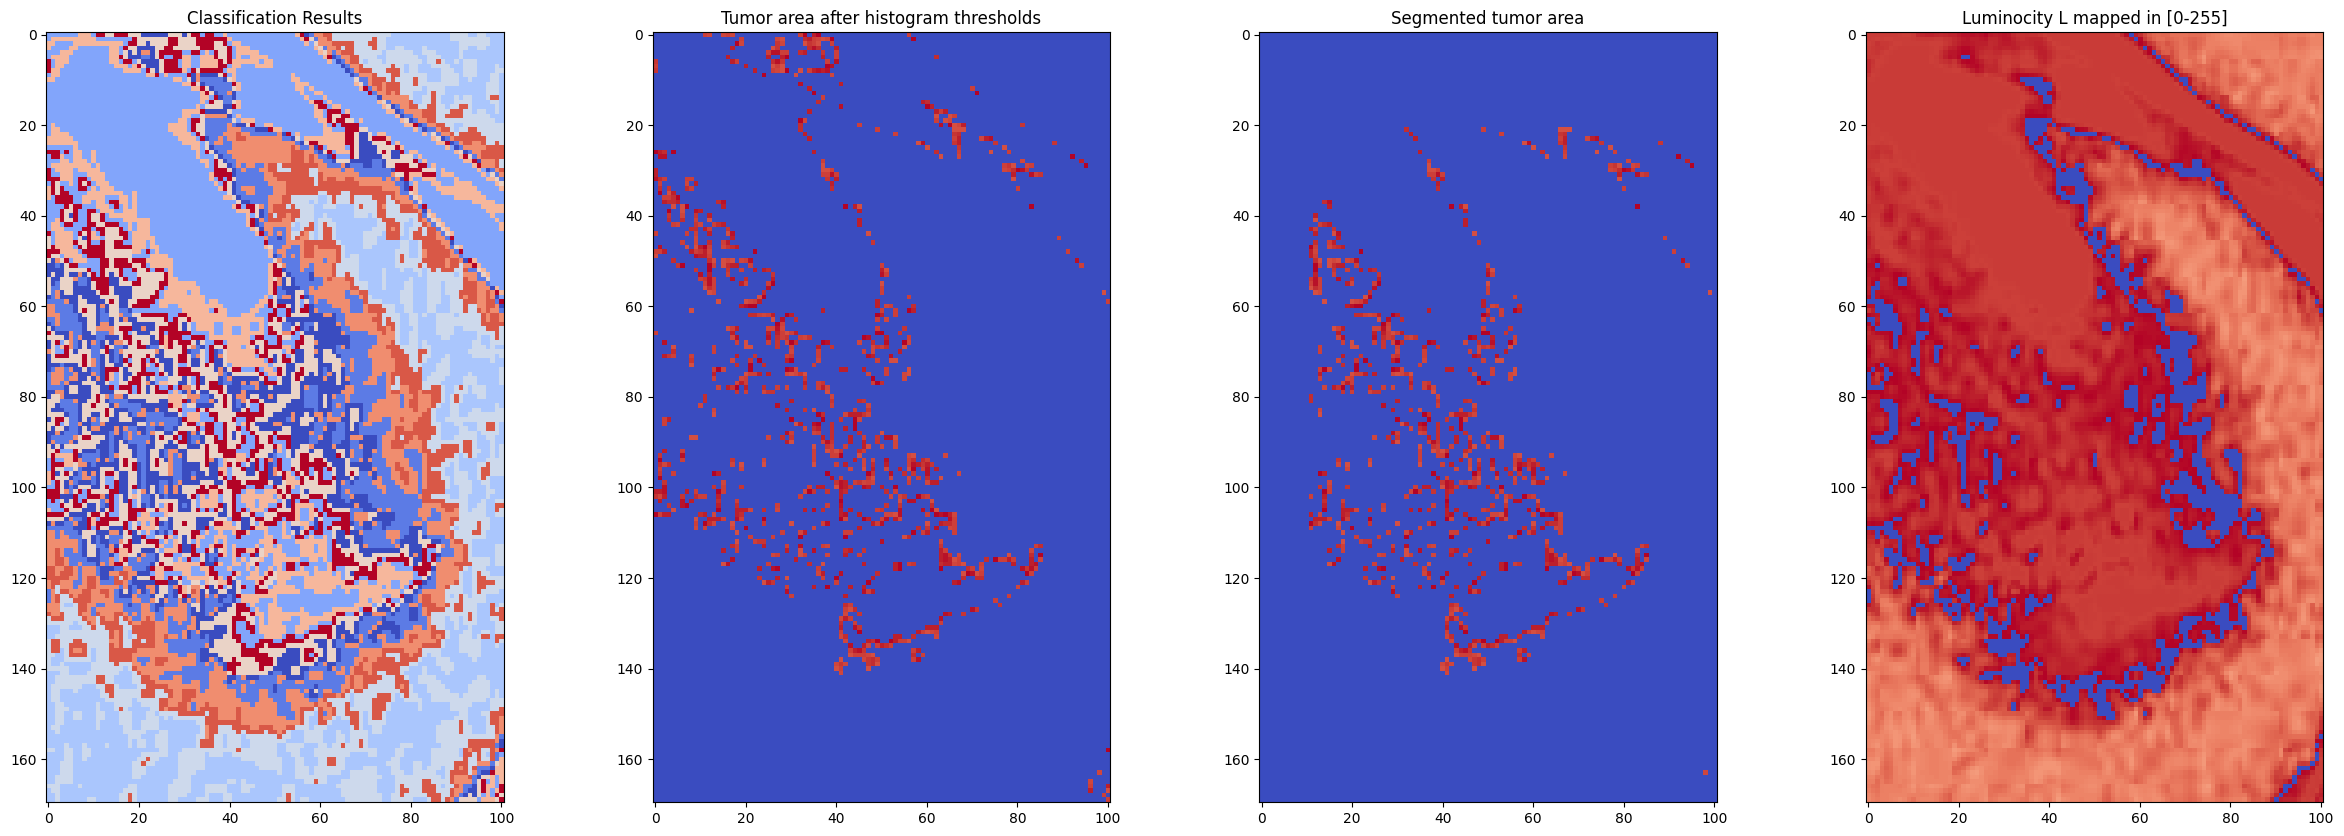

786432
amin now
0.0
amax now
248.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


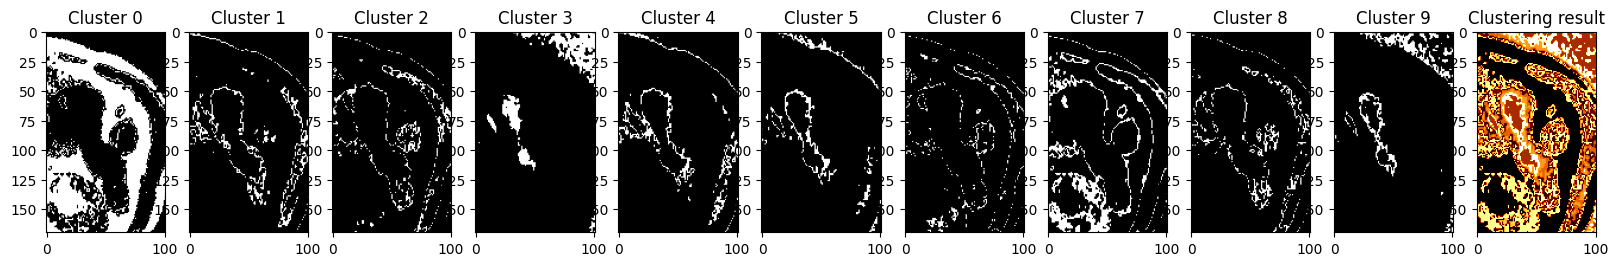

Classification


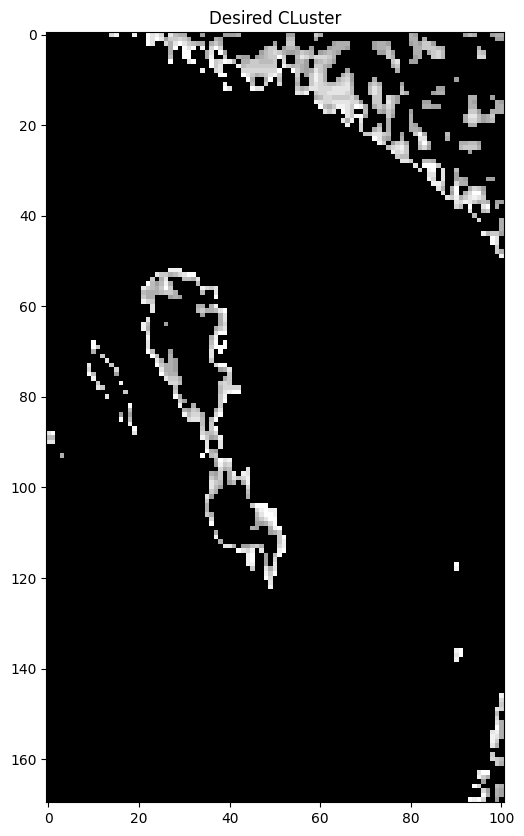

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


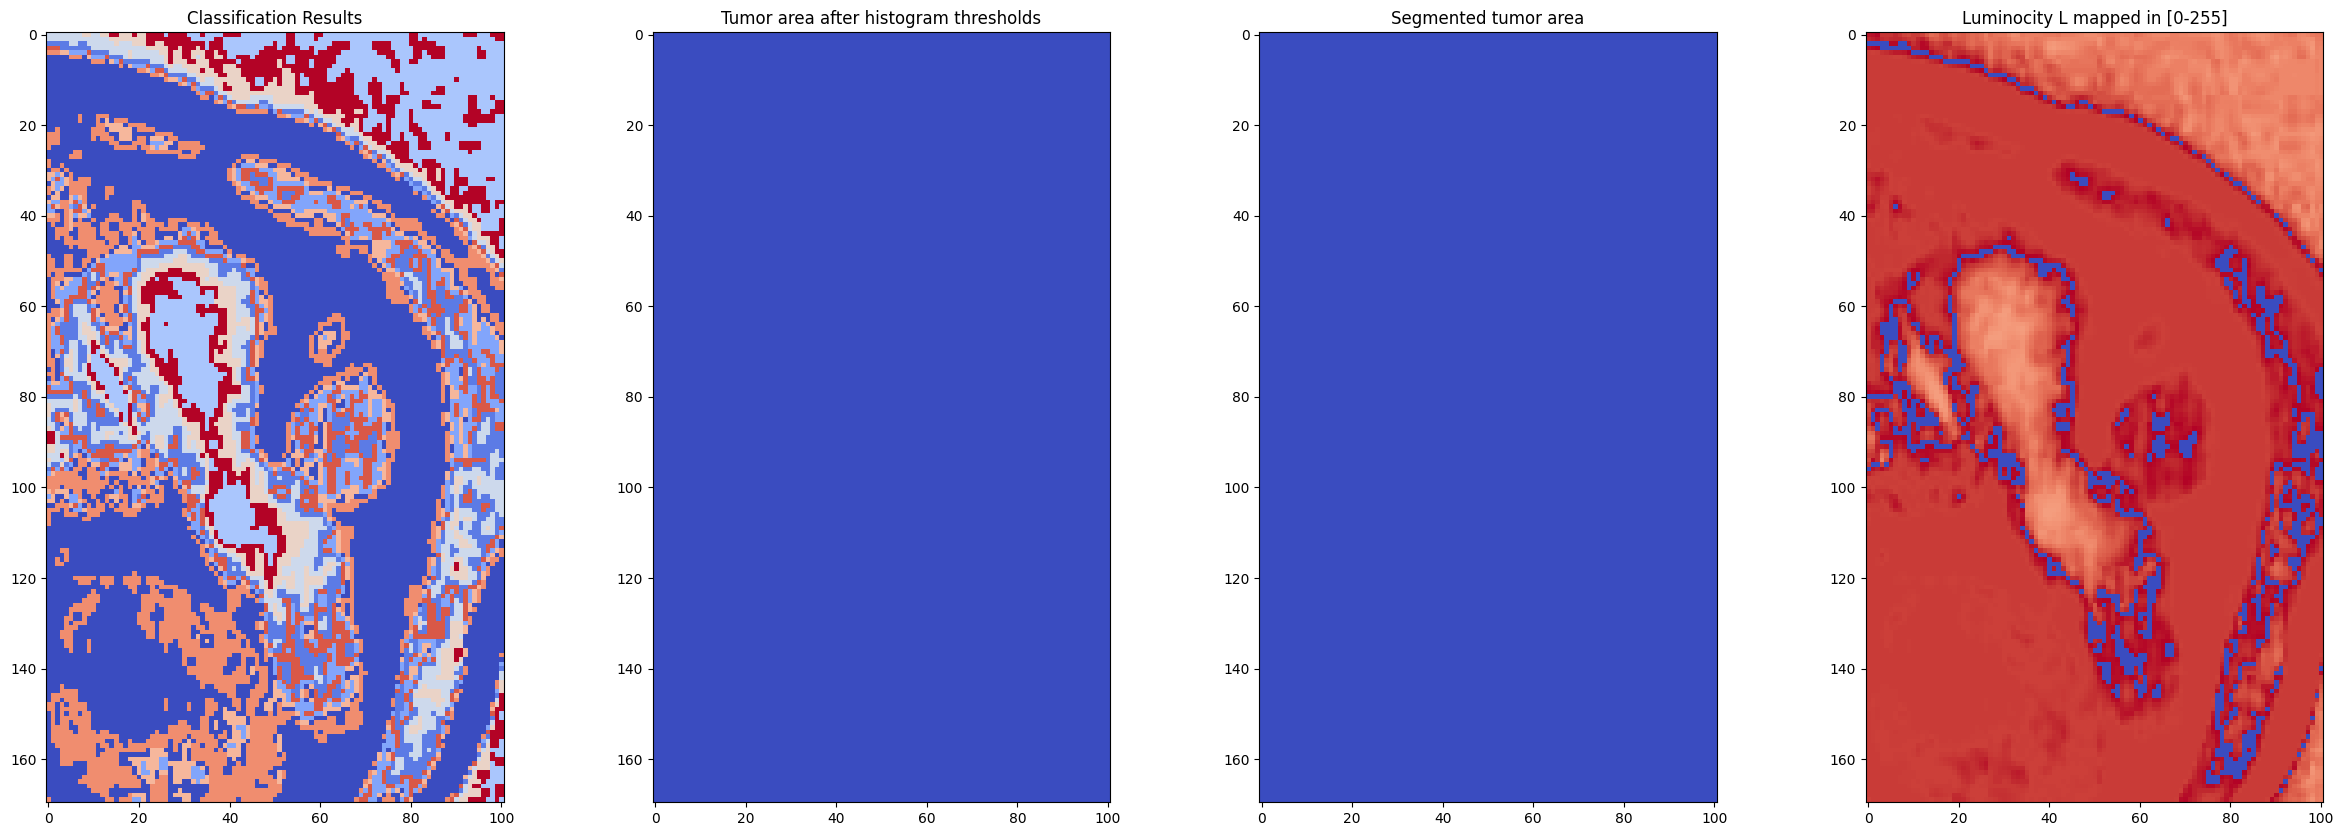

786432
amin now
1.0
amax now
248.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


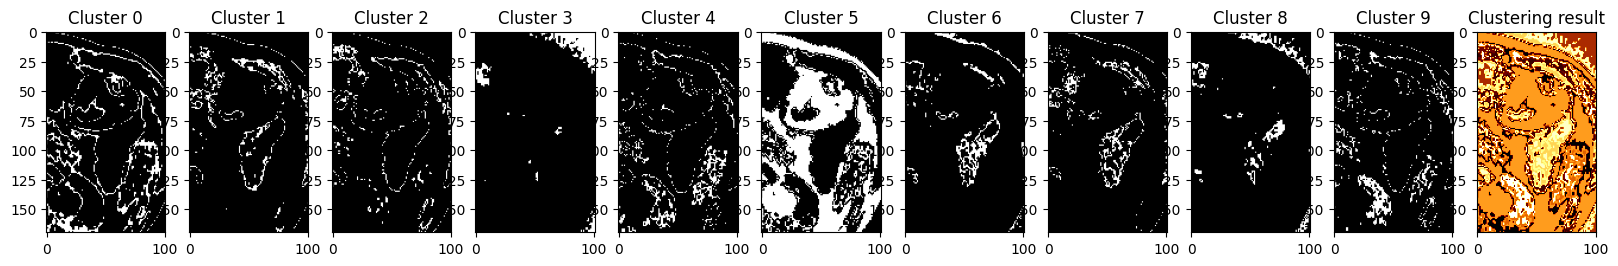

Classification


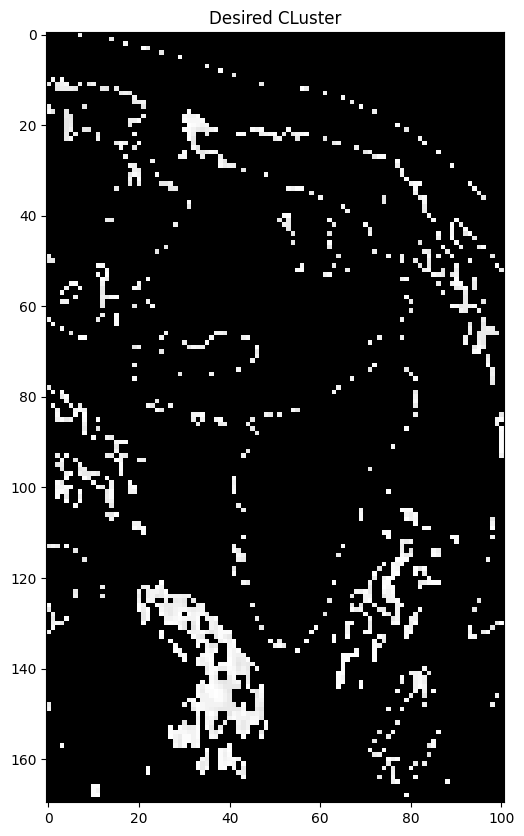

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


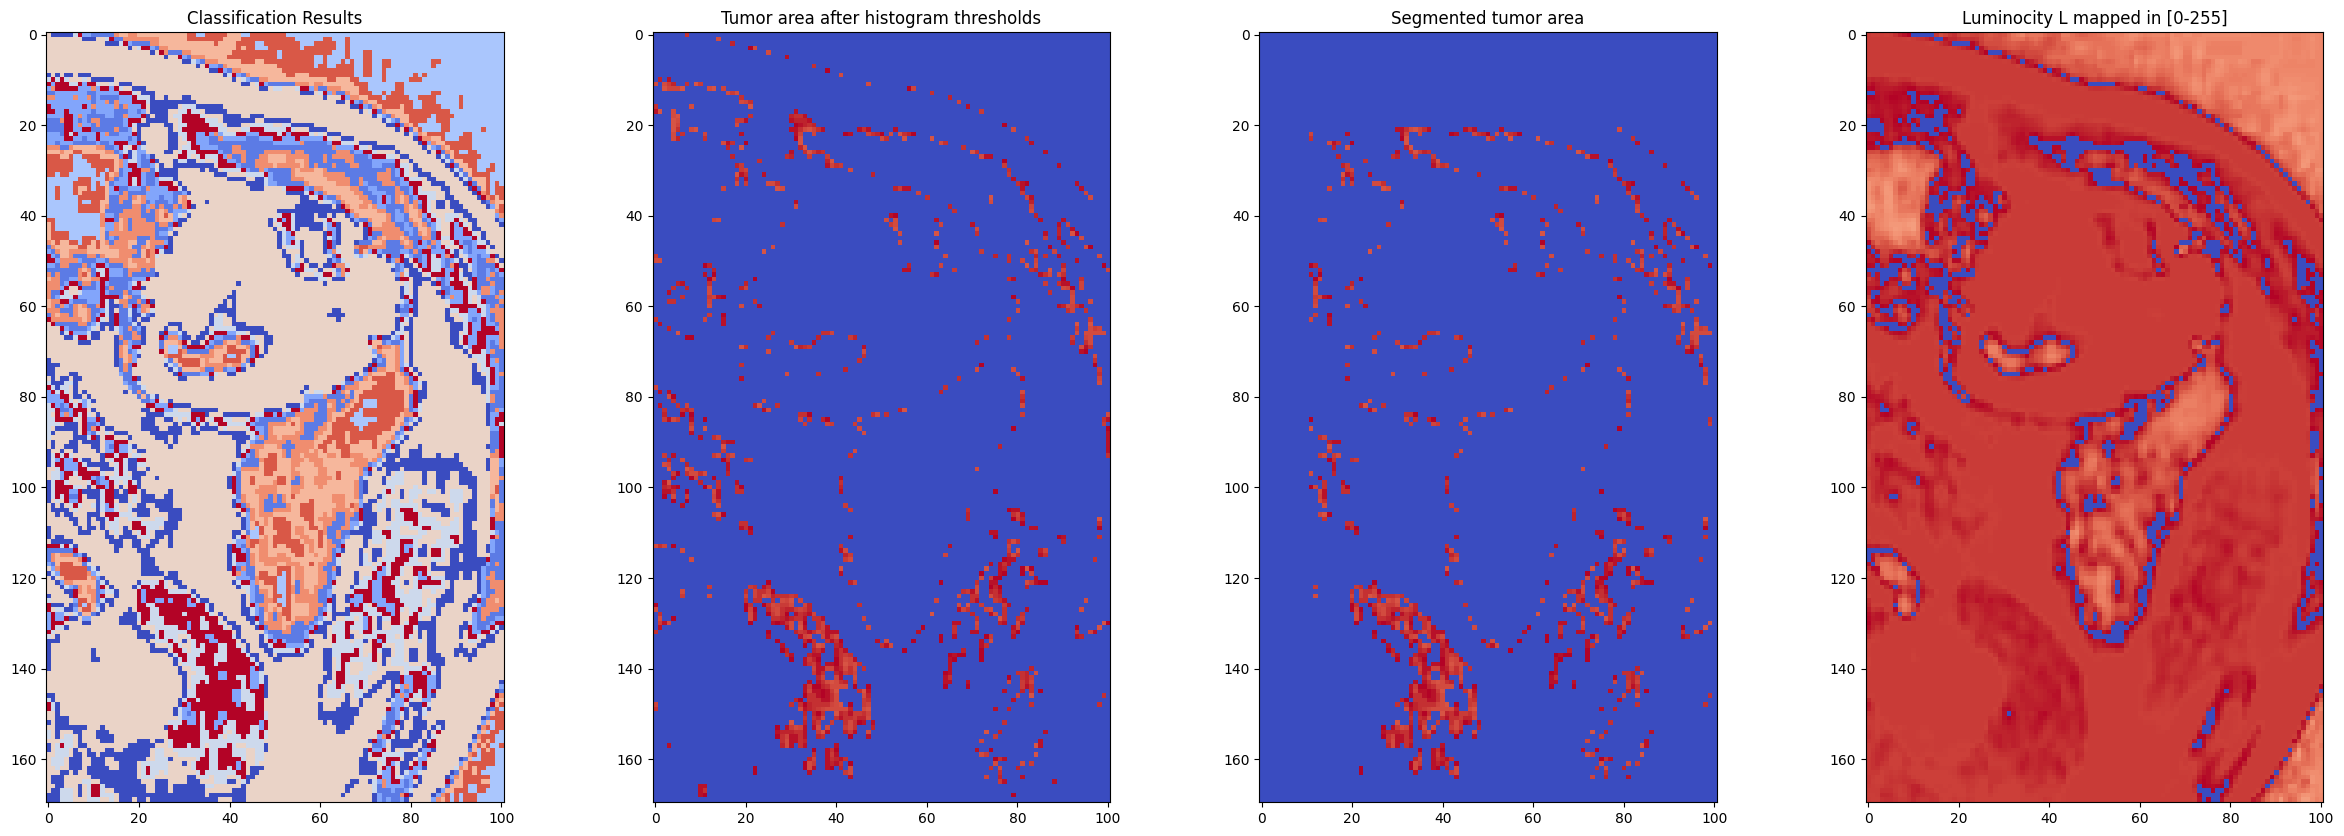

786432
amin now
0.0
amax now
250.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


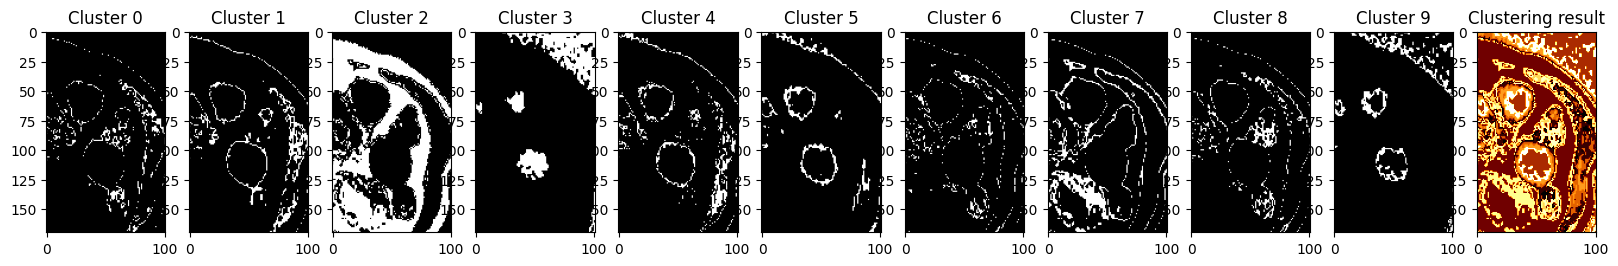

Classification


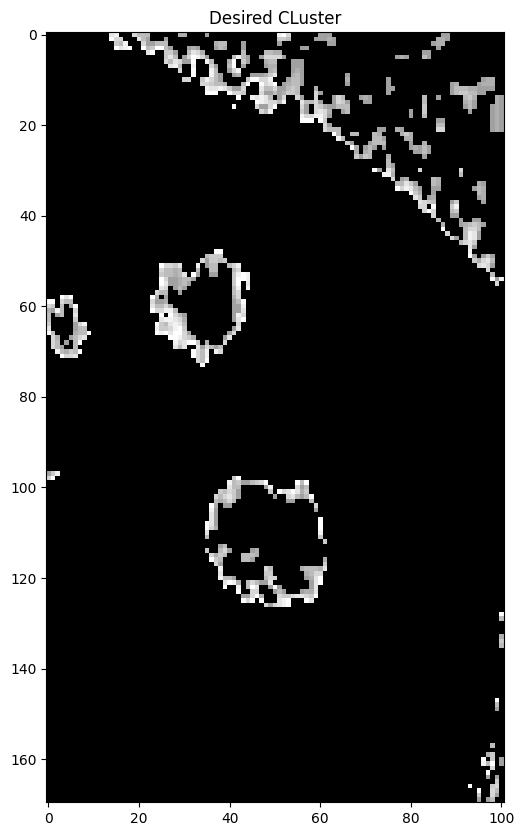

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


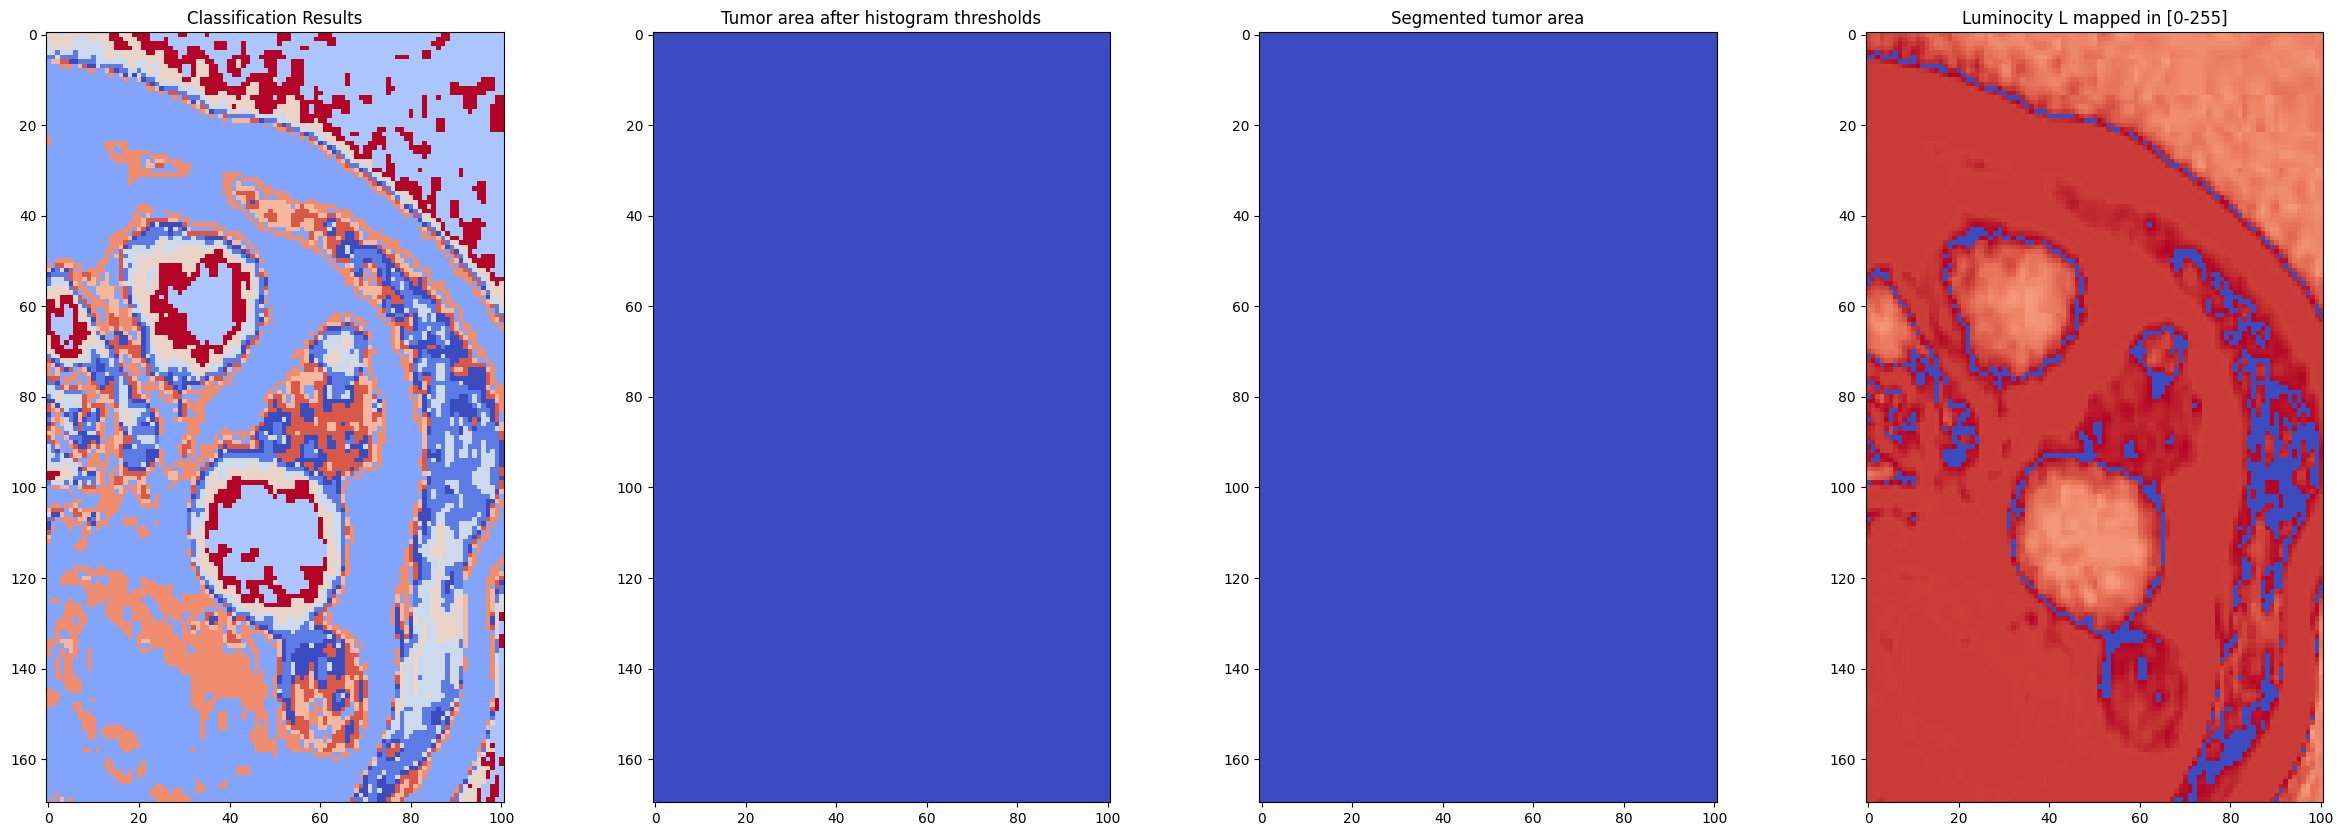

786432
amin now
3.0
amax now
251.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


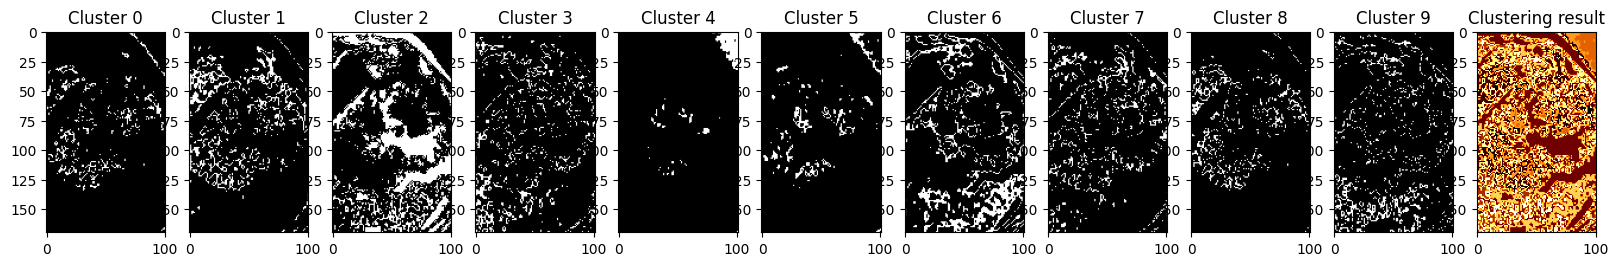

Classification


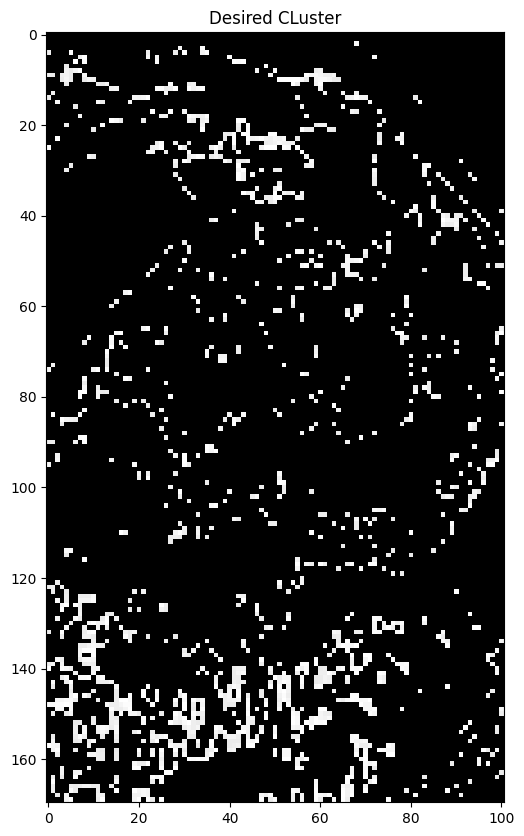

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


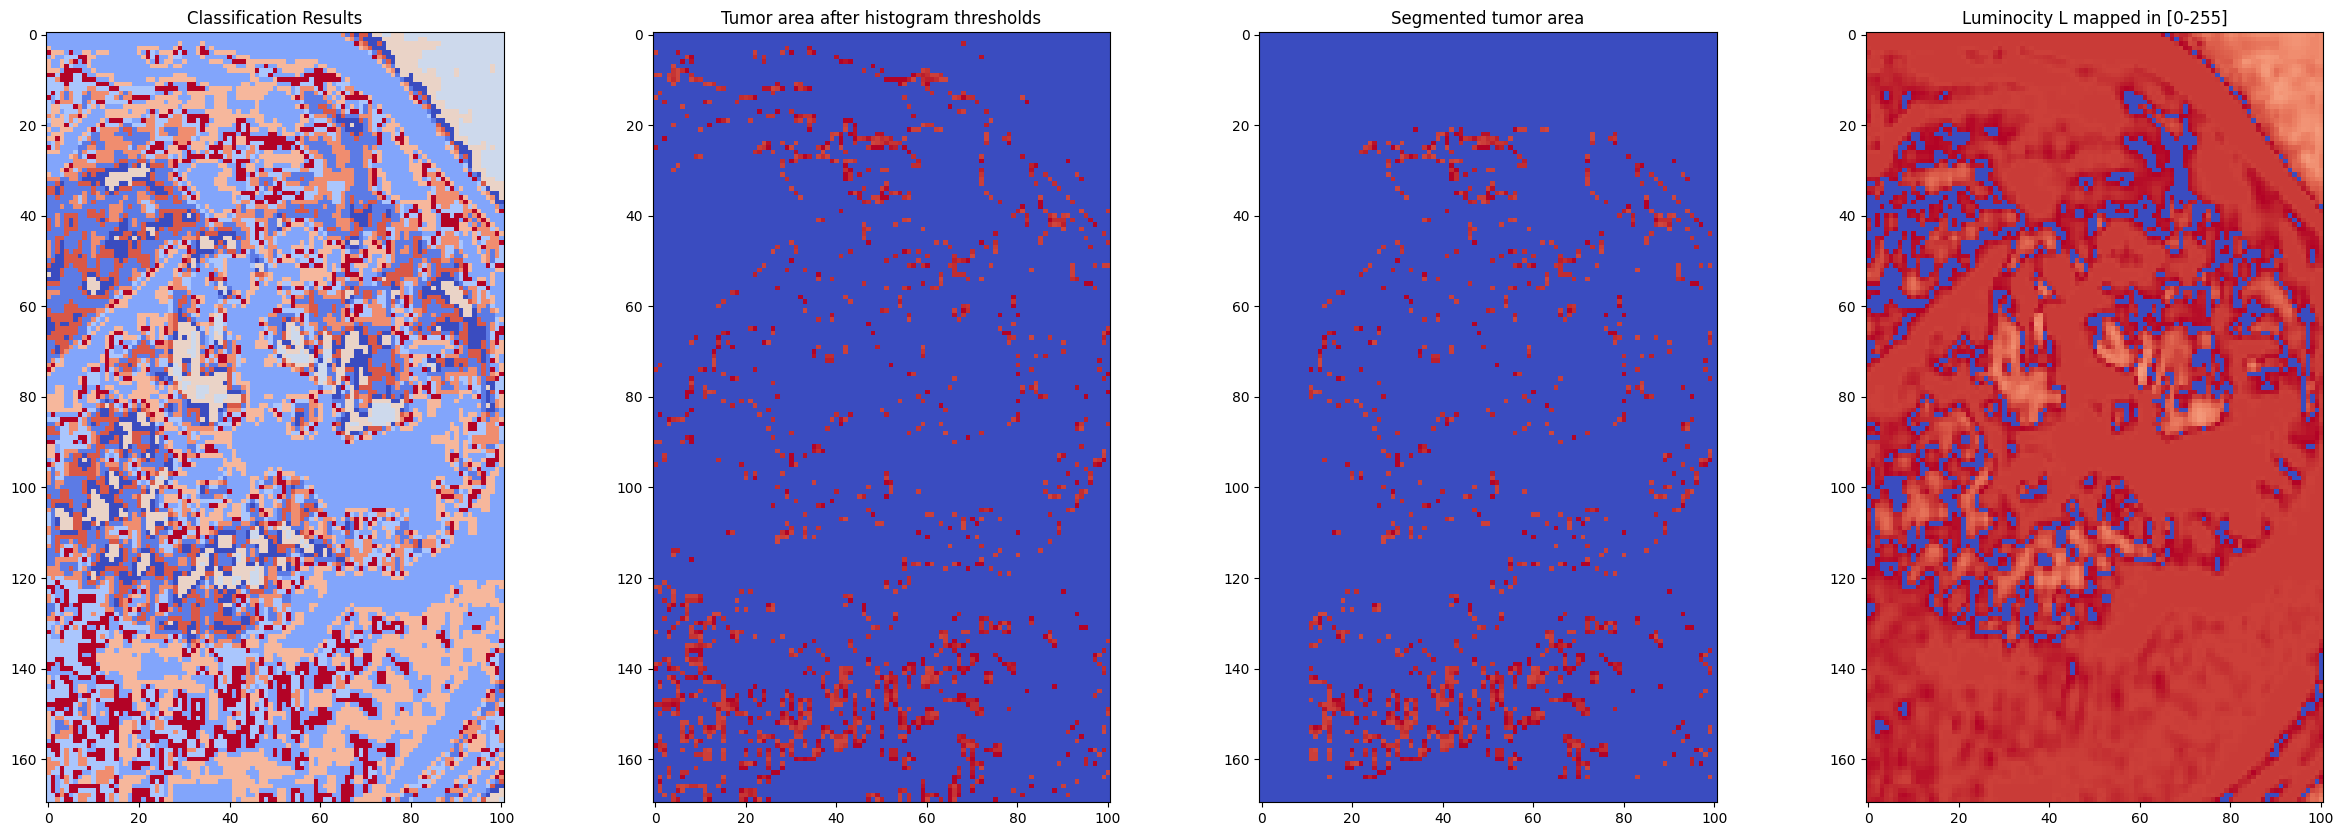

786432
amin now
4.0
amax now
235.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


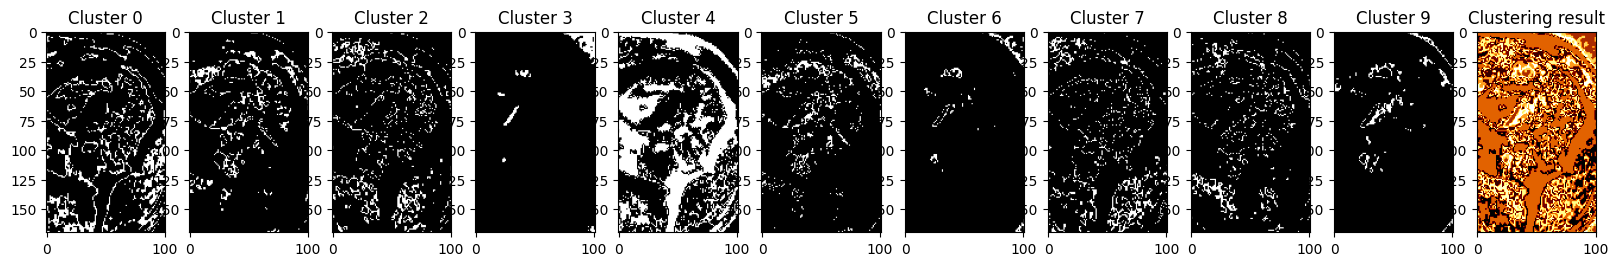

Classification


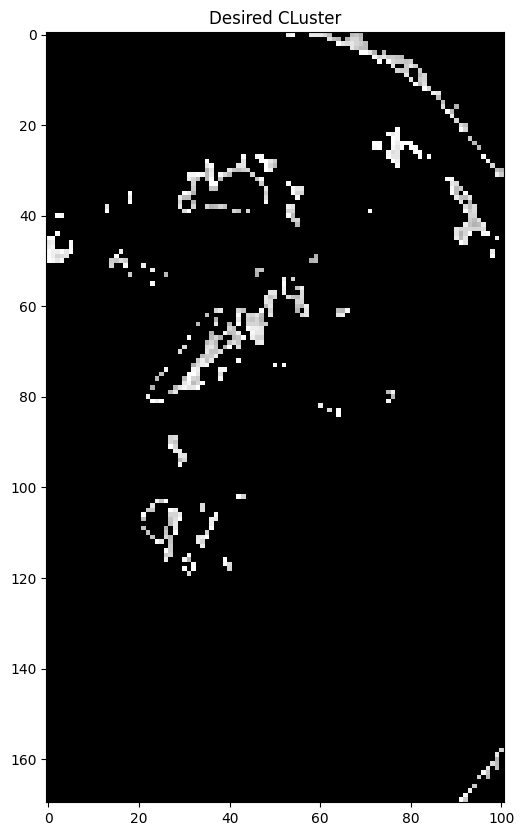

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


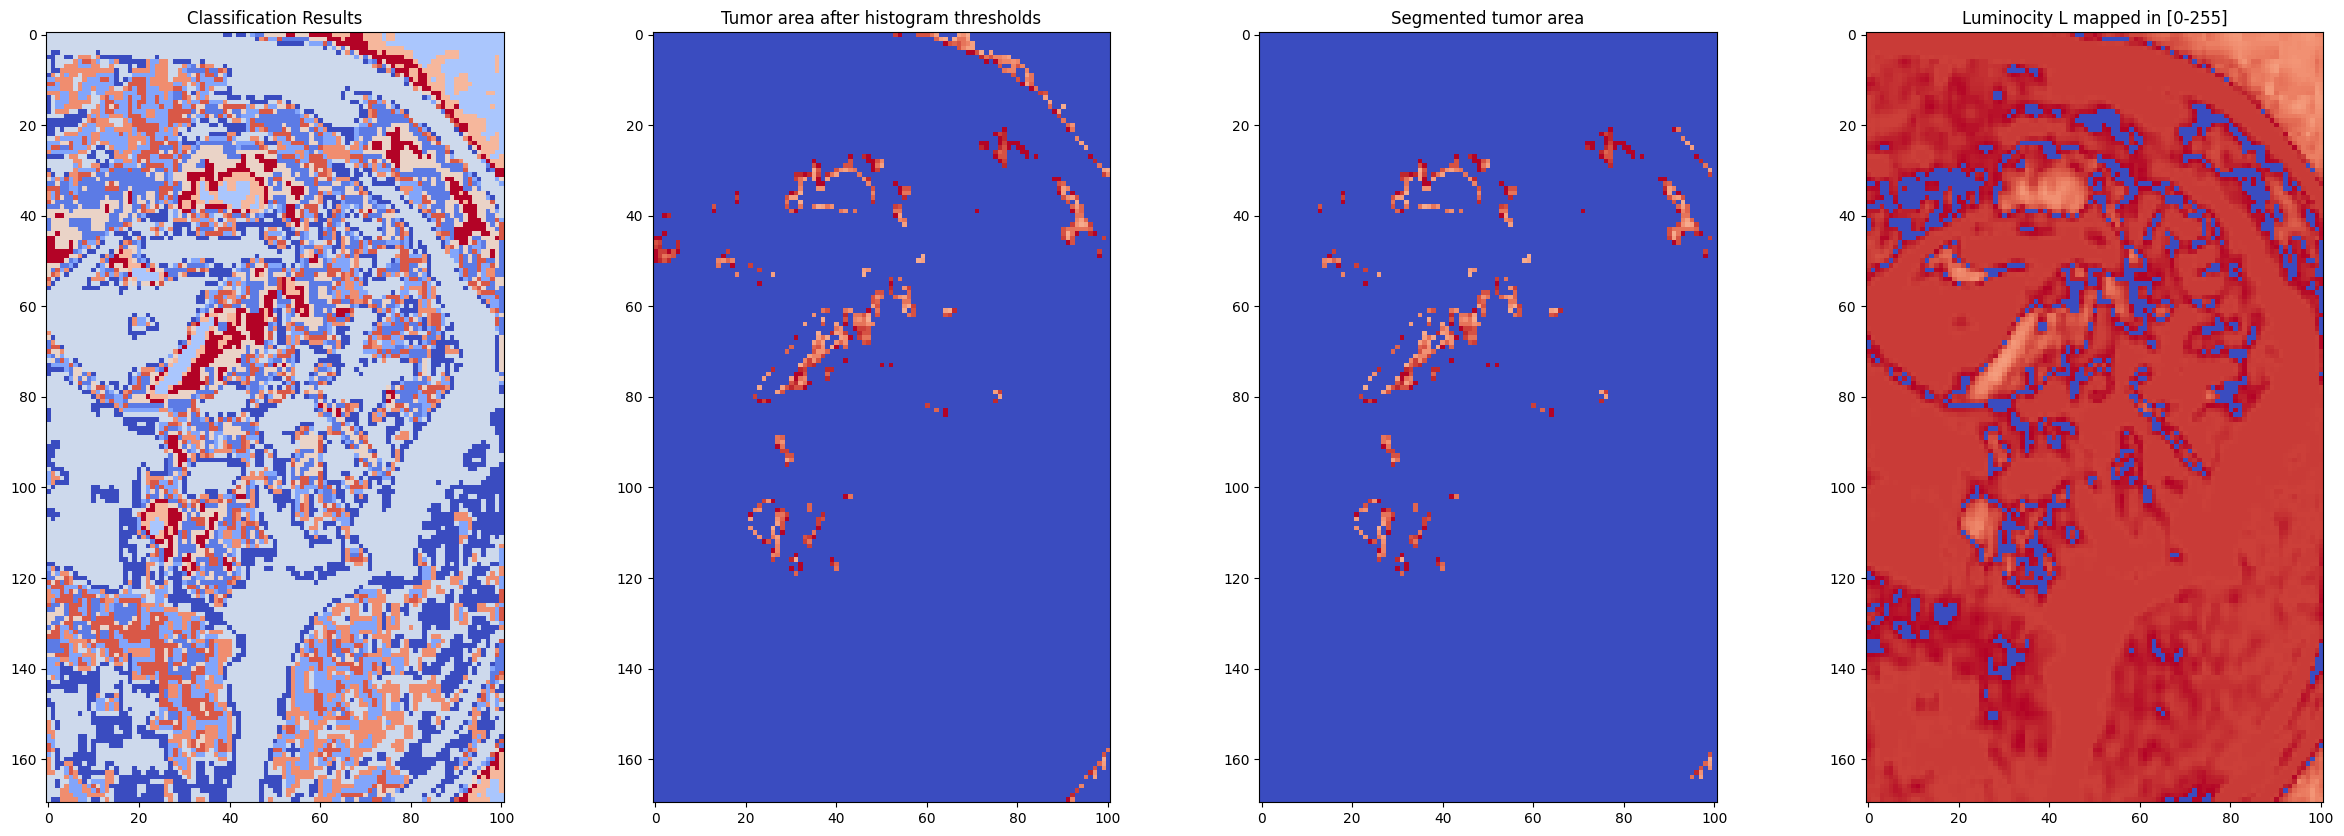

786432
amin now
3.0
amax now
245.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


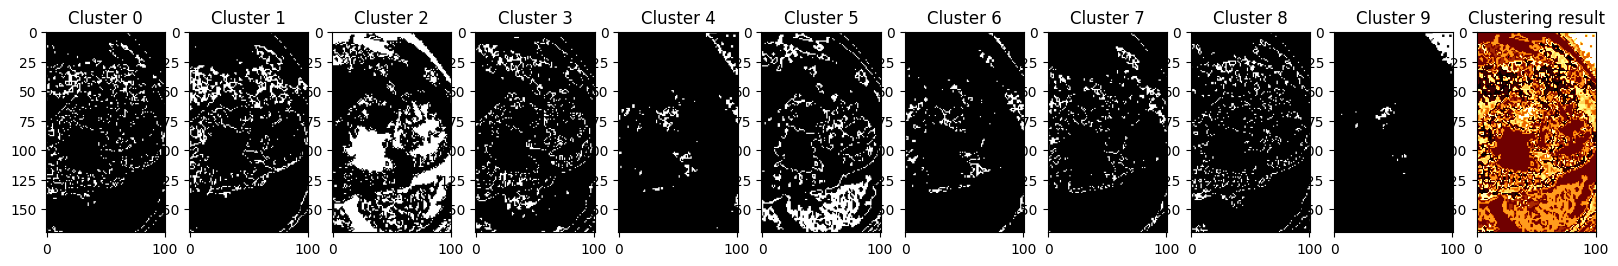

Classification


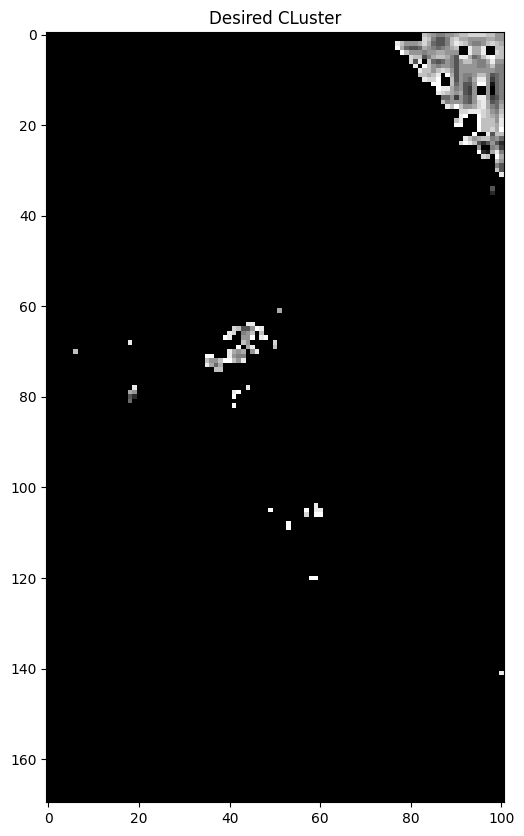

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


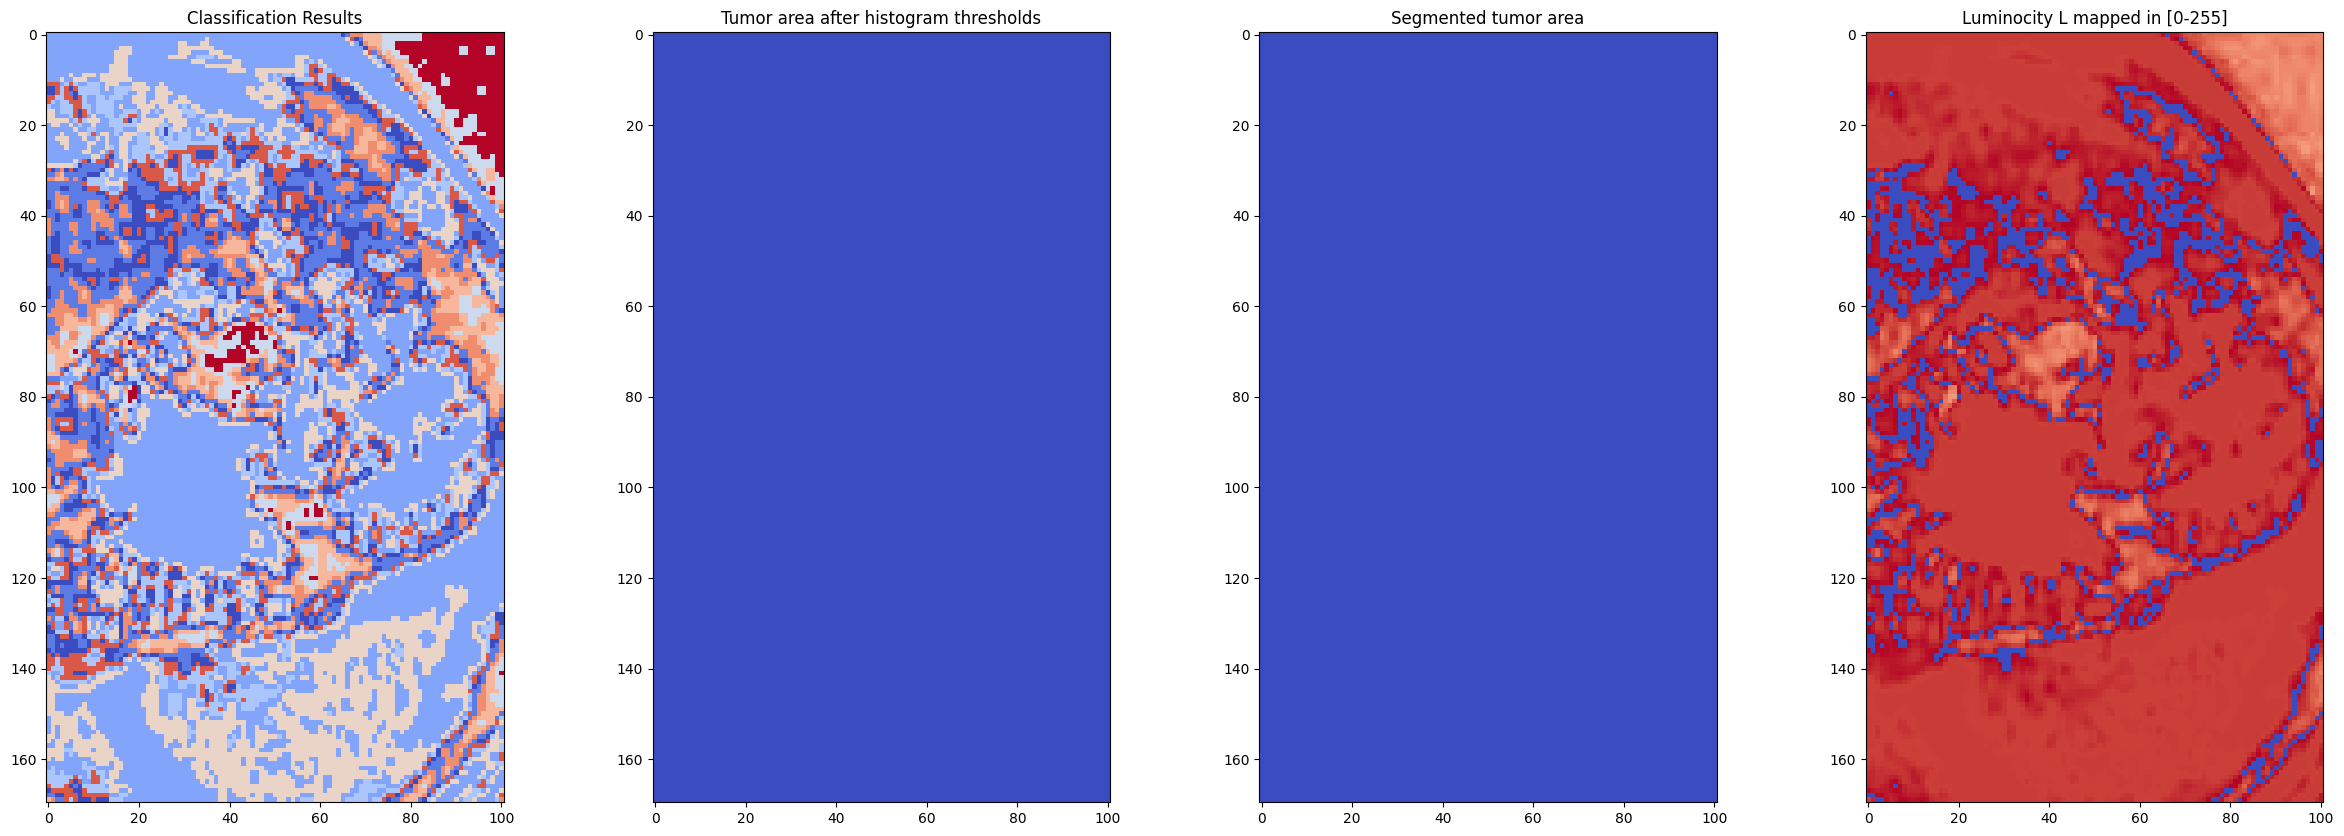

786432
amin now
2.0
amax now
235.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


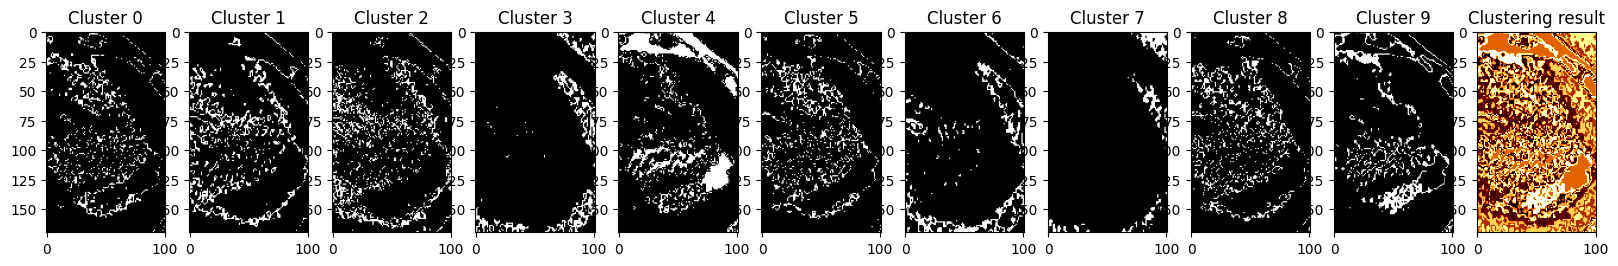

Classification


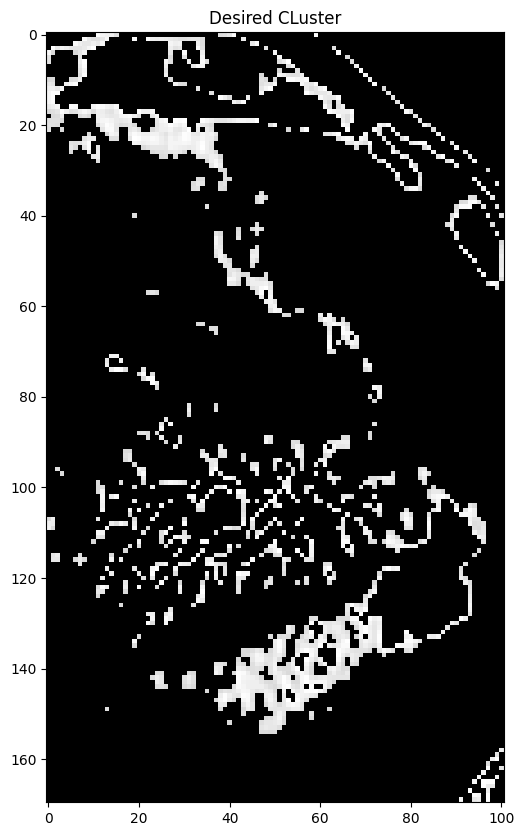

L min -14.971439178193934 L max:7.987991814400001
lmin < 0


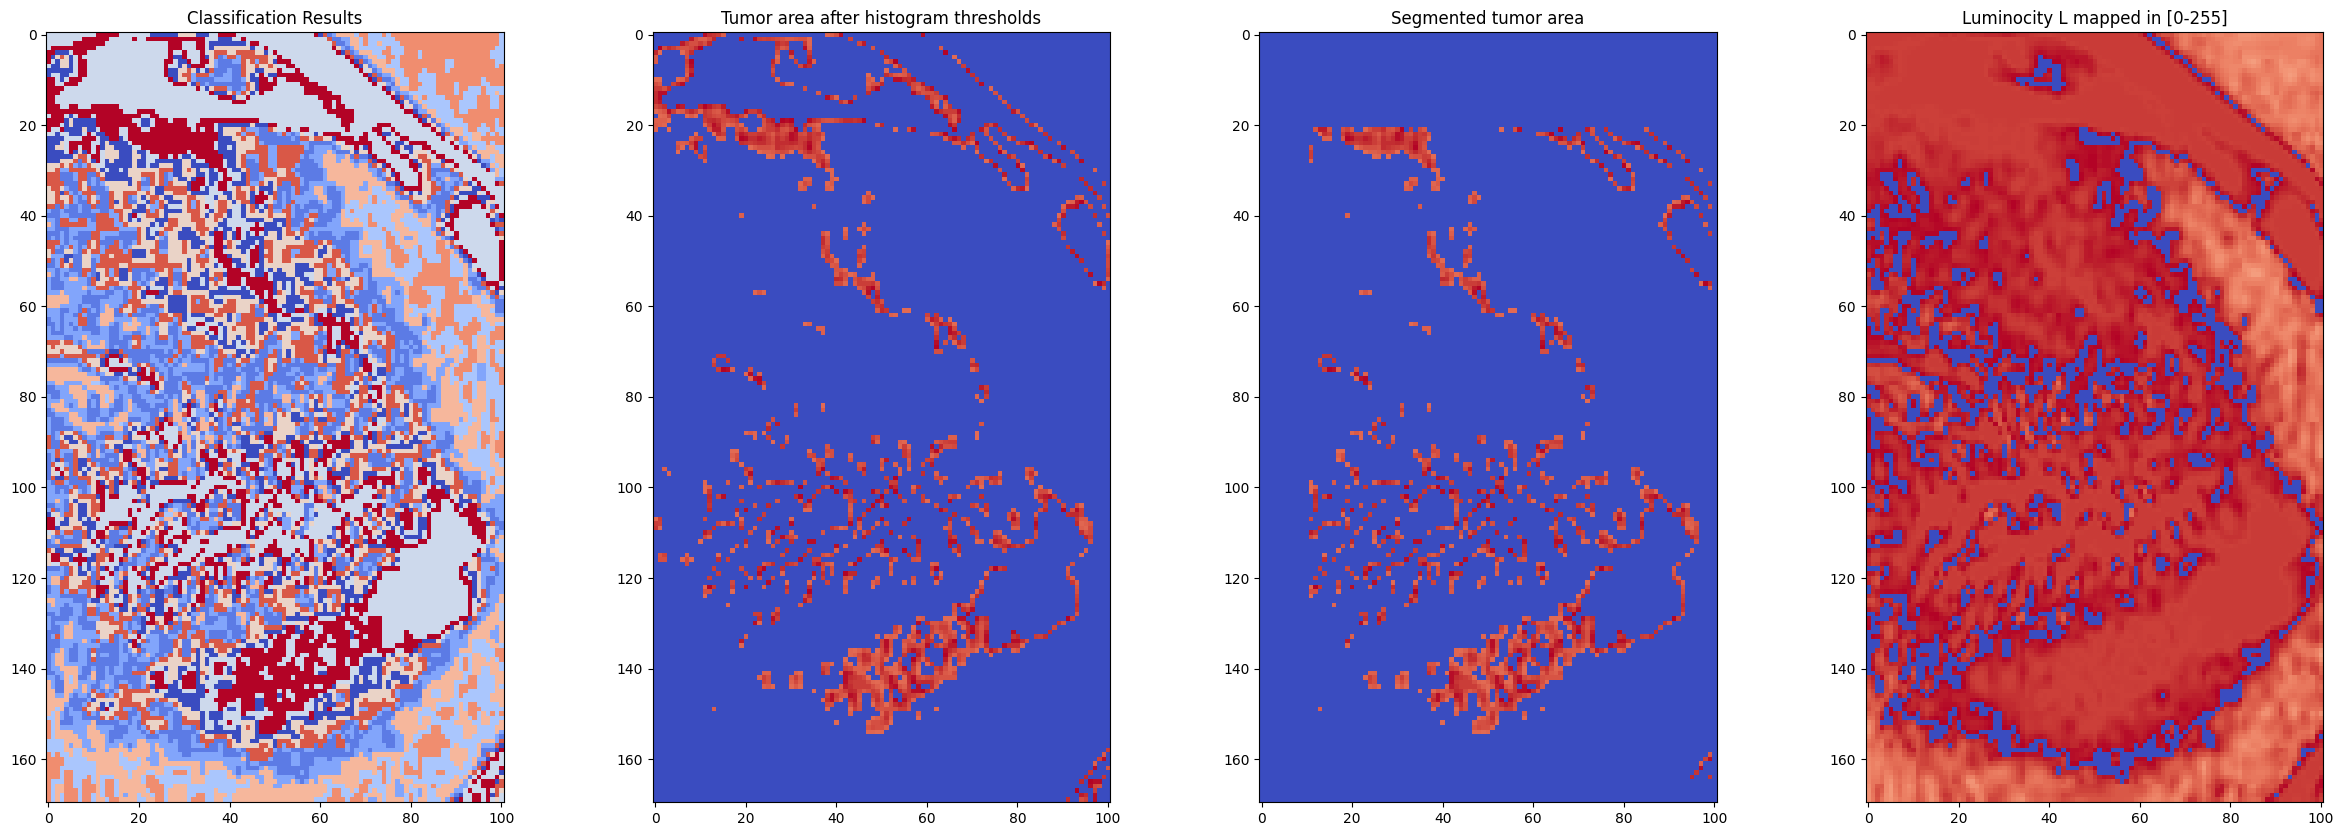

In [ ]:
directory1 = '/content/preprocess_output/processed_img'
i = 0
for filename in os.listdir(directory1):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        i +=1
        img = np.array(cv2.imread(os.path.join(directory1, filename)), dtype=int)
        print(img.size)
        # img = np.array(img,dtype=int)
        # crop_img = img[170:350, 309:410]
        crop_img1 = img[170:340, 309:410]
        # ex1 = resize(crop_img, (170, 101),0)
        ext = np.array(crop_img1, dtype=np.uint8)
        ext.shape
        img_grayt = cv2.cvtColor(ext, cv2.COLOR_BGR2GRAY)
        KMeans1(img_grayt, filename, i)
    else:
        continue

# Classification

## Section 1

In [ ]:
import torch
from torch import optim
from torch.optim import lr_scheduler
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy.orm import mapper
import json
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

# from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook
import copy
import time
import os

In [ ]:
from PIL import Image
from torch.autograd import Variable
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import models

In [ ]:
device = 'cuda'

In [ ]:
dx ="/content/out/benign"
for i in range(11):
  xg = Image.open('/content/out/benign/fcmeans_1.png')
  xg2 = xg.copy()
  xg2 = np.asarray(xg2, dtype=int)
  nm = str(i)+'sampled.png'
  cv2.imwrite(os.path.join(dx,nm), xg2)

In [ ]:
!unzip '/content/drive/MyDrive/Pancreatic tumor /input.zip'

unzip:  cannot find or open /content/drive/MyDrive/Pancreatic tumor /input.zip, /content/drive/MyDrive/Pancreatic tumor /input.zip.zip or /content/drive/MyDrive/Pancreatic tumor /input.zip.ZIP.


In [ ]:
data_dir = '/content/out'
batch_size = 1

## Section 2

HHO

In [ ]:
import random
import numpy
import math
import time

def HHO(objf,lb,ub,dim,SearchAgents_no,Max_iter):

    #dim=30
    #SearchAgents_no=50
    #lb=-100
    #ub=100
    #Max_iter=500


    # initialize the location and Energy of the rabbit
    Rabbit_Location=numpy.zeros(dim)
    Rabbit_Energy=float("inf")  #change this to -inf for maximization problems


    #Initialize the locations of Harris' hawks
    X=numpy.random.uniform(0,1,(SearchAgents_no,dim)) *(ub-lb)+lb

    #Initialize convergence
    convergence_curve=numpy.zeros(Max_iter)


    ############################
    s=solution()

    print("HHO is now tackling  \""+objf.__name__+"\"")

    timerStart=time.time()
    s.startTime=time.strftime("%Y-%m-%d-%H-%M-%S")
    ############################

    t=0  # Loop counter

    # Main loop
    while t<Max_iter:
        for i in range(0,SearchAgents_no):

            # Check boundries

            X[i,:]=numpy.clip(X[i,:], lb, ub)

            # fitness of locations
            fitness=objf(X[i,:])

            # Update the location of Rabbit
            if fitness<Rabbit_Energy: # Change this to > for maximization problem
                Rabbit_Energy=fitness
                Rabbit_Location=X[i,:].copy()

        E1=2*(1-(t/Max_iter)) # factor to show the decreaing energy of rabbit

        # Update the location of Harris' hawks
        for i in range(0,SearchAgents_no):

            E0=2*random.random()-1;  # -1<E0<1
            Escaping_Energy=E1*(E0)  # escaping energy of rabbit Eq. (3) in the paper

            # -------- Exploration phase Eq. (1) in paper -------------------

            if abs(Escaping_Energy)>=1:
                #Harris' hawks perch randomly based on 2 strategy:
                q = random.random()
                rand_Hawk_index = math.floor(SearchAgents_no*random.random())
                X_rand = X[rand_Hawk_index, :]
                if q<0.5:
                    # perch based on other family members
                    X[i,:]=X_rand-random.random()*abs(X_rand-2*random.random()*X[i,:])

                elif q>=0.5:
                    #perch on a random tall tree (random site inside group's home range)
                    X[i,:]=(Rabbit_Location - X.mean(0))-random.random()*((ub-lb)*random.random()+lb)

            # -------- Exploitation phase -------------------
            elif abs(Escaping_Energy)<1:
                #Attacking the rabbit using 4 strategies regarding the behavior of the rabbit

                #phase 1: ----- surprise pounce (seven kills) ----------
                #surprise pounce (seven kills): multiple, short rapid dives by different hawks

                r=random.random() # probablity of each event

                if r>=0.5 and abs(Escaping_Energy)<0.5: # Hard besiege Eq. (6) in paper
                    X[i,:]=(Rabbit_Location)-Escaping_Energy*abs(Rabbit_Location-X[i,:])

                if r>=0.5 and abs(Escaping_Energy)>=0.5:  # Soft besiege Eq. (4) in paper
                    Jump_strength=2*(1- random.random()); # random jump strength of the rabbit
                    X[i,:]=(Rabbit_Location-X[i,:])-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X[i,:])

                #phase 2: --------performing team rapid dives (leapfrog movements)----------

                if r<0.5 and abs(Escaping_Energy)>=0.5: # Soft besiege Eq. (10) in paper
                    #rabbit try to escape by many zigzag deceptive motions
                    Jump_strength=2*(1-random.random())
                    X1=Rabbit_Location-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X[i,:]);

                    if objf(X1)< fitness: # improved move?
                        X[i,:] = X1.copy()
                    else: # hawks perform levy-based short rapid dives around the rabbit
                        X2=Rabbit_Location-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X[i,:])+numpy.multiply(numpy.random.randn(dim),Levy(dim))
                        if objf(X2)< fitness:
                            X[i,:] = X2.copy()
                if r<0.5 and abs(Escaping_Energy)<0.5:   # Hard besiege Eq. (11) in paper
                     Jump_strength=2*(1-random.random())
                     X1=Rabbit_Location-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X.mean(0))

                     if objf(X1)< fitness: # improved move?
                        X[i,:] = X1.copy()
                     else: # Perform levy-based short rapid dives around the rabbit
                         X2=Rabbit_Location-Escaping_Energy*abs(Jump_strength*Rabbit_Location-X.mean(0))+numpy.multiply(numpy.random.randn(dim),Levy(dim))
                         if objf(X2)< fitness:
                            X[i,:] = X2.copy()

        convergence_curve[t]=Rabbit_Energy
        if (t%1==0):
               print(['At iteration '+ str(t)+ ' the best fitness is '+ str(Rabbit_Energy)])
        t=t+1

    timerEnd=time.time()
    s.endTime=time.strftime("%Y-%m-%d-%H-%M-%S")
    s.executionTime=timerEnd-timerStart
    s.convergence=convergence_curve
    s.optimizer="HHO"
    s.objfname=objf.__name__
    s.best =Rabbit_Energy
    s.bestIndividual = Rabbit_Location

    return s

def Levy(dim):
    beta=1.5
    sigma=(math.gamma(1+beta)*math.sin(math.pi*beta/2)/(math.gamma((1+beta)/2)*beta*2**((beta-1)/2)))**(1/beta)
    u= 0.01*numpy.random.randn(dim)*sigma
    v = numpy.random.randn(dim)
    zz = numpy.power(numpy.absolute(v),(1/beta))
    step = numpy.divide(u,zz)
    return step

In [ ]:
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
image_datasets = datasets.ImageFolder(str(data_dir), data_transforms)
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,
                                             shuffle=True, num_workers=4)
dataset_sizes = len(image_datasets)

In [ ]:
for i in range(20):
  images, labels = next(iter(dataloaders))
  print(labels)

tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([0])
tensor([1])
tensor([1])
tensor([0])
tensor([1])


In [ ]:
model = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 92.4MB/s]


In [ ]:
for parms in model.parameters():
  parms.requires_grad=False

In [ ]:
classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512,2),
    # nn.LogSoftmax()
)
model.fc = classifier

In [ ]:
for param in model.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([512, 2048])
torch.Size([512])
torch.Size([2, 512])
torch.Size([2])


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    #print("Start of train function")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    running_loss = 0.0
    running_corrects = 0
    for epoch in range(num_epochs):
        for inputs, labels in dataloaders:
                #print("Fetching inputs and true outputs from dataloader and phase: "+ phase)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                scheduler.step()
                epoch_loss = running_loss / dataset_sizes
                epoch_acc = running_corrects.double() / dataset_sizes
                if epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



In [ ]:
# num_epochs = 20
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

# Optimisation of model parameters
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.0001)

In [ ]:
model_ft = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15) #


Training complete in 0m 4s
Best val Acc: 0.500000
Training complete in 0m 6s
Best val Acc: 1.000000
Training complete in 0m 9s
Best val Acc: 1.500000
Training complete in 0m 11s
Best val Acc: 2.000000
Training complete in 0m 14s
Best val Acc: 2.500000
Training complete in 0m 16s
Best val Acc: 3.000000
Training complete in 0m 18s
Best val Acc: 3.500000
Training complete in 0m 20s
Best val Acc: 4.000000
Training complete in 0m 22s
Best val Acc: 4.500000
Training complete in 0m 24s
Best val Acc: 5.000000
Training complete in 0m 27s
Best val Acc: 5.500000
Training complete in 0m 29s
Best val Acc: 6.000000
Training complete in 0m 31s
Best val Acc: 6.500000
Training complete in 0m 33s
Best val Acc: 7.000000
Training complete in 0m 35s
Best val Acc: 7.500000


In [ ]:
PATH = '/content/drive/MyDrive/Pancreatic tumor /tumor_class_new.pth'

num_epochs = 10
model.epochs = num_epochs
checkpoint = {
              'epoch': model_ft.epochs,
              'model_state_dict': model_ft.state_dict(),
             'optimizer_state_dict': optimizer_ft.state_dict(),
}
torch.save(checkpoint, PATH)

In [ ]:
PATH = '/content/drive/MyDrive/Pancreatic tumor /tumor_class_new.pth'
def load_checkpoint(filepath):
# in case of path error then copy path of the file from your own dir and replace the given path
  checkpoint = torch.load(filepath, map_location='cpu') #map_location = 'cpu'

  model = models.resnet152()
  for parms in model.parameters():
    parms.requires_grad=False
  classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512,2),
    # nn.LogSoftmax()
)
  model.fc = classifier

  model.load_state_dict(checkpoint['model_state_dict']) #model.load_state_dict(model_ft.state_dict())
  model = model.to('cpu')

  return model

#loaded_model = load_checkpoint(PATH)
loaded_model= load_checkpoint(PATH)

## Section 3

**Loading Classification Labels**

In [ ]:
classifications = { 0:'benign', 1:'malignant'}

**Loading Images and Prediction**


In [ ]:
def preprocess_data(image):
  preprocess = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  image = preprocess(image)
  #print(image)
  image = torch.unsqueeze(image, 0) # Adding batch format for the image dimension [3,224,224] -> [1,3,224,224]
  # image = image.to(device)
  return image

**Predicting the image**

In [ ]:
def inference(file):
  loaded_model.eval()
  aud = preprocess_data(file)
  prob = loaded_model(aud)
  # prob = torch.abs(prob)
  print(prob)
  # prop = prob.item()*-1
  _, pred = torch.max(prob,1)
  # _, pred = torch.max(prob,torch.tensor([0.]))

  print(classifications[pred.item()])
  # np_values = value.squeeze().cpu().detach().numpy()
  # print(np.exp(np_values))
  # np_indeces = index.cpu().squeeze().numpy()
  # print(classifications[int(np_indeces)])
  # print(classifications[np_indeces])

tensor([[-0.0334,  0.0227]], grad_fn=<AddmmBackward0>)
malignant


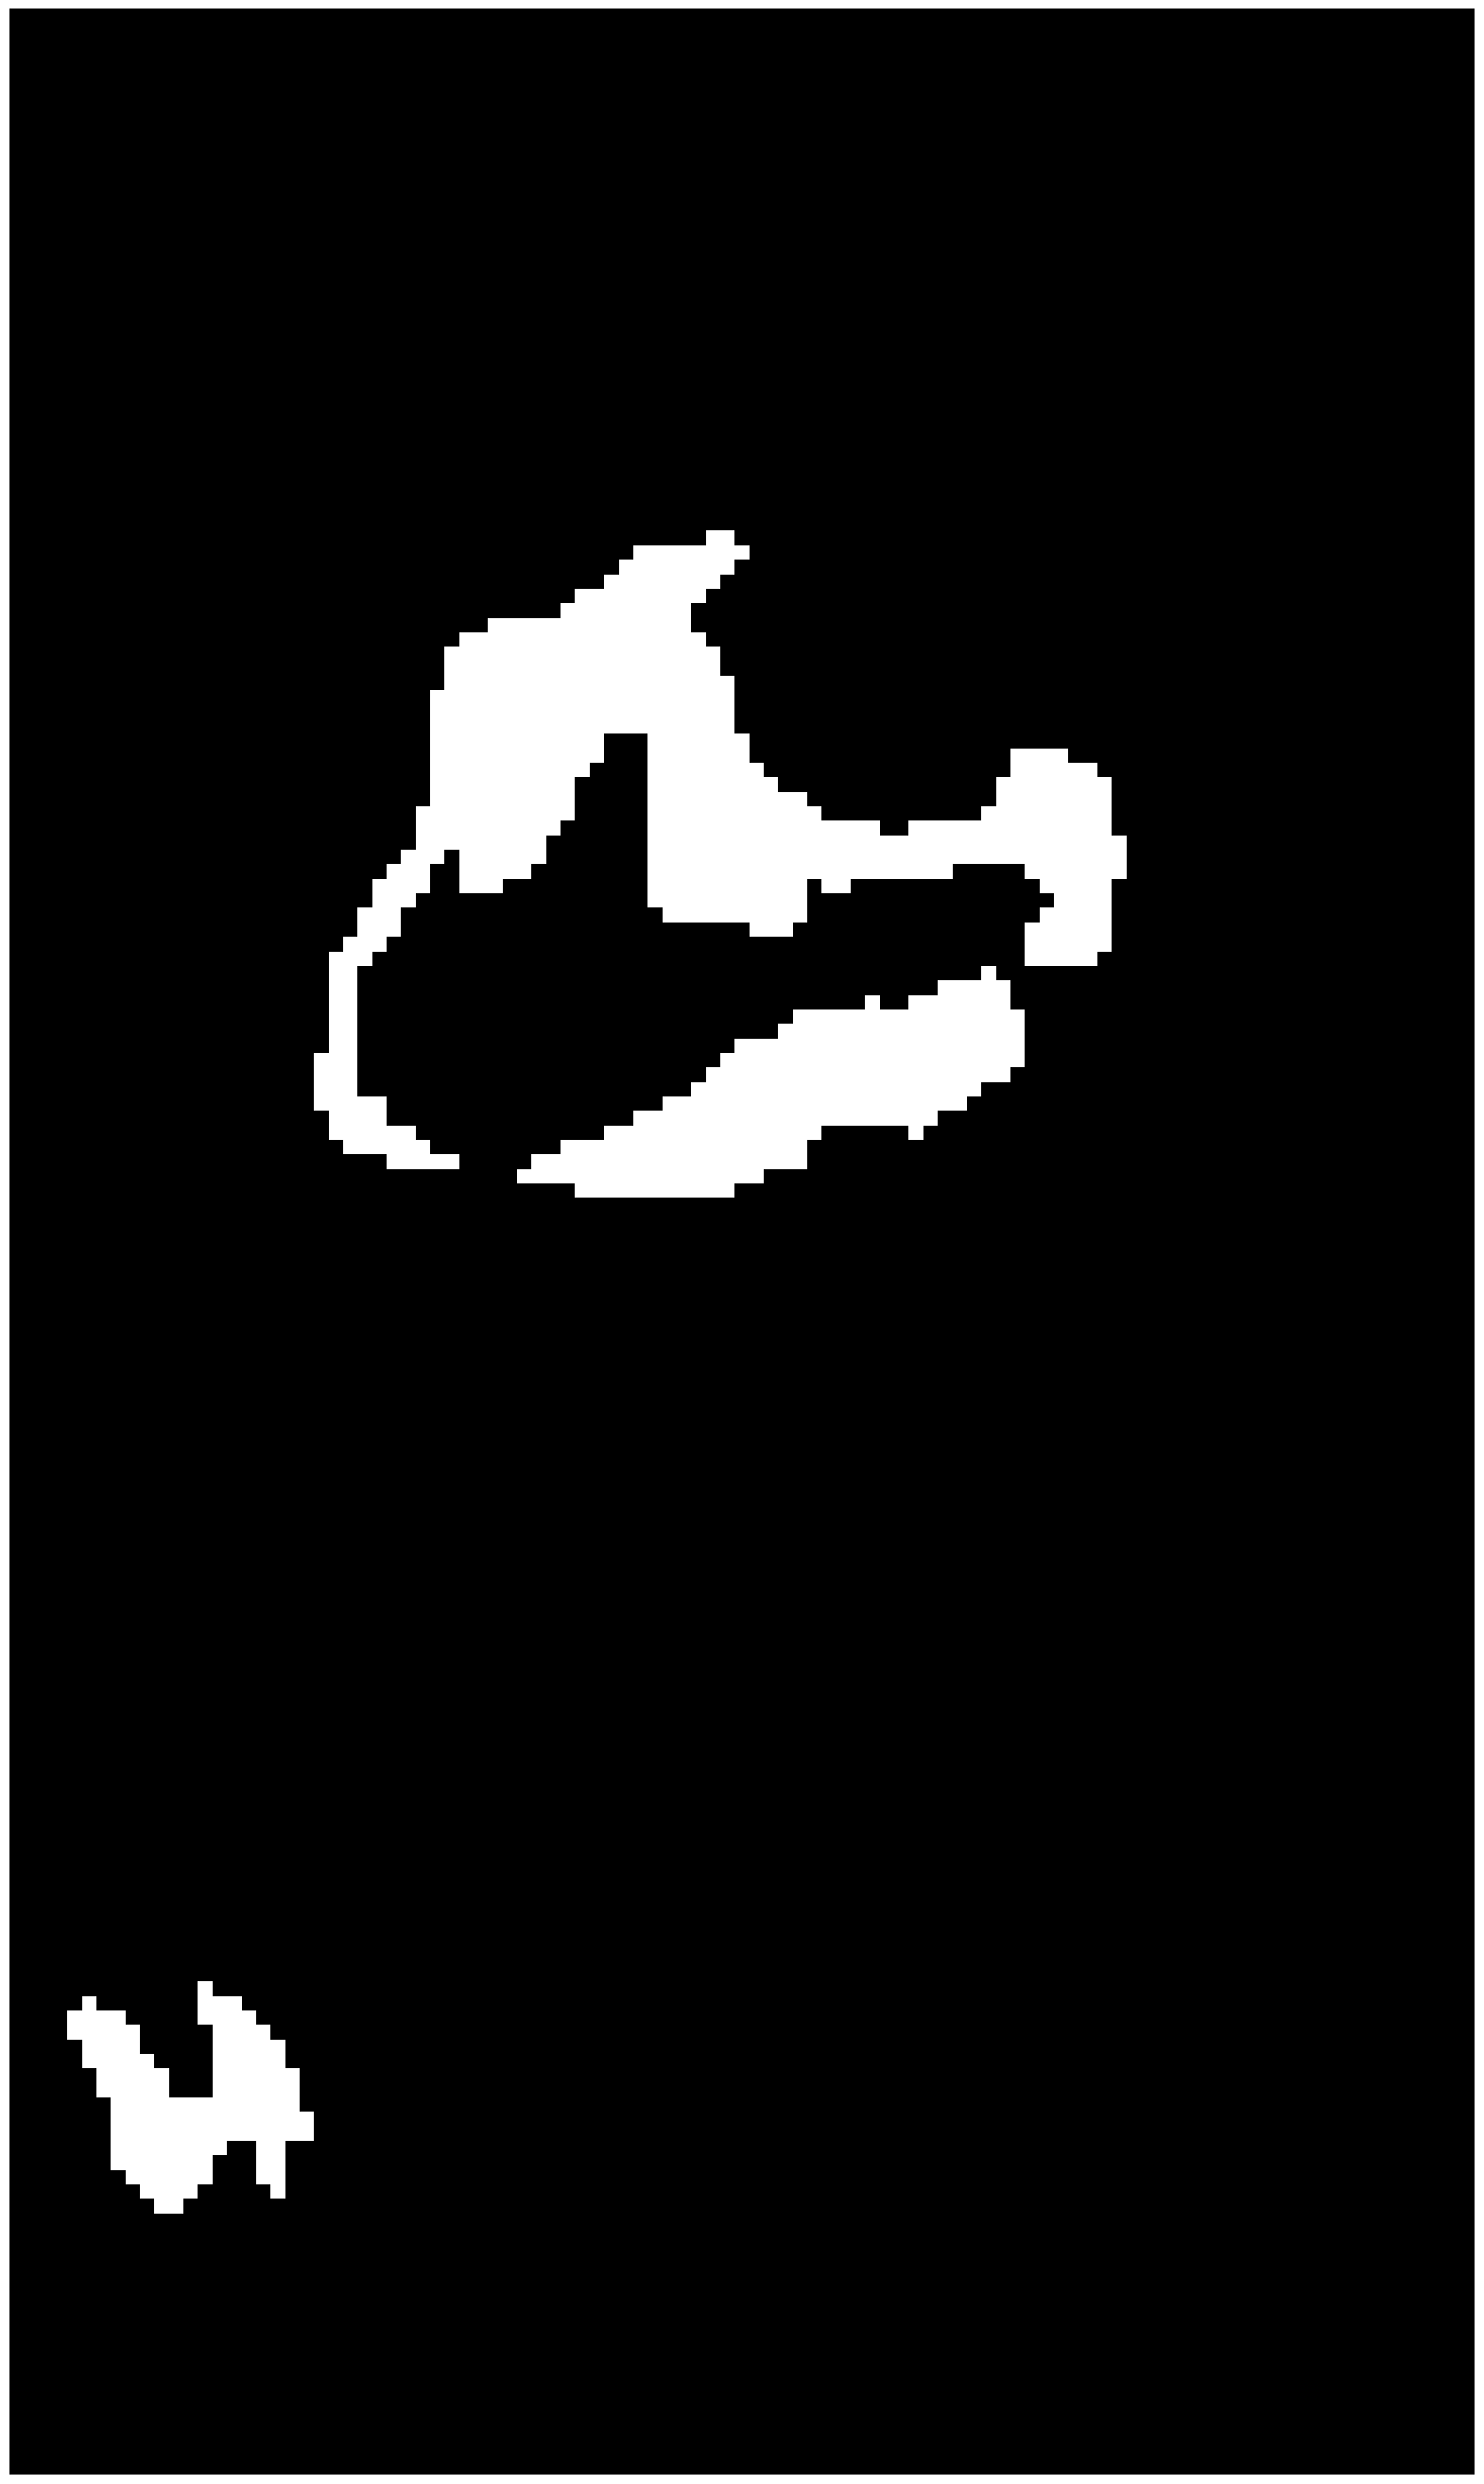

In [ ]:
image = Image.open('/content/out/malignant/fcmeans_10.png')
rgb = image.convert("RGB")
plt.imshow(image, cmap=plt.cm.gray)
plt.axis("off")
inference(rgb)

tensor([[-0.1420, -0.0542]], grad_fn=<AddmmBackward0>)
malignant


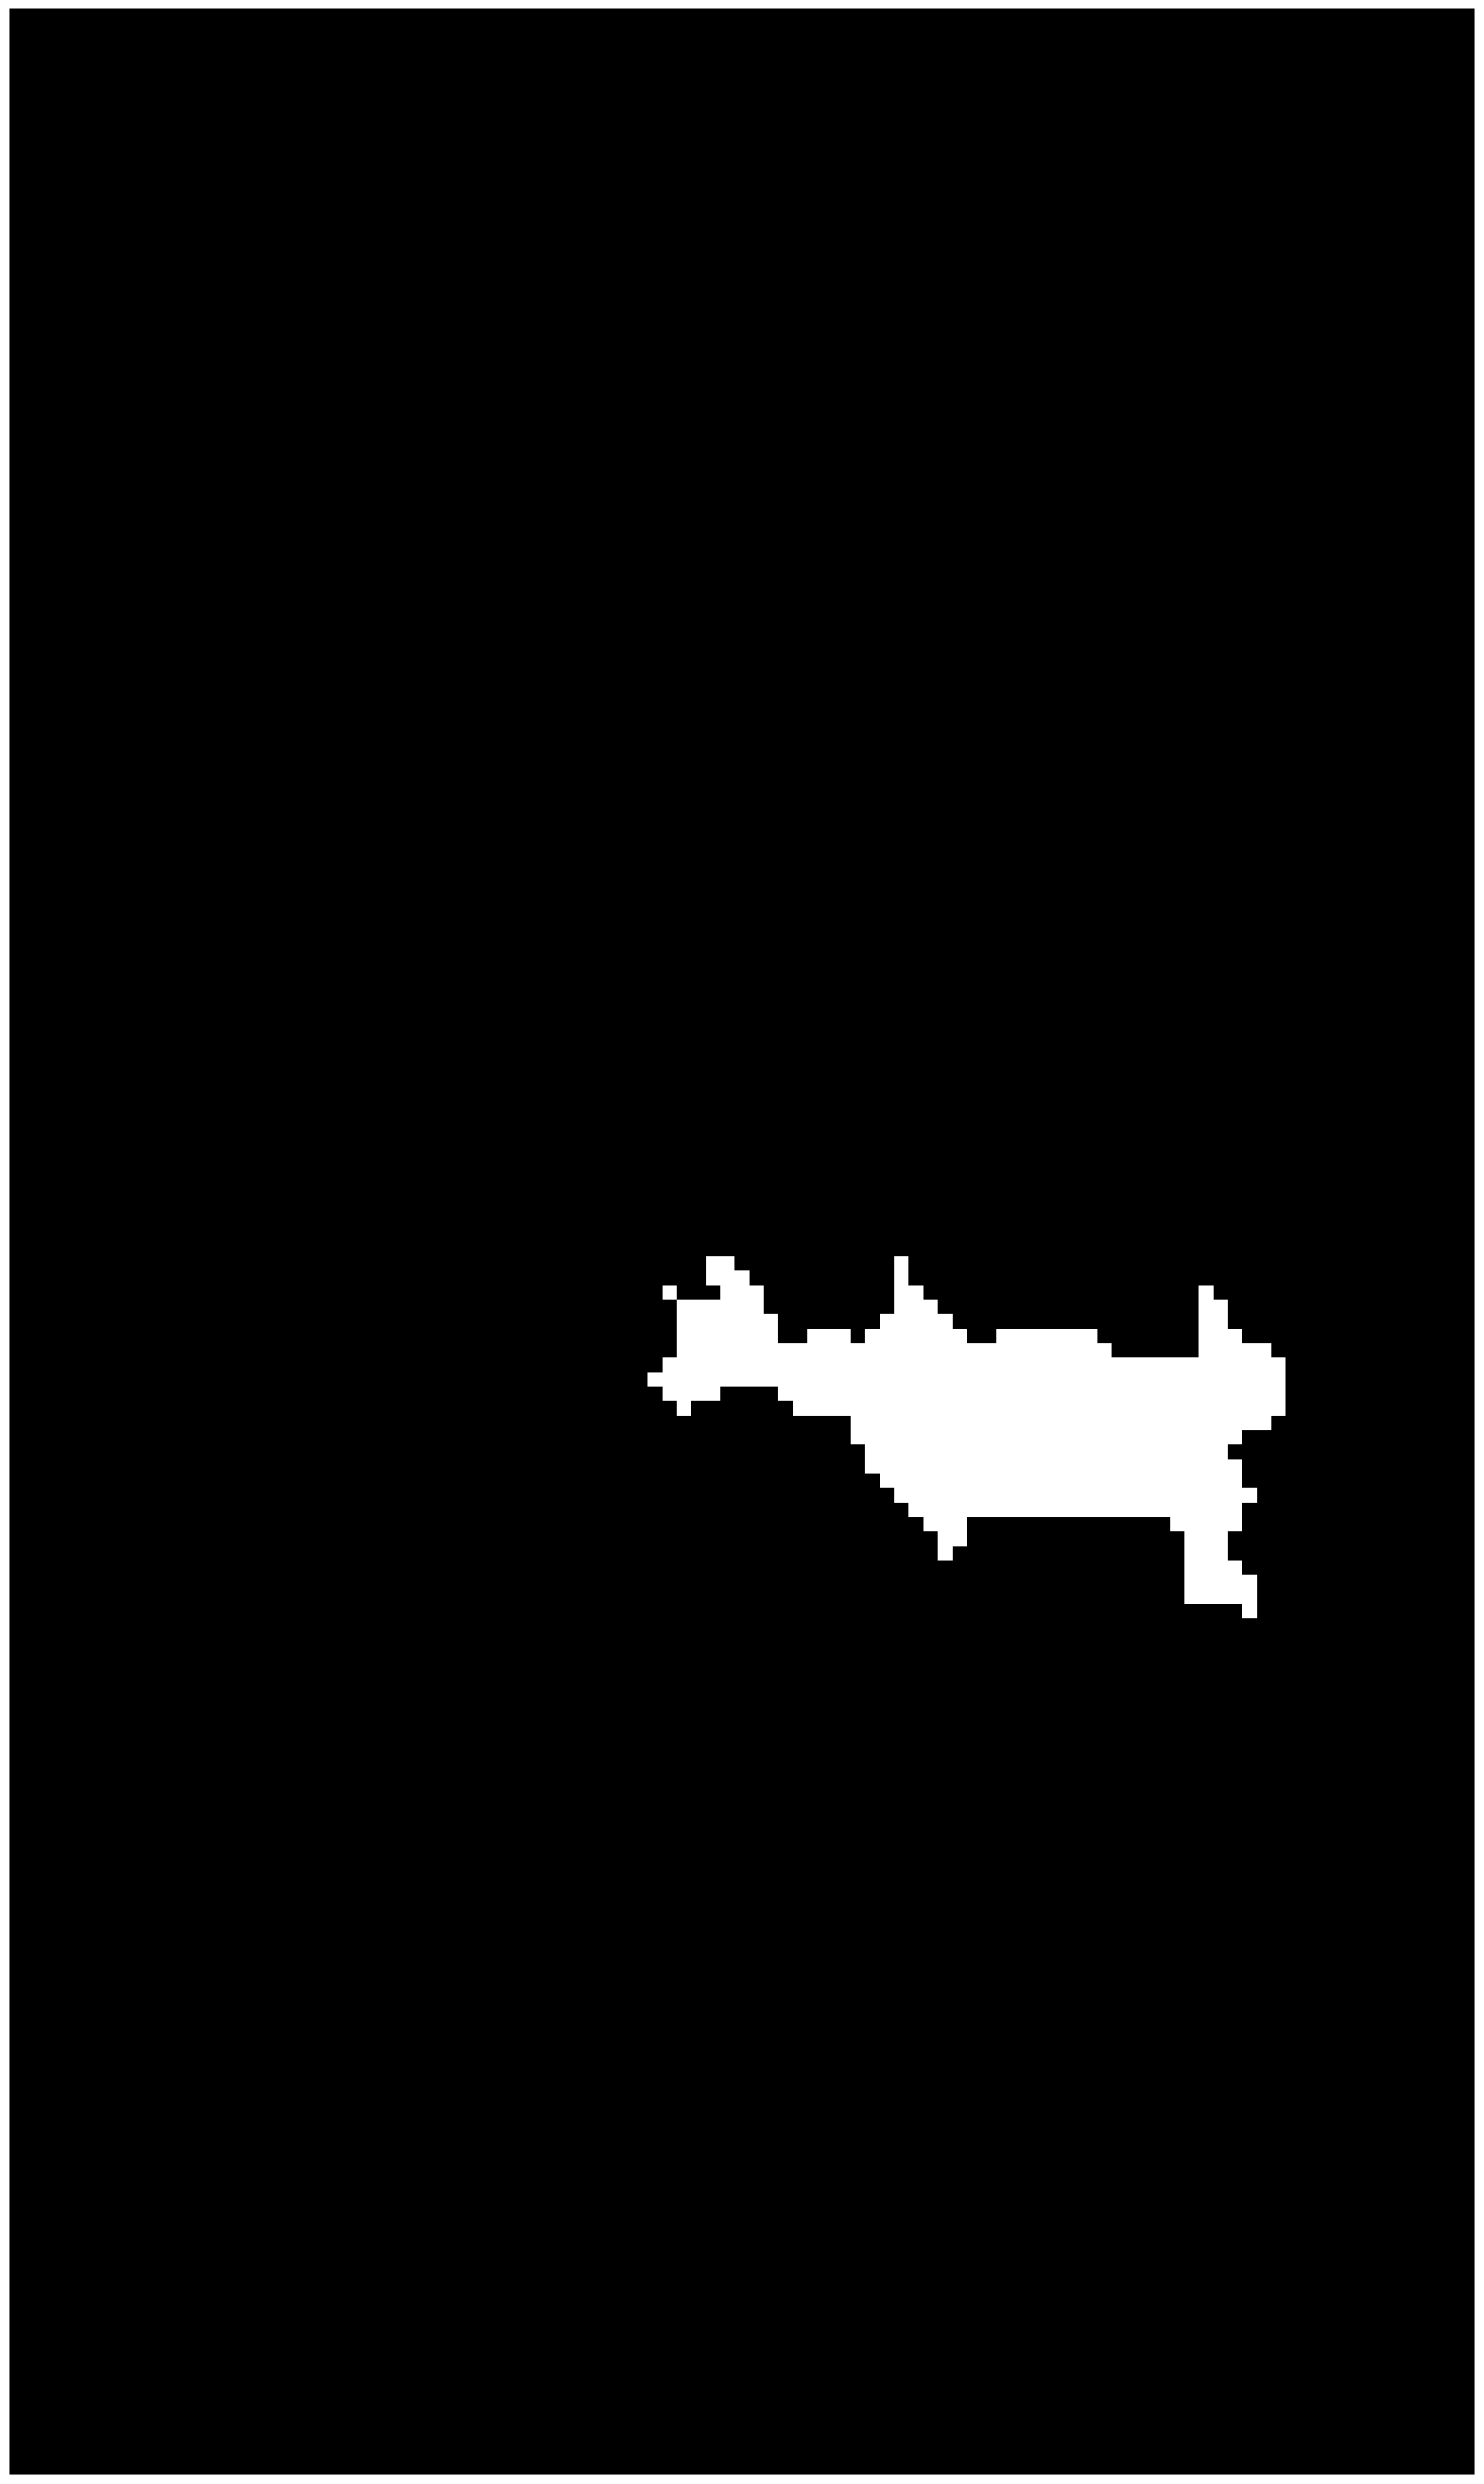

In [ ]:
image = Image.open('/content/out/malignant/fcmeans_12.png')
rgb = image.convert("RGB")
plt.imshow(image,cmap=plt.cm.gray)
plt.axis("off")
inference(rgb)

tensor([[0.0074, 0.0411]], grad_fn=<AddmmBackward0>)
malignant


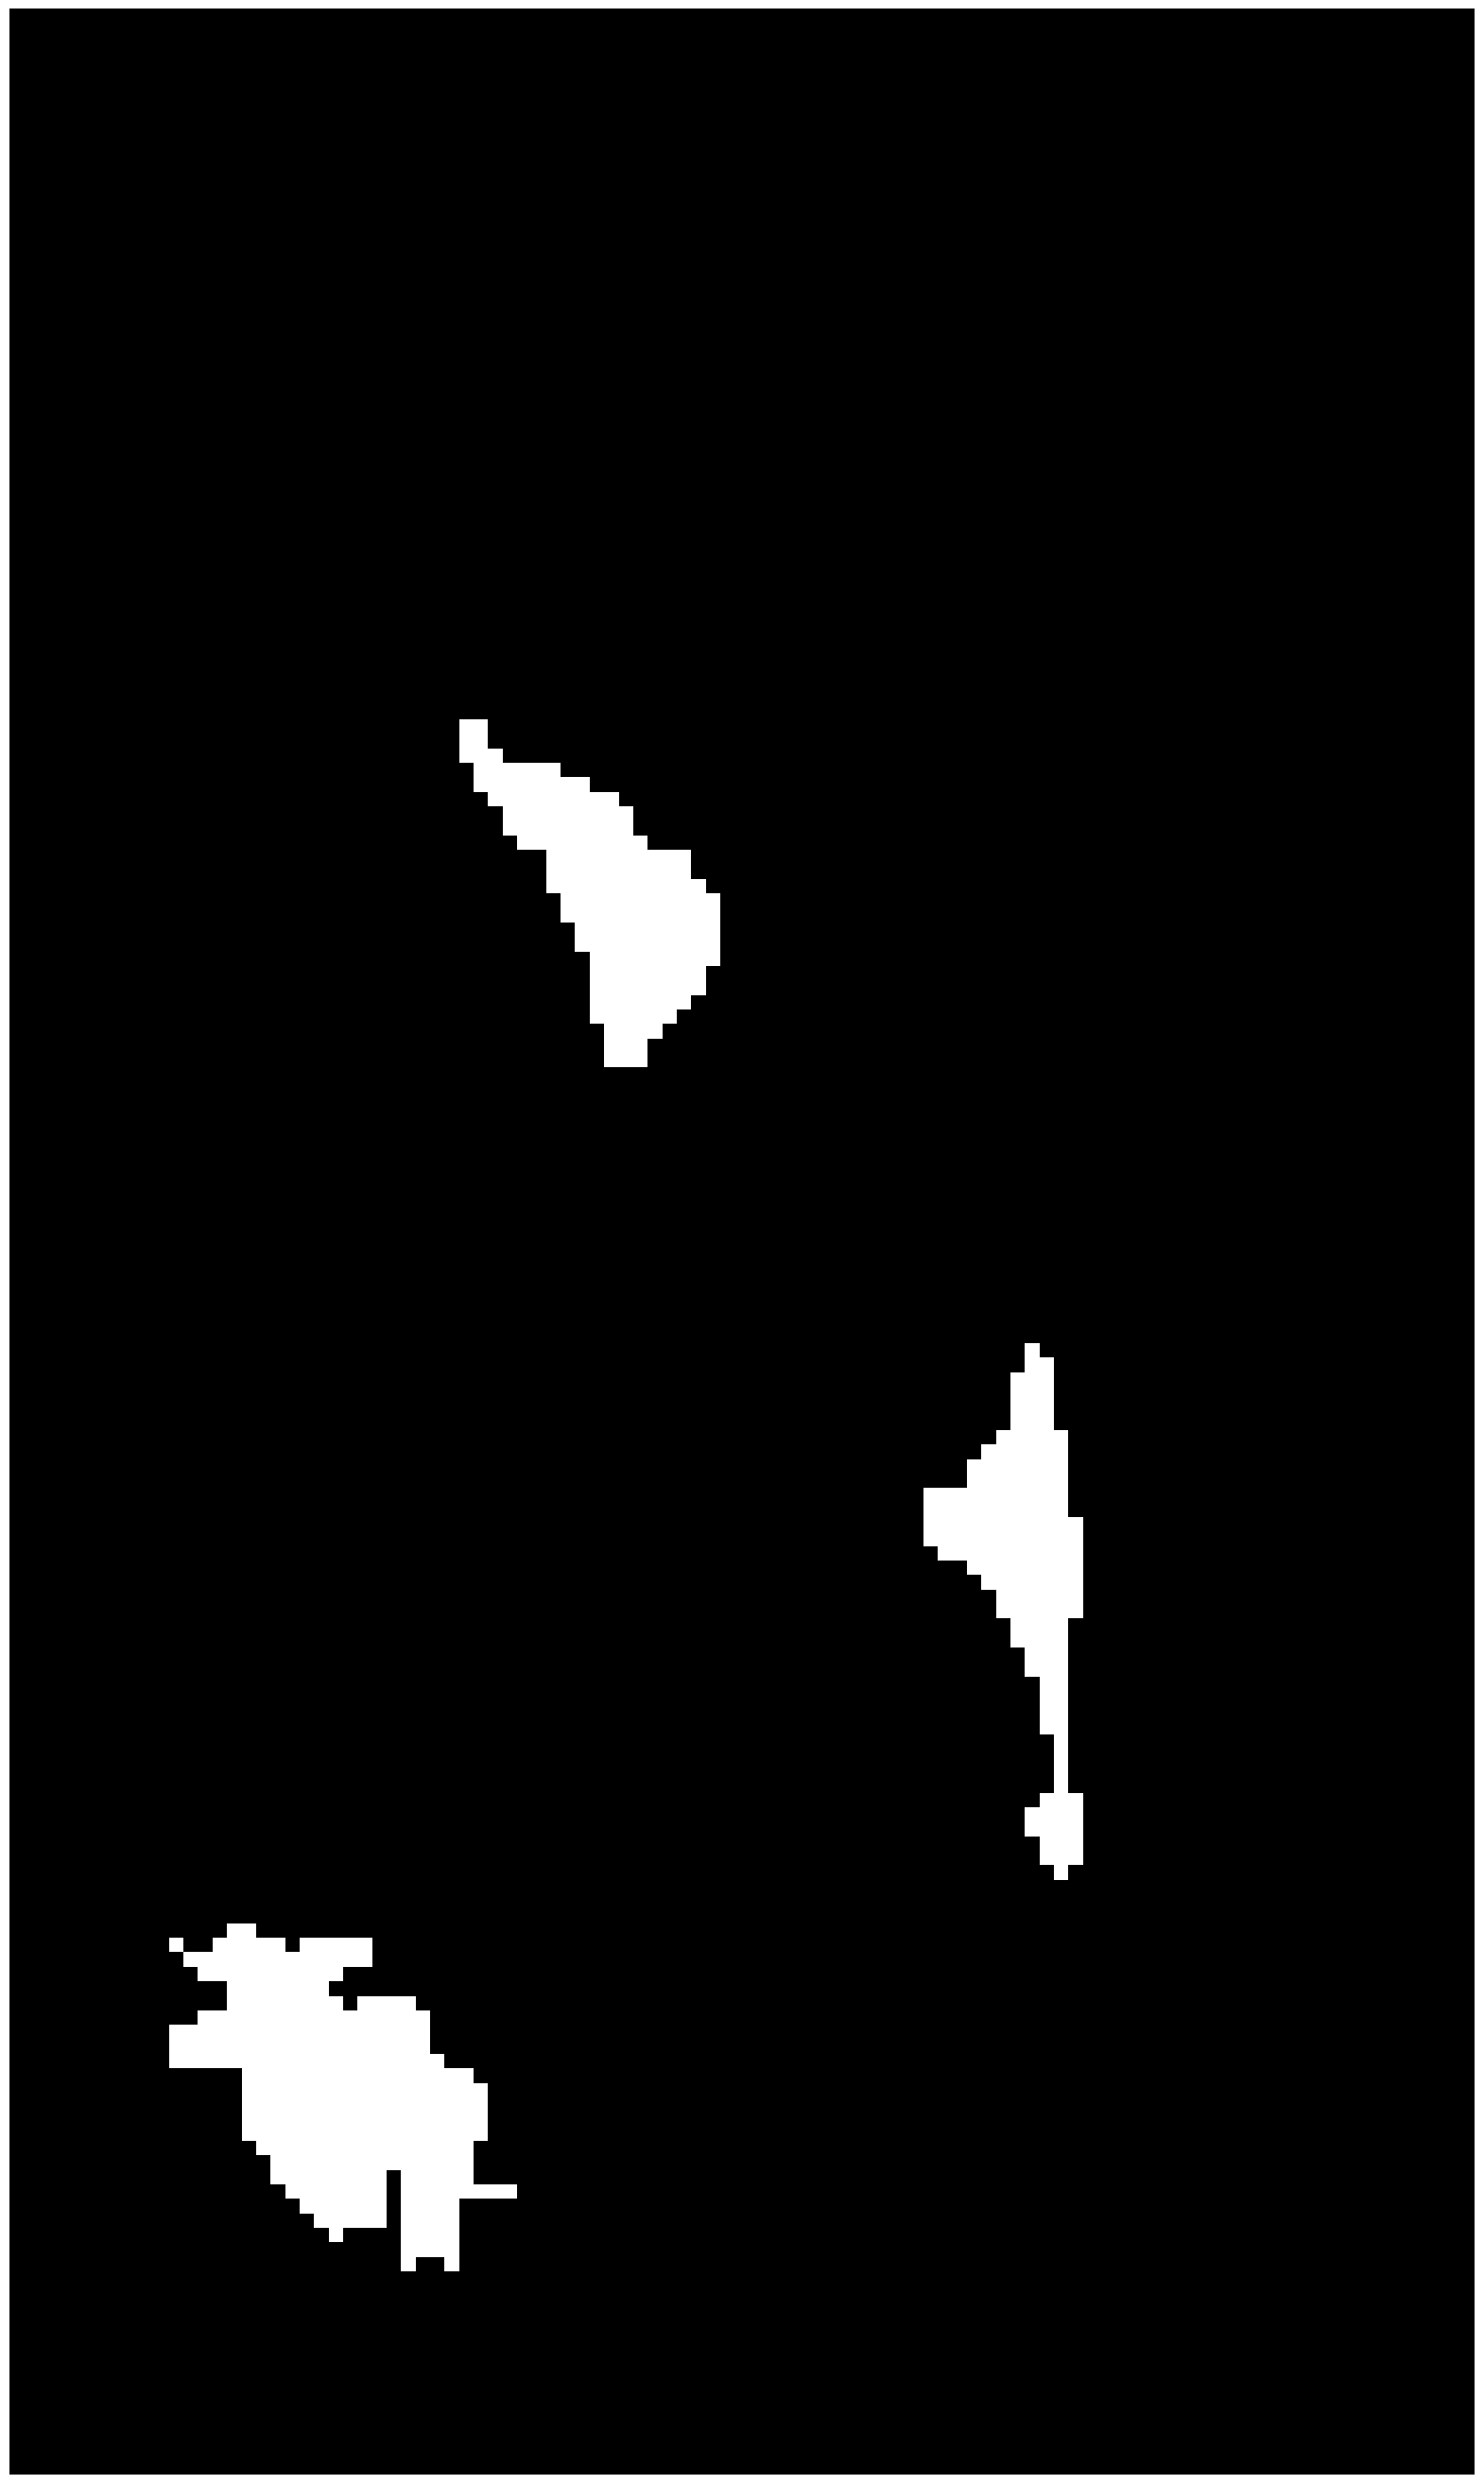

In [ ]:
image = Image.open('/content/out/malignant/fcmeans_6.png')
rgb = image.convert("RGB")
plt.imshow(image,cmap=plt.cm.gray)
plt.axis("off")
inference(rgb)

tensor([[-0.1007,  0.0461]], grad_fn=<AddmmBackward0>)
malignant


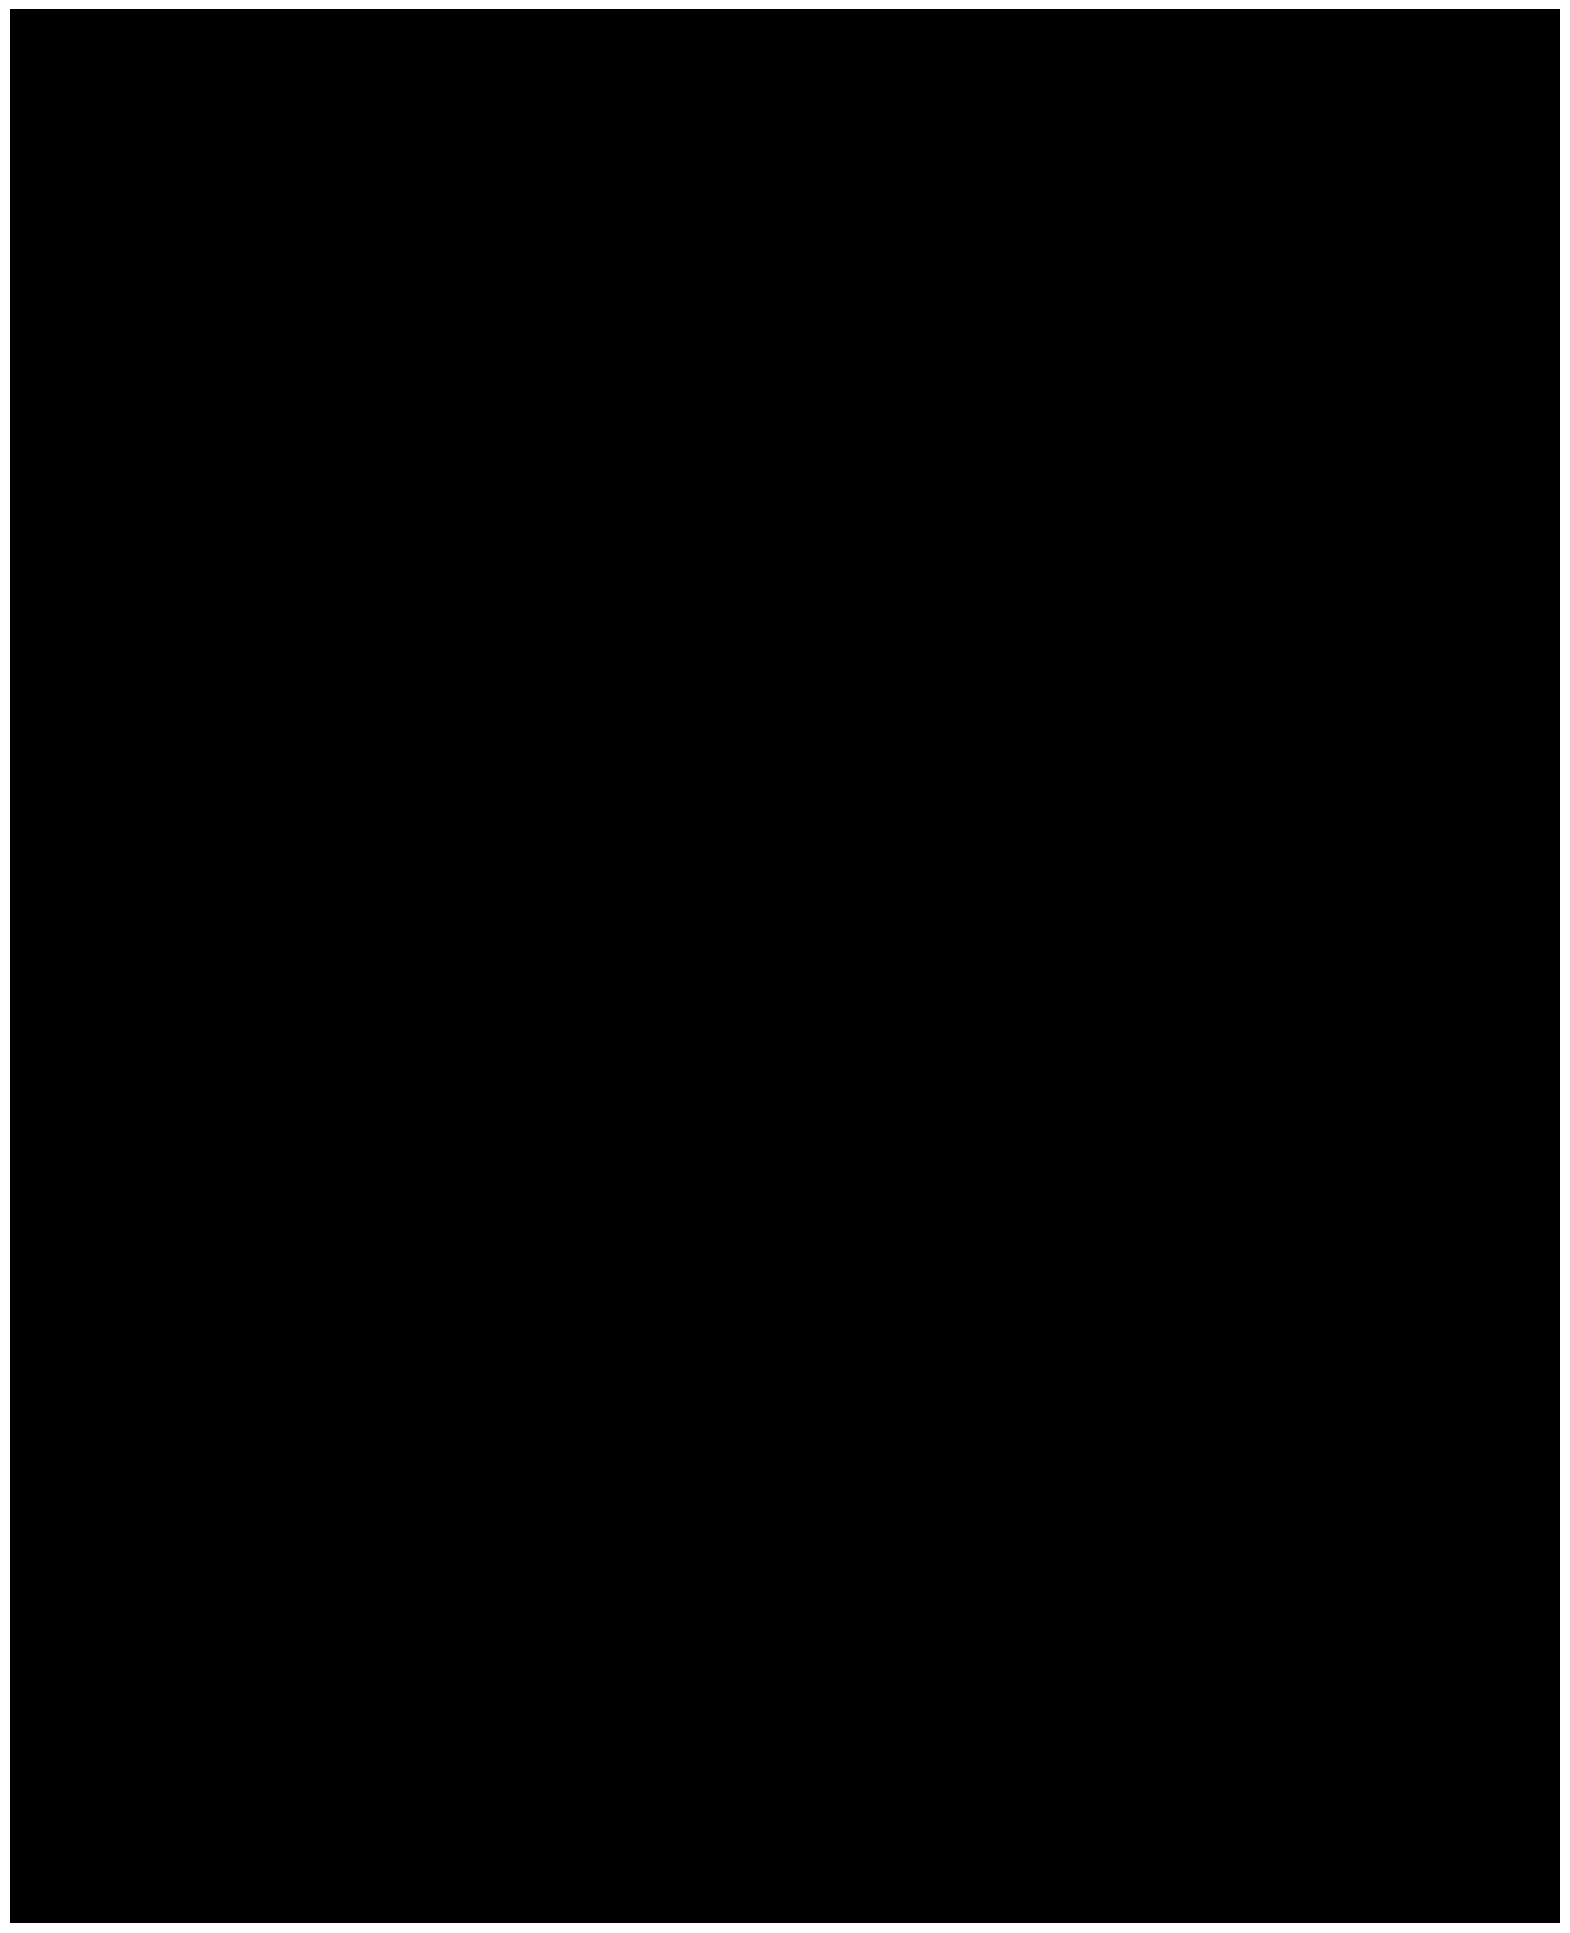

In [ ]:
image = Image.open('/content/out/benign/10sampled.png')
rgb = image.convert("RGB")
plt.imshow(image,cmap=plt.cm.gray)
plt.axis("off")
inference(rgb)

In [ ]:
# thats the end
# thank you